### Import required packages and limit GPU usage

In [52]:
import numpy as np
import math
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv

# Import the module
import networks
import utils
from quantize_neural_net import QuantizeNeuralNet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [42]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [ ]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student_nokd = 'checkpoints_student/checkpoints_student_NoKD/'
checkpoints_path_student_van = 'checkpoints_student/checkpoints_student_VAN/'
checkpoints_path_student_qat = 'checkpoints_student/checkpoints_student_QAT/'
checkpoints_path_student_dml = 'checkpoints_student/checkpoints_student_DML/'
if not os.path.exists(checkpoints_path_teacher):
    os.makedirs(checkpoints_path_teacher)
if not os.path.exists(checkpoints_path_student_nokd):
    os.makedirs(checkpoints_path_student_nokd)
if not os.path.exists(checkpoints_path_student_van):
    os.makedirs(checkpoints_path_student_van)
if not os.path.exists(checkpoints_path_student_qat):
    os.makedirs(checkpoints_path_student_qat)
if not os.path.exists(checkpoints_path_student_dml):
    os.makedirs(checkpoints_path_student_dml)

### Load dataset

In [44]:
import torchvision
import torchvision.transforms as transforms
import PIL

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

import torchvision as tv
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)

## Teacher Model

### load pre-trained teacher model

In [45]:
import detectors
import timm

teacher_net = timm.create_model("resnet50_cifar10", pretrained=True)

teacher_net = teacher_net.to(fast_device)
# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test accuracy:  0.9225


In [46]:
# another way load teacher
teacher_net = networks.TeacherNetwork50()

checkpoint = torch.load('resnet50_cifar10_pretrained.bin')

teacher_net.model.load_state_dict(checkpoint)
teacher_net.to(fast_device)

reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_19444\1025170478.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

test accuracy:  0.9225


### Quantized Teacher Model

In [49]:
# Quantization CSV file setup
csv_file = "checkpoints_teacher/results_teacher_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [ ]:
bits_list = range(2, 31, 2)  # 2, 4, ..., 30

def calculate_bit_size(model):
    """
    Calculate the effective bit size of a quantized model.
    
    Parameters:
        model: nn.Module
            The quantized neural network model.
    
    Returns:
        float: The average bit size across all layers.
    """
    total_bits = 0
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Calculate unique values and their count
            unique_values = torch.unique(param.data).cpu().numpy()
            num_unique_values = len(unique_values)
            
            # Calculate bit size for this layer
            layer_bits = np.ceil(np.log2(num_unique_values)) if num_unique_values > 1 else 1
            total_bits += layer_bits * param.numel()
            total_params += param.numel()
    
    # Return average bit size across all parameters
    return total_bits / total_params if total_params > 0 else 0

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        teacher_net.model,
        'resnet50',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=1.16,
        cnn_alphabet_scalar=1.16,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.9225, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 63.83it/s]


The quantization error of layer 0 is 74.75141906738281.
The relative quantization error of layer 0 is 0.3043535351753235.


Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 162.85it/s]


The quantization error of layer 1 is 35.41629409790039.
The relative quantization error of layer 1 is 0.32139432430267334.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2190.12it/s]


The quantization error of layer 2 is 15.934301376342773.
The relative quantization error of layer 2 is 0.25553348660469055.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 177.78it/s]


The quantization error of layer 3 is 32.39619445800781.
The relative quantization error of layer 3 is 0.34422844648361206.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 179.26it/s]


The quantization error of layer 4 is 49.3100700378418.
The relative quantization error of layer 4 is 0.29755058884620667.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 412.24it/s]


The quantization error of layer 5 is 31.44031524658203.
The relative quantization error of layer 5 is 0.2817111909389496.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2742.88it/s]


The quantization error of layer 6 is 11.435423851013184.
The relative quantization error of layer 6 is 0.25495684146881104.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 171.12it/s]


The quantization error of layer 7 is 19.194000244140625.
The relative quantization error of layer 7 is 0.31453484296798706.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 350.20it/s]


The quantization error of layer 8 is 28.050264358520508.
The relative quantization error of layer 8 is 0.2791241407394409.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2198.47it/s]


The quantization error of layer 9 is 7.500819683074951.
The relative quantization error of layer 9 is 0.23217202723026276.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 167.98it/s]


The quantization error of layer 10 is 13.657468795776367.
The relative quantization error of layer 10 is 0.3084966540336609.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 197.38it/s]


The quantization error of layer 11 is 46.16700744628906.
The relative quantization error of layer 11 is 0.2789711654186249.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1885.43it/s]


The quantization error of layer 12 is 14.17356014251709.
The relative quantization error of layer 12 is 0.22044014930725098.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 627.46it/s]


The quantization error of layer 13 is 12.79133415222168.
The relative quantization error of layer 13 is 0.2584977149963379.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 59.20it/s]


The quantization error of layer 14 is 62.22951889038086.
The relative quantization error of layer 14 is 0.26193684339523315.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1537.53it/s]


The quantization error of layer 15 is 14.716611862182617.
The relative quantization error of layer 15 is 0.2560330927371979.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2723.40it/s]


The quantization error of layer 16 is 4.128220558166504.
The relative quantization error of layer 16 is 0.18778859078884125.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 615.47it/s]


The quantization error of layer 17 is 7.703878402709961.
The relative quantization error of layer 17 is 0.29582053422927856.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1588.30it/s]


The quantization error of layer 18 is 16.03752326965332.
The relative quantization error of layer 18 is 0.2705574035644531.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3143.18it/s]


The quantization error of layer 19 is 4.815471172332764.
The relative quantization error of layer 19 is 0.21051625907421112.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 598.13it/s]


The quantization error of layer 20 is 7.015102863311768.
The relative quantization error of layer 20 is 0.3418448567390442.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1651.60it/s]


The quantization error of layer 21 is 16.831050872802734.
The relative quantization error of layer 21 is 0.28919970989227295.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3000.00it/s]


The quantization error of layer 22 is 3.6421430110931396.
The relative quantization error of layer 22 is 0.23563769459724426.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 658.66it/s]


The quantization error of layer 23 is 6.332967281341553.
The relative quantization error of layer 23 is 0.3809968829154968.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1021.95it/s]


The quantization error of layer 24 is 28.348047256469727.
The relative quantization error of layer 24 is 0.28598836064338684.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2651.32it/s]


The quantization error of layer 25 is 7.760924339294434.
The relative quantization error of layer 25 is 0.19425258040428162.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 992.25it/s]


The quantization error of layer 26 is 9.241960525512695.
The relative quantization error of layer 26 is 0.24000994861125946.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 320.80it/s]


The quantization error of layer 27 is 30.841838836669922.
The relative quantization error of layer 27 is 0.2819196283817291.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2255.51it/s]


The quantization error of layer 28 is 7.24064826965332.
The relative quantization error of layer 28 is 0.20368382334709167.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3015.71it/s]


The quantization error of layer 29 is 1.2102839946746826.
The relative quantization error of layer 29 is 0.11046106368303299.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1127.78it/s]


The quantization error of layer 30 is 3.1943657398223877.
The relative quantization error of layer 30 is 0.2461012452840805.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2120.07it/s]


The quantization error of layer 31 is 7.6700119972229.
The relative quantization error of layer 31 is 0.22331516444683075.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3035.57it/s]


The quantization error of layer 32 is 1.3028006553649902.
The relative quantization error of layer 32 is 0.10552302747964859.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1103.45it/s]


The quantization error of layer 33 is 3.5631821155548096.
The relative quantization error of layer 33 is 0.2698371410369873.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2172.26it/s]


The quantization error of layer 34 is 9.077886581420898.
The relative quantization error of layer 34 is 0.23386691510677338.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2597.53it/s]


The quantization error of layer 35 is 1.5034607648849487.
The relative quantization error of layer 35 is 0.1180219054222107.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1117.91it/s]


The quantization error of layer 36 is 4.175963401794434.
The relative quantization error of layer 36 is 0.3467108905315399.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2043.06it/s]


The quantization error of layer 37 is 10.177363395690918.
The relative quantization error of layer 37 is 0.2850300371646881.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2624.14it/s]


The quantization error of layer 38 is 1.7196729183197021.
The relative quantization error of layer 38 is 0.1327645629644394.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 944.65it/s]


The quantization error of layer 39 is 3.991440773010254.
The relative quantization error of layer 39 is 0.41265568137168884.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1914.02it/s]


The quantization error of layer 40 is 9.7926607131958.
The relative quantization error of layer 40 is 0.3102896511554718.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3113.52it/s]


The quantization error of layer 41 is 1.609020471572876.
The relative quantization error of layer 41 is 0.12733599543571472.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 927.66it/s]


The quantization error of layer 42 is 3.821528196334839.
The relative quantization error of layer 42 is 0.39679470658302307.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1346.90it/s]


The quantization error of layer 43 is 12.961925506591797.
The relative quantization error of layer 43 is 0.30996158719062805.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2901.75it/s]


The quantization error of layer 44 is 1.4532700777053833.
The relative quantization error of layer 44 is 0.07794291526079178.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1484.06it/s]


The quantization error of layer 45 is 3.5765187740325928.
The relative quantization error of layer 45 is 0.28158098459243774.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 592.25it/s]


The quantization error of layer 46 is 7.641849517822266.
The relative quantization error of layer 46 is 0.3641355037689209.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2473.43it/s]


The quantization error of layer 47 is 9.225818634033203.
The relative quantization error of layer 47 is 0.2368202954530716.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2358.24it/s]


The quantization error of layer 48 is 0.3827952444553375.
The relative quantization error of layer 48 is 0.07053051888942719.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1479.77it/s]


The quantization error of layer 49 is 1.4206205606460571.
The relative quantization error of layer 49 is 0.3241168260574341.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2701.84it/s]


The quantization error of layer 50 is 13.575316429138184.
The relative quantization error of layer 50 is 0.23417633771896362.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3011.71it/s]


The quantization error of layer 51 is 0.35849595069885254.
The relative quantization error of layer 51 is 0.07326318323612213.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1501.47it/s]


The quantization error of layer 52 is 1.9614585638046265.
The relative quantization error of layer 52 is 0.34178441762924194.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2515.97it/s]


The quantization error of layer 53 is 19.970745086669922.
The relative quantization error of layer 53 is 0.14428873360157013.

Bits 2, Effective Quantized Bit Size: 3.0149168979579897
Bits 2, Quantized Test Accuracy: 0.9088
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 329.28it/s]

The quantization error of layer 0 is 66.9831314086914.
The relative quantization error of layer 0 is 0.27934136986732483.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.44it/s]


The quantization error of layer 1 is 31.345476150512695.
The relative quantization error of layer 1 is 0.2853984236717224.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2548.66it/s]


The quantization error of layer 2 is 14.60810661315918.
The relative quantization error of layer 2 is 0.23284433782100677.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.46it/s]


The quantization error of layer 3 is 27.91997528076172.
The relative quantization error of layer 3 is 0.2969741225242615.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.57it/s]


The quantization error of layer 4 is 44.58095169067383.
The relative quantization error of layer 4 is 0.27014508843421936.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 373.95it/s]


The quantization error of layer 5 is 29.683794021606445.
The relative quantization error of layer 5 is 0.26558050513267517.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2565.37it/s]


The quantization error of layer 6 is 11.566462516784668.
The relative quantization error of layer 6 is 0.2604098618030548.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 183.91it/s]


The quantization error of layer 7 is 16.952857971191406.
The relative quantization error of layer 7 is 0.2774997651576996.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 419.67it/s]


The quantization error of layer 8 is 24.79037094116211.
The relative quantization error of layer 8 is 0.2448756992816925.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2679.07it/s]


The quantization error of layer 9 is 6.465322971343994.
The relative quantization error of layer 9 is 0.19772538542747498.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.16it/s]


The quantization error of layer 10 is 11.67727279663086.
The relative quantization error of layer 10 is 0.2627602219581604.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 218.99it/s]


The quantization error of layer 11 is 37.697296142578125.
The relative quantization error of layer 11 is 0.22841599583625793.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1500.00it/s]


The quantization error of layer 12 is 12.57330322265625.
The relative quantization error of layer 12 is 0.19529446959495544.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 524.59it/s]


The quantization error of layer 13 is 10.506060600280762.
The relative quantization error of layer 13 is 0.2120474874973297.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 58.50it/s]


The quantization error of layer 14 is 52.717529296875.
The relative quantization error of layer 14 is 0.2208581119775772.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1380.05it/s]


The quantization error of layer 15 is 12.722126007080078.
The relative quantization error of layer 15 is 0.22234870493412018.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2509.02it/s]


The quantization error of layer 16 is 3.5605199337005615.
The relative quantization error of layer 16 is 0.16209672391414642.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 533.33it/s]


The quantization error of layer 17 is 6.127151966094971.
The relative quantization error of layer 17 is 0.23414677381515503.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1442.24it/s]


The quantization error of layer 18 is 13.181510925292969.
The relative quantization error of layer 18 is 0.22514641284942627.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2403.53it/s]


The quantization error of layer 19 is 3.913954496383667.
The relative quantization error of layer 19 is 0.1678055077791214.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 549.36it/s]


The quantization error of layer 20 is 5.34153938293457.
The relative quantization error of layer 20 is 0.25933006405830383.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1438.21it/s]


The quantization error of layer 21 is 13.088384628295898.
The relative quantization error of layer 21 is 0.2257148027420044.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2654.37it/s]


The quantization error of layer 22 is 2.745035171508789.
The relative quantization error of layer 22 is 0.175448477268219.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 656.41it/s]


The quantization error of layer 23 is 4.4061503410339355.
The relative quantization error of layer 23 is 0.26359686255455017.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1045.90it/s]


The quantization error of layer 24 is 21.228530883789062.
The relative quantization error of layer 24 is 0.21430204808712006.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2816.61it/s]


The quantization error of layer 25 is 6.075514793395996.
The relative quantization error of layer 25 is 0.153832346200943.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1075.77it/s]


The quantization error of layer 26 is 6.806357383728027.
The relative quantization error of layer 26 is 0.1776019036769867.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 336.68it/s]


The quantization error of layer 27 is 23.622976303100586.
The relative quantization error of layer 27 is 0.2169083058834076.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2111.34it/s]


The quantization error of layer 28 is 5.91540002822876.
The relative quantization error of layer 28 is 0.16936631500720978.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2916.45it/s]


The quantization error of layer 29 is 0.9008159637451172.
The relative quantization error of layer 29 is 0.08203240483999252.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1084.80it/s]


The quantization error of layer 30 is 2.4729950428009033.
The relative quantization error of layer 30 is 0.19021473824977875.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2285.72it/s]


The quantization error of layer 31 is 6.006417751312256.
The relative quantization error of layer 31 is 0.17598018050193787.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2654.26it/s]


The quantization error of layer 32 is 1.0303001403808594.
The relative quantization error of layer 32 is 0.08288659900426865.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1179.73it/s]


The quantization error of layer 33 is 2.613196849822998.
The relative quantization error of layer 33 is 0.1962519884109497.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2410.22it/s]


The quantization error of layer 34 is 6.540392875671387.
The relative quantization error of layer 34 is 0.16850869357585907.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3555.52it/s]


The quantization error of layer 35 is 0.9705906510353088.
The relative quantization error of layer 35 is 0.07759780436754227.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1185.00it/s]


The quantization error of layer 36 is 2.794811487197876.
The relative quantization error of layer 36 is 0.23317022621631622.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1850.44it/s]


The quantization error of layer 37 is 6.936887264251709.
The relative quantization error of layer 37 is 0.19653195142745972.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3286.73it/s]


The quantization error of layer 38 is 1.0342133045196533.
The relative quantization error of layer 38 is 0.0802331194281578.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1213.27it/s]


The quantization error of layer 39 is 2.6538960933685303.
The relative quantization error of layer 39 is 0.2801872789859772.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2295.11it/s]


The quantization error of layer 40 is 6.480883598327637.
The relative quantization error of layer 40 is 0.20542004704475403.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3149.66it/s]


The quantization error of layer 41 is 0.9996687769889832.
The relative quantization error of layer 41 is 0.07693099975585938.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1179.73it/s]


The quantization error of layer 42 is 2.6643011569976807.
The relative quantization error of layer 42 is 0.27525609731674194.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1437.97it/s]


The quantization error of layer 43 is 8.402486801147461.
The relative quantization error of layer 43 is 0.20150607824325562.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2574.30it/s]


The quantization error of layer 44 is 1.0286734104156494.
The relative quantization error of layer 44 is 0.05270499736070633.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1729.72it/s]


The quantization error of layer 45 is 2.8772552013397217.
The relative quantization error of layer 45 is 0.22234606742858887.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 614.28it/s]


The quantization error of layer 46 is 5.58685302734375.
The relative quantization error of layer 46 is 0.26341477036476135.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2263.95it/s]


The quantization error of layer 47 is 7.7573981285095215.
The relative quantization error of layer 47 is 0.19215263426303864.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3437.50it/s]


The quantization error of layer 48 is 0.28867965936660767.
The relative quantization error of layer 48 is 0.05077618733048439.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1723.91it/s]


The quantization error of layer 49 is 1.3013784885406494.
The relative quantization error of layer 49 is 0.29586061835289.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2946.76it/s]


The quantization error of layer 50 is 11.078422546386719.
The relative quantization error of layer 50 is 0.19239911437034607.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2393.76it/s]


The quantization error of layer 51 is 0.28552839159965515.
The relative quantization error of layer 51 is 0.0600602887570858.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1312.83it/s]


The quantization error of layer 52 is 1.7021747827529907.
The relative quantization error of layer 52 is 0.30030357837677.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3385.12it/s]


The quantization error of layer 53 is 15.228706359863281.
The relative quantization error of layer 53 is 0.10727124661207199.

Bits 4, Effective Quantized Bit Size: 5.010399202545555
Bits 4, Quantized Test Accuracy: 0.9139
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 300.53it/s]

The quantization error of layer 0 is 67.4151382446289.
The relative quantization error of layer 0 is 0.27905702590942383.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 195.34it/s]


The quantization error of layer 1 is 31.21977996826172.
The relative quantization error of layer 1 is 0.2817882299423218.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2306.86it/s]


The quantization error of layer 2 is 14.50682544708252.
The relative quantization error of layer 2 is 0.22832253575325012.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 181.52it/s]


The quantization error of layer 3 is 27.3410587310791.
The relative quantization error of layer 3 is 0.29040244221687317.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 179.18it/s]


The quantization error of layer 4 is 44.124237060546875.
The relative quantization error of layer 4 is 0.26754480600357056.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 417.88it/s]


The quantization error of layer 5 is 29.586013793945312.
The relative quantization error of layer 5 is 0.2620031535625458.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2709.76it/s]


The quantization error of layer 6 is 11.501262664794922.
The relative quantization error of layer 6 is 0.2566608488559723.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.82it/s]


The quantization error of layer 7 is 16.854856491088867.
The relative quantization error of layer 7 is 0.27561789751052856.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 405.03it/s]


The quantization error of layer 8 is 23.929779052734375.
The relative quantization error of layer 8 is 0.23605795204639435.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3051.20it/s]


The quantization error of layer 9 is 6.500518321990967.
The relative quantization error of layer 9 is 0.19976122677326202.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.62it/s]


The quantization error of layer 10 is 11.594869613647461.
The relative quantization error of layer 10 is 0.2615126073360443.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 223.15it/s]


The quantization error of layer 11 is 37.444313049316406.
The relative quantization error of layer 11 is 0.2261487990617752.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2092.42it/s]


The quantization error of layer 12 is 12.689505577087402.
The relative quantization error of layer 12 is 0.19672594964504242.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 639.75it/s]


The quantization error of layer 13 is 10.377237319946289.
The relative quantization error of layer 13 is 0.21029460430145264.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 59.84it/s]


The quantization error of layer 14 is 50.84135437011719.
The relative quantization error of layer 14 is 0.2133982628583908.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1505.00it/s]


The quantization error of layer 15 is 12.336895942687988.
The relative quantization error of layer 15 is 0.21337690949440002.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2917.96it/s]


The quantization error of layer 16 is 3.440180540084839.
The relative quantization error of layer 16 is 0.15761323273181915.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 644.50it/s]


The quantization error of layer 17 is 5.867945671081543.
The relative quantization error of layer 17 is 0.22582750022411346.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1635.32it/s]


The quantization error of layer 18 is 12.966320991516113.
The relative quantization error of layer 18 is 0.21873781085014343.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3146.50it/s]


The quantization error of layer 19 is 3.8707644939422607.
The relative quantization error of layer 19 is 0.16731208562850952.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 646.00it/s]


The quantization error of layer 20 is 5.1576385498046875.
The relative quantization error of layer 20 is 0.2504446506500244.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1595.86it/s]


The quantization error of layer 21 is 12.708144187927246.
The relative quantization error of layer 21 is 0.21903879940509796.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3217.74it/s]


The quantization error of layer 22 is 2.622819185256958.
The relative quantization error of layer 22 is 0.16786251962184906.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 657.87it/s]


The quantization error of layer 23 is 4.250904083251953.
The relative quantization error of layer 23 is 0.25576311349868774.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 901.77it/s]


The quantization error of layer 24 is 20.9106388092041.
The relative quantization error of layer 24 is 0.21216467022895813.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2792.31it/s]


The quantization error of layer 25 is 5.889051914215088.
The relative quantization error of layer 25 is 0.14675016701221466.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1135.48it/s]


The quantization error of layer 26 is 6.597007751464844.
The relative quantization error of layer 26 is 0.17017975449562073.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 338.41it/s]


The quantization error of layer 27 is 23.231475830078125.
The relative quantization error of layer 27 is 0.21402175724506378.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2270.81it/s]


The quantization error of layer 28 is 5.8523125648498535.
The relative quantization error of layer 28 is 0.16516700387001038.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3310.16it/s]


The quantization error of layer 29 is 0.894136905670166.
The relative quantization error of layer 29 is 0.08099999278783798.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1152.88it/s]


The quantization error of layer 30 is 2.370112657546997.
The relative quantization error of layer 30 is 0.18085749447345734.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2213.87it/s]


The quantization error of layer 31 is 5.760120868682861.
The relative quantization error of layer 31 is 0.1708884835243225.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3270.56it/s]


The quantization error of layer 32 is 0.937648594379425.
The relative quantization error of layer 32 is 0.07743415981531143.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1149.26it/s]


The quantization error of layer 33 is 2.579735517501831.
The relative quantization error of layer 33 is 0.1956048160791397.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2111.16it/s]


The quantization error of layer 34 is 6.475790977478027.
The relative quantization error of layer 34 is 0.16429376602172852.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3051.99it/s]


The quantization error of layer 35 is 0.9198211431503296.
The relative quantization error of layer 35 is 0.07234805822372437.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1050.24it/s]


The quantization error of layer 36 is 2.6593177318573.
The relative quantization error of layer 36 is 0.22428856790065765.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2057.77it/s]


The quantization error of layer 37 is 6.7529826164245605.
The relative quantization error of layer 37 is 0.18790408968925476.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3198.86it/s]


The quantization error of layer 38 is 0.9671808481216431.
The relative quantization error of layer 38 is 0.07361818104982376.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1188.81it/s]


The quantization error of layer 39 is 2.4557199478149414.
The relative quantization error of layer 39 is 0.26048743724823.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2257.26it/s]


The quantization error of layer 40 is 6.05305814743042.
The relative quantization error of layer 40 is 0.19392620027065277.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3160.59it/s]


The quantization error of layer 41 is 0.9446326494216919.
The relative quantization error of layer 41 is 0.07502715289592743.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1165.81it/s]


The quantization error of layer 42 is 2.445124864578247.
The relative quantization error of layer 42 is 0.2532714605331421.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1696.33it/s]


The quantization error of layer 43 is 8.19128704071045.
The relative quantization error of layer 43 is 0.19703683257102966.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3027.54it/s]


The quantization error of layer 44 is 0.9882463812828064.
The relative quantization error of layer 44 is 0.05360652506351471.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1635.29it/s]


The quantization error of layer 45 is 2.9544875621795654.
The relative quantization error of layer 45 is 0.22759570181369781.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 608.89it/s]


The quantization error of layer 46 is 5.608595848083496.
The relative quantization error of layer 46 is 0.2617287337779999.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2909.38it/s]


The quantization error of layer 47 is 7.753566741943359.
The relative quantization error of layer 47 is 0.18899013102054596.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3079.79it/s]


The quantization error of layer 48 is 0.29289454221725464.
The relative quantization error of layer 48 is 0.053601399064064026.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1609.16it/s]


The quantization error of layer 49 is 1.3506920337677002.
The relative quantization error of layer 49 is 0.29725778102874756.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2793.15it/s]


The quantization error of layer 50 is 10.597183227539062.
The relative quantization error of layer 50 is 0.18240322172641754.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3338.77it/s]


The quantization error of layer 51 is 0.286957710981369.
The relative quantization error of layer 51 is 0.05996713414788246.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1719.25it/s]


The quantization error of layer 52 is 1.7267590761184692.
The relative quantization error of layer 52 is 0.2972990572452545.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3416.56it/s]


The quantization error of layer 53 is 14.138864517211914.
The relative quantization error of layer 53 is 0.09980128705501556.

Bits 6, Effective Quantized Bit Size: 6.994736327891663
Bits 6, Quantized Test Accuracy: 0.9135
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 308.57it/s]

The quantization error of layer 0 is 69.11631774902344.
The relative quantization error of layer 0 is 0.27631664276123047.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 158.87it/s]


The quantization error of layer 1 is 30.72626495361328.
The relative quantization error of layer 1 is 0.2795521318912506.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2243.38it/s]


The quantization error of layer 2 is 14.12448501586914.
The relative quantization error of layer 2 is 0.22660326957702637.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 159.58it/s]


The quantization error of layer 3 is 28.03328514099121.
The relative quantization error of layer 3 is 0.2970427870750427.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.12it/s]


The quantization error of layer 4 is 44.20784378051758.
The relative quantization error of layer 4 is 0.26882633566856384.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 424.50it/s]


The quantization error of layer 5 is 29.450395584106445.
The relative quantization error of layer 5 is 0.26111817359924316.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2894.46it/s]


The quantization error of layer 6 is 11.435869216918945.
The relative quantization error of layer 6 is 0.25605687499046326.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 165.78it/s]


The quantization error of layer 7 is 16.76761245727539.
The relative quantization error of layer 7 is 0.27511054277420044.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 384.66it/s]


The quantization error of layer 8 is 24.387771606445312.
The relative quantization error of layer 8 is 0.24303188920021057.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2022.71it/s]


The quantization error of layer 9 is 6.53599739074707.
The relative quantization error of layer 9 is 0.2016976773738861.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.06it/s]


The quantization error of layer 10 is 11.605195045471191.
The relative quantization error of layer 10 is 0.2623780369758606.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 220.73it/s]


The quantization error of layer 11 is 37.03408432006836.
The relative quantization error of layer 11 is 0.22441966831684113.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2189.64it/s]


The quantization error of layer 12 is 12.889605522155762.
The relative quantization error of layer 12 is 0.19956830143928528.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 580.33it/s]


The quantization error of layer 13 is 10.425821304321289.
The relative quantization error of layer 13 is 0.21022477746009827.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 58.99it/s]


The quantization error of layer 14 is 52.16693878173828.
The relative quantization error of layer 14 is 0.21866758167743683.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1642.71it/s]


The quantization error of layer 15 is 12.794857025146484.
The relative quantization error of layer 15 is 0.221403568983078.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2510.67it/s]


The quantization error of layer 16 is 3.4022679328918457.
The relative quantization error of layer 16 is 0.15605409443378448.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 645.74it/s]


The quantization error of layer 17 is 5.832431793212891.
The relative quantization error of layer 17 is 0.2214699536561966.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1656.28it/s]


The quantization error of layer 18 is 13.147205352783203.
The relative quantization error of layer 18 is 0.22078514099121094.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2620.45it/s]


The quantization error of layer 19 is 3.887561559677124.
The relative quantization error of layer 19 is 0.16980768740177155.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 579.18it/s]


The quantization error of layer 20 is 5.243291854858398.
The relative quantization error of layer 20 is 0.25600865483283997.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1486.05it/s]


The quantization error of layer 21 is 13.062746047973633.
The relative quantization error of layer 21 is 0.2238575518131256.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2528.34it/s]


The quantization error of layer 22 is 2.673910617828369.
The relative quantization error of layer 22 is 0.17168974876403809.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 653.05it/s]


The quantization error of layer 23 is 4.237071990966797.
The relative quantization error of layer 23 is 0.2489970624446869.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 796.24it/s]


The quantization error of layer 24 is 20.590045928955078.
The relative quantization error of layer 24 is 0.20762094855308533.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2178.24it/s]


The quantization error of layer 25 is 5.9700608253479.
The relative quantization error of layer 25 is 0.1502462923526764.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 974.20it/s]


The quantization error of layer 26 is 6.530475616455078.
The relative quantization error of layer 26 is 0.16808845102787018.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 258.49it/s]


The quantization error of layer 27 is 23.043560028076172.
The relative quantization error of layer 27 is 0.21119336783885956.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2259.63it/s]


The quantization error of layer 28 is 5.860672473907471.
The relative quantization error of layer 28 is 0.1667652428150177.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2927.34it/s]


The quantization error of layer 29 is 0.949493944644928.
The relative quantization error of layer 29 is 0.08727141469717026.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1048.41it/s]


The quantization error of layer 30 is 2.4153401851654053.
The relative quantization error of layer 30 is 0.18479615449905396.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2118.11it/s]


The quantization error of layer 31 is 5.828490734100342.
The relative quantization error of layer 31 is 0.17189103364944458.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3019.29it/s]


The quantization error of layer 32 is 0.9952928423881531.
The relative quantization error of layer 32 is 0.07889802753925323.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 915.05it/s]


The quantization error of layer 33 is 2.5700113773345947.
The relative quantization error of layer 33 is 0.19599232077598572.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1816.36it/s]


The quantization error of layer 34 is 6.461388111114502.
The relative quantization error of layer 34 is 0.16870494186878204.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2953.73it/s]


The quantization error of layer 35 is 0.9312578439712524.
The relative quantization error of layer 35 is 0.07355241477489471.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 925.71it/s]


The quantization error of layer 36 is 2.707246780395508.
The relative quantization error of layer 36 is 0.22302067279815674.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2057.31it/s]


The quantization error of layer 37 is 6.80889368057251.
The relative quantization error of layer 37 is 0.1893104910850525.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3086.73it/s]


The quantization error of layer 38 is 0.9761892557144165.
The relative quantization error of layer 38 is 0.07499618083238602.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 994.90it/s]


The quantization error of layer 39 is 2.4607083797454834.
The relative quantization error of layer 39 is 0.2570689916610718.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2048.15it/s]


The quantization error of layer 40 is 6.141964435577393.
The relative quantization error of layer 40 is 0.19772064685821533.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2818.58it/s]


The quantization error of layer 41 is 0.9321746230125427.
The relative quantization error of layer 41 is 0.07198654860258102.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1109.43it/s]


The quantization error of layer 42 is 2.4676547050476074.
The relative quantization error of layer 42 is 0.25677981972694397.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1613.88it/s]


The quantization error of layer 43 is 8.492868423461914.
The relative quantization error of layer 43 is 0.20769797265529633.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3040.14it/s]


The quantization error of layer 44 is 0.9685949683189392.
The relative quantization error of layer 44 is 0.05095415934920311.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1699.76it/s]


The quantization error of layer 45 is 2.8892643451690674.
The relative quantization error of layer 45 is 0.2236357480287552.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 615.60it/s]


The quantization error of layer 46 is 5.520124912261963.
The relative quantization error of layer 46 is 0.2572712004184723.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2253.88it/s]


The quantization error of layer 47 is 8.22743034362793.
The relative quantization error of layer 47 is 0.21038226783275604.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2439.52it/s]


The quantization error of layer 48 is 0.27975815534591675.
The relative quantization error of layer 48 is 0.0502958670258522.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1415.08it/s]


The quantization error of layer 49 is 1.3181146383285522.
The relative quantization error of layer 49 is 0.29030609130859375.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2320.93it/s]


The quantization error of layer 50 is 10.69991397857666.
The relative quantization error of layer 50 is 0.18282341957092285.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2969.61it/s]


The quantization error of layer 51 is 0.2717467248439789.
The relative quantization error of layer 51 is 0.05730096250772476.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1583.53it/s]


The quantization error of layer 52 is 1.7281209230422974.
The relative quantization error of layer 52 is 0.3007306456565857.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3288.82it/s]


The quantization error of layer 53 is 16.76236343383789.
The relative quantization error of layer 53 is 0.1200394481420517.

Bits 8, Effective Quantized Bit Size: 8.89506285531785
Bits 8, Quantized Test Accuracy: 0.9143
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.36it/s]

The quantization error of layer 0 is 67.5791015625.
The relative quantization error of layer 0 is 0.2783629596233368.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 149.07it/s]


The quantization error of layer 1 is 30.893993377685547.
The relative quantization error of layer 1 is 0.28075116872787476.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2686.25it/s]


The quantization error of layer 2 is 14.481158256530762.
The relative quantization error of layer 2 is 0.23356477916240692.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.63it/s]


The quantization error of layer 3 is 27.823747634887695.
The relative quantization error of layer 3 is 0.2956250011920929.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 182.11it/s]


The quantization error of layer 4 is 44.735294342041016.
The relative quantization error of layer 4 is 0.26998376846313477.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 418.67it/s]


The quantization error of layer 5 is 29.41802406311035.
The relative quantization error of layer 5 is 0.26406580209732056.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2728.53it/s]


The quantization error of layer 6 is 11.407072067260742.
The relative quantization error of layer 6 is 0.25258055329322815.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 173.14it/s]


The quantization error of layer 7 is 16.770540237426758.
The relative quantization error of layer 7 is 0.27432504296302795.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 362.26it/s]


The quantization error of layer 8 is 24.23208236694336.
The relative quantization error of layer 8 is 0.23862722516059875.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2557.23it/s]


The quantization error of layer 9 is 6.534883975982666.
The relative quantization error of layer 9 is 0.2022222876548767.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 164.72it/s]


The quantization error of layer 10 is 11.446812629699707.
The relative quantization error of layer 10 is 0.2584906220436096.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 200.40it/s]


The quantization error of layer 11 is 36.987213134765625.
The relative quantization error of layer 11 is 0.22347749769687653.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2077.92it/s]


The quantization error of layer 12 is 12.624211311340332.
The relative quantization error of layer 12 is 0.1965578943490982.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 543.53it/s]


The quantization error of layer 13 is 10.300722122192383.
The relative quantization error of layer 13 is 0.20810319483280182.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 58.33it/s]


The quantization error of layer 14 is 50.98981857299805.
The relative quantization error of layer 14 is 0.21410128474235535.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1594.62it/s]


The quantization error of layer 15 is 12.535849571228027.
The relative quantization error of layer 15 is 0.21626634895801544.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3131.28it/s]


The quantization error of layer 16 is 3.374582290649414.
The relative quantization error of layer 16 is 0.15380597114562988.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 626.03it/s]


The quantization error of layer 17 is 5.8374104499816895.
The relative quantization error of layer 17 is 0.2237870693206787.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1444.92it/s]


The quantization error of layer 18 is 12.876378059387207.
The relative quantization error of layer 18 is 0.21733170747756958.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2547.49it/s]


The quantization error of layer 19 is 3.890535831451416.
The relative quantization error of layer 19 is 0.16705206036567688.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 581.49it/s]


The quantization error of layer 20 is 5.220319747924805.
The relative quantization error of layer 20 is 0.25487470626831055.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1634.89it/s]


The quantization error of layer 21 is 12.629465103149414.
The relative quantization error of layer 21 is 0.21705254912376404.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2338.94it/s]


The quantization error of layer 22 is 2.687164306640625.
The relative quantization error of layer 22 is 0.17205096781253815.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 613.04it/s]


The quantization error of layer 23 is 4.306229591369629.
The relative quantization error of layer 23 is 0.2564045488834381.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1009.12it/s]


The quantization error of layer 24 is 20.4952449798584.
The relative quantization error of layer 24 is 0.20660896599292755.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2513.68it/s]


The quantization error of layer 25 is 6.09122371673584.
The relative quantization error of layer 25 is 0.15099158883094788.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1072.39it/s]


The quantization error of layer 26 is 6.527340412139893.
The relative quantization error of layer 26 is 0.16728372871875763.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 325.68it/s]


The quantization error of layer 27 is 22.649995803833008.
The relative quantization error of layer 27 is 0.20797401666641235.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2170.80it/s]


The quantization error of layer 28 is 6.066375732421875.
The relative quantization error of layer 28 is 0.17266173660755157.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2964.86it/s]


The quantization error of layer 29 is 0.9268618822097778.
The relative quantization error of layer 29 is 0.08369789272546768.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1131.95it/s]


The quantization error of layer 30 is 2.437309741973877.
The relative quantization error of layer 30 is 0.18639154732227325.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2219.85it/s]


The quantization error of layer 31 is 5.723237037658691.
The relative quantization error of layer 31 is 0.16725754737854004.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2931.44it/s]


The quantization error of layer 32 is 0.9496426582336426.
The relative quantization error of layer 32 is 0.07616996765136719.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1082.20it/s]


The quantization error of layer 33 is 2.585386276245117.
The relative quantization error of layer 33 is 0.19608823955059052.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2182.56it/s]


The quantization error of layer 34 is 6.5186567306518555.
The relative quantization error of layer 34 is 0.16830728948116302.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3179.10it/s]


The quantization error of layer 35 is 0.886430561542511.
The relative quantization error of layer 35 is 0.06960106641054153.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1075.50it/s]


The quantization error of layer 36 is 2.7033703327178955.
The relative quantization error of layer 36 is 0.22627770900726318.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2287.92it/s]


The quantization error of layer 37 is 6.665965557098389.
The relative quantization error of layer 37 is 0.186651811003685.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3141.92it/s]


The quantization error of layer 38 is 0.9354243278503418.
The relative quantization error of layer 38 is 0.07371798902750015.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1060.03it/s]


The quantization error of layer 39 is 2.4347941875457764.
The relative quantization error of layer 39 is 0.26344549655914307.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2218.90it/s]


The quantization error of layer 40 is 6.081598281860352.
The relative quantization error of layer 40 is 0.19535097479820251.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3205.25it/s]


The quantization error of layer 41 is 0.91428142786026.
The relative quantization error of layer 41 is 0.0760408416390419.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1139.92it/s]


The quantization error of layer 42 is 2.4411733150482178.
The relative quantization error of layer 42 is 0.25610288977622986.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1611.53it/s]


The quantization error of layer 43 is 7.960639953613281.
The relative quantization error of layer 43 is 0.19278037548065186.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2721.25it/s]


The quantization error of layer 44 is 1.0123097896575928.
The relative quantization error of layer 44 is 0.05241803079843521.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1627.96it/s]


The quantization error of layer 45 is 2.807657480239868.
The relative quantization error of layer 45 is 0.21909523010253906.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 643.10it/s]


The quantization error of layer 46 is 5.501081943511963.
The relative quantization error of layer 46 is 0.2553962767124176.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2633.97it/s]


The quantization error of layer 47 is 7.434414863586426.
The relative quantization error of layer 47 is 0.18079306185245514.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3315.09it/s]


The quantization error of layer 48 is 0.27515098452568054.
The relative quantization error of layer 48 is 0.049798812717199326.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1681.44it/s]


The quantization error of layer 49 is 1.2987293004989624.
The relative quantization error of layer 49 is 0.2940298020839691.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2641.88it/s]


The quantization error of layer 50 is 11.507728576660156.
The relative quantization error of layer 50 is 0.19710762798786163.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3216.49it/s]


The quantization error of layer 51 is 0.2804052233695984.
The relative quantization error of layer 51 is 0.0595744326710701.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1587.08it/s]


The quantization error of layer 52 is 1.6839590072631836.
The relative quantization error of layer 52 is 0.2967933118343353.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3223.02it/s]


The quantization error of layer 53 is 15.679965019226074.
The relative quantization error of layer 53 is 0.1105920746922493.

Bits 10, Effective Quantized Bit Size: 10.678960897743371
Bits 10, Quantized Test Accuracy: 0.914
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.64it/s]

The quantization error of layer 0 is 65.40019226074219.
The relative quantization error of layer 0 is 0.2758146822452545.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 200.62it/s]


The quantization error of layer 1 is 30.796586990356445.
The relative quantization error of layer 1 is 0.2793440818786621.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2650.31it/s]


The quantization error of layer 2 is 13.966946601867676.
The relative quantization error of layer 2 is 0.22150851786136627.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.45it/s]


The quantization error of layer 3 is 28.113544464111328.
The relative quantization error of layer 3 is 0.2999458909034729.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.83it/s]


The quantization error of layer 4 is 43.90213394165039.
The relative quantization error of layer 4 is 0.26509007811546326.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 421.07it/s]


The quantization error of layer 5 is 29.377904891967773.
The relative quantization error of layer 5 is 0.261153906583786.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1984.67it/s]


The quantization error of layer 6 is 11.334124565124512.
The relative quantization error of layer 6 is 0.25187960267066956.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.78it/s]


The quantization error of layer 7 is 16.9384765625.
The relative quantization error of layer 7 is 0.27835237979888916.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 414.57it/s]


The quantization error of layer 8 is 24.455305099487305.
The relative quantization error of layer 8 is 0.2412775307893753.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2744.63it/s]


The quantization error of layer 9 is 6.504101753234863.
The relative quantization error of layer 9 is 0.20060478150844574.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.54it/s]


The quantization error of layer 10 is 11.664210319519043.
The relative quantization error of layer 10 is 0.26294732093811035.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 220.15it/s]


The quantization error of layer 11 is 37.331787109375.
The relative quantization error of layer 11 is 0.22653162479400635.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2026.67it/s]


The quantization error of layer 12 is 12.797378540039062.
The relative quantization error of layer 12 is 0.1985306292772293.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 477.93it/s]


The quantization error of layer 13 is 10.356789588928223.
The relative quantization error of layer 13 is 0.2102152556180954.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 59.27it/s]


The quantization error of layer 14 is 52.245487213134766.
The relative quantization error of layer 14 is 0.21876227855682373.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1389.39it/s]


The quantization error of layer 15 is 12.468070983886719.
The relative quantization error of layer 15 is 0.2150515466928482.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2729.35it/s]


The quantization error of layer 16 is 3.608414888381958.
The relative quantization error of layer 16 is 0.1642247587442398.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 616.11it/s]


The quantization error of layer 17 is 5.959195137023926.
The relative quantization error of layer 17 is 0.22852164506912231.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1605.10it/s]


The quantization error of layer 18 is 12.875823974609375.
The relative quantization error of layer 18 is 0.21741952002048492.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2859.46it/s]


The quantization error of layer 19 is 3.872476100921631.
The relative quantization error of layer 19 is 0.16929017007350922.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 617.35it/s]


The quantization error of layer 20 is 5.252895355224609.
The relative quantization error of layer 20 is 0.2559804618358612.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1537.70it/s]


The quantization error of layer 21 is 12.784300804138184.
The relative quantization error of layer 21 is 0.22061625123023987.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2805.79it/s]


The quantization error of layer 22 is 2.734541654586792.
The relative quantization error of layer 22 is 0.1753600835800171.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 610.68it/s]


The quantization error of layer 23 is 4.286747455596924.
The relative quantization error of layer 23 is 0.2559906840324402.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1039.34it/s]


The quantization error of layer 24 is 20.59522247314453.
The relative quantization error of layer 24 is 0.20841649174690247.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2690.91it/s]


The quantization error of layer 25 is 5.84322452545166.
The relative quantization error of layer 25 is 0.14750546216964722.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1144.15it/s]


The quantization error of layer 26 is 6.586204528808594.
The relative quantization error of layer 26 is 0.1688024401664734.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 325.04it/s]


The quantization error of layer 27 is 22.75748062133789.
The relative quantization error of layer 27 is 0.20836201310157776.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2193.93it/s]


The quantization error of layer 28 is 5.871792316436768.
The relative quantization error of layer 28 is 0.16725948452949524.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3363.29it/s]


The quantization error of layer 29 is 0.9405384659767151.
The relative quantization error of layer 29 is 0.08486124128103256.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1136.53it/s]


The quantization error of layer 30 is 2.3982770442962646.
The relative quantization error of layer 30 is 0.18355980515480042.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2302.55it/s]


The quantization error of layer 31 is 5.927316188812256.
The relative quantization error of layer 31 is 0.1771688312292099.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3253.09it/s]


The quantization error of layer 32 is 0.9835244417190552.
The relative quantization error of layer 32 is 0.07937844097614288.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1178.69it/s]


The quantization error of layer 33 is 2.5568928718566895.
The relative quantization error of layer 33 is 0.19408747553825378.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2195.17it/s]


The quantization error of layer 34 is 6.45727014541626.
The relative quantization error of layer 34 is 0.16645771265029907.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2964.23it/s]


The quantization error of layer 35 is 0.9289849400520325.
The relative quantization error of layer 35 is 0.07342204451560974.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1098.85it/s]


The quantization error of layer 36 is 2.682379722595215.
The relative quantization error of layer 36 is 0.22238655388355255.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2170.97it/s]


The quantization error of layer 37 is 6.660628318786621.
The relative quantization error of layer 37 is 0.18506623804569244.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3105.32it/s]


The quantization error of layer 38 is 0.9597732424736023.
The relative quantization error of layer 38 is 0.07231036573648453.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1071.16it/s]


The quantization error of layer 39 is 2.489063262939453.
The relative quantization error of layer 39 is 0.2662203311920166.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2261.86it/s]


The quantization error of layer 40 is 6.109858989715576.
The relative quantization error of layer 40 is 0.19441236555576324.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3003.40it/s]


The quantization error of layer 41 is 0.9210193753242493.
The relative quantization error of layer 41 is 0.07245946675539017.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1142.30it/s]


The quantization error of layer 42 is 2.4768214225769043.
The relative quantization error of layer 42 is 0.25890013575553894.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1650.03it/s]


The quantization error of layer 43 is 8.301016807556152.
The relative quantization error of layer 43 is 0.20113509893417358.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2964.68it/s]


The quantization error of layer 44 is 0.9364233613014221.
The relative quantization error of layer 44 is 0.051276080310344696.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1662.75it/s]


The quantization error of layer 45 is 2.9448962211608887.
The relative quantization error of layer 45 is 0.222906231880188.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 630.45it/s]


The quantization error of layer 46 is 5.6093621253967285.
The relative quantization error of layer 46 is 0.25841158628463745.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2568.43it/s]


The quantization error of layer 47 is 7.583783149719238.
The relative quantization error of layer 47 is 0.19087567925453186.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3124.62it/s]


The quantization error of layer 48 is 0.2806944251060486.
The relative quantization error of layer 48 is 0.05090896040201187.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1439.33it/s]


The quantization error of layer 49 is 1.314858078956604.
The relative quantization error of layer 49 is 0.2930433750152588.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2534.13it/s]


The quantization error of layer 50 is 11.438488006591797.
The relative quantization error of layer 50 is 0.1967068463563919.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3129.10it/s]


The quantization error of layer 51 is 0.2763707637786865.
The relative quantization error of layer 51 is 0.06005309894680977.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1671.20it/s]


The quantization error of layer 52 is 1.730786681175232.
The relative quantization error of layer 52 is 0.3053918480873108.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2943.49it/s]


The quantization error of layer 53 is 14.051019668579102.
The relative quantization error of layer 53 is 0.09901251643896103.

Bits 12, Effective Quantized Bit Size: 12.217169776490145
Bits 12, Quantized Test Accuracy: 0.9124
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 300.26it/s]

The quantization error of layer 0 is 66.77061462402344.
The relative quantization error of layer 0 is 0.27911266684532166.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 154.74it/s]


The quantization error of layer 1 is 30.98423957824707.
The relative quantization error of layer 1 is 0.28222525119781494.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2369.08it/s]


The quantization error of layer 2 is 14.726472854614258.
The relative quantization error of layer 2 is 0.23269961774349213.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 172.38it/s]


The quantization error of layer 3 is 27.755056381225586.
The relative quantization error of layer 3 is 0.29620110988616943.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.30it/s]


The quantization error of layer 4 is 44.38374710083008.
The relative quantization error of layer 4 is 0.26917704939842224.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 409.87it/s]


The quantization error of layer 5 is 29.06900405883789.
The relative quantization error of layer 5 is 0.26095476746559143.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2420.59it/s]


The quantization error of layer 6 is 11.008901596069336.
The relative quantization error of layer 6 is 0.24287977814674377.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 183.57it/s]


The quantization error of layer 7 is 16.610050201416016.
The relative quantization error of layer 7 is 0.2732417583465576.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 411.59it/s]


The quantization error of layer 8 is 24.102737426757812.
The relative quantization error of layer 8 is 0.23880848288536072.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2168.07it/s]


The quantization error of layer 9 is 6.451847553253174.
The relative quantization error of layer 9 is 0.20118866860866547.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 181.64it/s]


The quantization error of layer 10 is 11.74429988861084.
The relative quantization error of layer 10 is 0.26252755522727966.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 198.99it/s]


The quantization error of layer 11 is 37.44575500488281.
The relative quantization error of layer 11 is 0.22643762826919556.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1362.07it/s]


The quantization error of layer 12 is 12.781885147094727.
The relative quantization error of layer 12 is 0.199377179145813.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 355.33it/s]


The quantization error of layer 13 is 10.395288467407227.
The relative quantization error of layer 13 is 0.20986288785934448.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 58.05it/s]


The quantization error of layer 14 is 50.89189910888672.
The relative quantization error of layer 14 is 0.212569460272789.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1423.56it/s]


The quantization error of layer 15 is 12.457220077514648.
The relative quantization error of layer 15 is 0.21416319906711578.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2864.59it/s]


The quantization error of layer 16 is 3.3332602977752686.
The relative quantization error of layer 16 is 0.15037719905376434.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 634.95it/s]


The quantization error of layer 17 is 5.948545932769775.
The relative quantization error of layer 17 is 0.227260023355484.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1376.51it/s]


The quantization error of layer 18 is 12.954641342163086.
The relative quantization error of layer 18 is 0.21875952184200287.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2665.24it/s]


The quantization error of layer 19 is 3.8976736068725586.
The relative quantization error of layer 19 is 0.16939115524291992.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 636.14it/s]


The quantization error of layer 20 is 5.305532455444336.
The relative quantization error of layer 20 is 0.25717535614967346.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1448.30it/s]


The quantization error of layer 21 is 13.045855522155762.
The relative quantization error of layer 21 is 0.22488193213939667.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2943.93it/s]


The quantization error of layer 22 is 2.628835678100586.
The relative quantization error of layer 22 is 0.1691770702600479.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 613.12it/s]


The quantization error of layer 23 is 4.218141555786133.
The relative quantization error of layer 23 is 0.2521107494831085.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 919.03it/s] 


The quantization error of layer 24 is 20.31011199951172.
The relative quantization error of layer 24 is 0.20508885383605957.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2159.01it/s]


The quantization error of layer 25 is 6.010305881500244.
The relative quantization error of layer 25 is 0.14984144270420074.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1022.07it/s]


The quantization error of layer 26 is 6.5100483894348145.
The relative quantization error of layer 26 is 0.16889235377311707.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 306.87it/s]


The quantization error of layer 27 is 22.939659118652344.
The relative quantization error of layer 27 is 0.2099941074848175.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1801.01it/s]


The quantization error of layer 28 is 5.865001678466797.
The relative quantization error of layer 28 is 0.16716782748699188.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2806.26it/s]


The quantization error of layer 29 is 0.9312437772750854.
The relative quantization error of layer 29 is 0.08473172038793564.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1161.66it/s]


The quantization error of layer 30 is 2.4299910068511963.
The relative quantization error of layer 30 is 0.18627361953258514.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2182.59it/s]


The quantization error of layer 31 is 5.723433494567871.
The relative quantization error of layer 31 is 0.16995763778686523.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3074.08it/s]


The quantization error of layer 32 is 0.9636738300323486.
The relative quantization error of layer 32 is 0.07815038412809372.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1087.88it/s]


The quantization error of layer 33 is 2.4973318576812744.
The relative quantization error of layer 33 is 0.19132311642169952.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2152.30it/s]


The quantization error of layer 34 is 6.579824447631836.
The relative quantization error of layer 34 is 0.1712048500776291.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2729.89it/s]


The quantization error of layer 35 is 0.8782848715782166.
The relative quantization error of layer 35 is 0.0702793300151825.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1118.58it/s]


The quantization error of layer 36 is 2.7308216094970703.
The relative quantization error of layer 36 is 0.2275633066892624.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2271.40it/s]


The quantization error of layer 37 is 6.6655802726745605.
The relative quantization error of layer 37 is 0.18885937333106995.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3130.93it/s]


The quantization error of layer 38 is 0.9347338676452637.
The relative quantization error of layer 38 is 0.07038641721010208.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1164.09it/s]


The quantization error of layer 39 is 2.4461374282836914.
The relative quantization error of layer 39 is 0.2574213743209839.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2036.53it/s]


The quantization error of layer 40 is 6.098442554473877.
The relative quantization error of layer 40 is 0.19516225159168243.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3034.35it/s]


The quantization error of layer 41 is 0.9292933344841003.
The relative quantization error of layer 41 is 0.07110618054866791.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1227.82it/s]


The quantization error of layer 42 is 2.471196413040161.
The relative quantization error of layer 42 is 0.2562352120876312.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1649.62it/s]


The quantization error of layer 43 is 8.254206657409668.
The relative quantization error of layer 43 is 0.197673037648201.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2820.44it/s]


The quantization error of layer 44 is 0.9625094532966614.
The relative quantization error of layer 44 is 0.05167181417346001.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1606.11it/s]


The quantization error of layer 45 is 2.8509275913238525.
The relative quantization error of layer 45 is 0.22835251688957214.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 586.41it/s]


The quantization error of layer 46 is 5.4400129318237305.
The relative quantization error of layer 46 is 0.2598184049129486.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:01<00:00, 1797.54it/s]


The quantization error of layer 47 is 8.107464790344238.
The relative quantization error of layer 47 is 0.1991916298866272.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2952.65it/s]


The quantization error of layer 48 is 0.2699119746685028.
The relative quantization error of layer 48 is 0.048352498561143875.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1188.24it/s]


The quantization error of layer 49 is 1.3144773244857788.
The relative quantization error of layer 49 is 0.295899361371994.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2928.16it/s]


The quantization error of layer 50 is 10.856047630310059.
The relative quantization error of layer 50 is 0.18908458948135376.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3168.41it/s]


The quantization error of layer 51 is 0.28911682963371277.
The relative quantization error of layer 51 is 0.06236155331134796.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1435.10it/s]


The quantization error of layer 52 is 1.6687569618225098.
The relative quantization error of layer 52 is 0.29629793763160706.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2864.98it/s]


The quantization error of layer 53 is 15.574912071228027.
The relative quantization error of layer 53 is 0.11147034168243408.

Bits 14, Effective Quantized Bit Size: 13.975917698864691
Bits 14, Quantized Test Accuracy: 0.9147
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 245.85it/s]

The quantization error of layer 0 is 68.07254028320312.
The relative quantization error of layer 0 is 0.27894407510757446.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 174.75it/s]


The quantization error of layer 1 is 30.484153747558594.
The relative quantization error of layer 1 is 0.2772439420223236.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2219.16it/s]


The quantization error of layer 2 is 14.34116268157959.
The relative quantization error of layer 2 is 0.22776012122631073.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 158.80it/s]


The quantization error of layer 3 is 27.3858585357666.
The relative quantization error of layer 3 is 0.29108476638793945.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 175.63it/s]


The quantization error of layer 4 is 44.318607330322266.
The relative quantization error of layer 4 is 0.2688223421573639.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 381.37it/s]


The quantization error of layer 5 is 29.147106170654297.
The relative quantization error of layer 5 is 0.26046422123908997.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2624.81it/s]


The quantization error of layer 6 is 11.343317031860352.
The relative quantization error of layer 6 is 0.25350651144981384.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 169.23it/s]


The quantization error of layer 7 is 16.524860382080078.
The relative quantization error of layer 7 is 0.2722902297973633.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 365.77it/s]


The quantization error of layer 8 is 24.259647369384766.
The relative quantization error of layer 8 is 0.23983334004878998.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2334.21it/s]


The quantization error of layer 9 is 6.490443229675293.
The relative quantization error of layer 9 is 0.20078536868095398.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.95it/s]


The quantization error of layer 10 is 11.438080787658691.
The relative quantization error of layer 10 is 0.25704681873321533.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 216.48it/s]


The quantization error of layer 11 is 37.20700454711914.
The relative quantization error of layer 11 is 0.2250474989414215.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2125.64it/s]


The quantization error of layer 12 is 12.460317611694336.
The relative quantization error of layer 12 is 0.19461868703365326.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 510.98it/s]


The quantization error of layer 13 is 10.509775161743164.
The relative quantization error of layer 13 is 0.21245510876178741.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 59.04it/s]


The quantization error of layer 14 is 51.3310432434082.
The relative quantization error of layer 14 is 0.21612827479839325.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1661.48it/s]


The quantization error of layer 15 is 12.427926063537598.
The relative quantization error of layer 15 is 0.21604220569133759.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3268.99it/s]


The quantization error of layer 16 is 3.390751361846924.
The relative quantization error of layer 16 is 0.1523837149143219.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 641.25it/s]


The quantization error of layer 17 is 5.862573623657227.
The relative quantization error of layer 17 is 0.22406259179115295.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1759.25it/s]


The quantization error of layer 18 is 12.925914764404297.
The relative quantization error of layer 18 is 0.21709328889846802.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3212.25it/s]


The quantization error of layer 19 is 3.8622190952301025.
The relative quantization error of layer 19 is 0.16819682717323303.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 686.88it/s]


The quantization error of layer 20 is 5.19971227645874.
The relative quantization error of layer 20 is 0.2523166239261627.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1692.50it/s]


The quantization error of layer 21 is 12.820433616638184.
The relative quantization error of layer 21 is 0.2210533320903778.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3074.63it/s]


The quantization error of layer 22 is 2.677424907684326.
The relative quantization error of layer 22 is 0.17132170498371124.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 645.91it/s]


The quantization error of layer 23 is 4.31607723236084.
The relative quantization error of layer 23 is 0.25360414385795593.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1084.67it/s]


The quantization error of layer 24 is 20.859092712402344.
The relative quantization error of layer 24 is 0.21059438586235046.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2945.79it/s]


The quantization error of layer 25 is 5.93804407119751.
The relative quantization error of layer 25 is 0.14898188412189484.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1154.24it/s]


The quantization error of layer 26 is 6.650816440582275.
The relative quantization error of layer 26 is 0.1720600724220276.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 340.59it/s]


The quantization error of layer 27 is 22.869417190551758.
The relative quantization error of layer 27 is 0.20930516719818115.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2284.10it/s]


The quantization error of layer 28 is 5.754580974578857.
The relative quantization error of layer 28 is 0.16405744850635529.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3317.35it/s]


The quantization error of layer 29 is 0.8734707832336426.
The relative quantization error of layer 29 is 0.081370510160923.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1186.28it/s]


The quantization error of layer 30 is 2.3993537425994873.
The relative quantization error of layer 30 is 0.18364353477954865.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2347.51it/s]


The quantization error of layer 31 is 5.800890922546387.
The relative quantization error of layer 31 is 0.17180486023426056.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3382.99it/s]


The quantization error of layer 32 is 0.9238208532333374.
The relative quantization error of layer 32 is 0.07813439518213272.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.59it/s]


The quantization error of layer 33 is 2.552919387817383.
The relative quantization error of layer 33 is 0.19504263997077942.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2365.15it/s]


The quantization error of layer 34 is 6.3213419914245605.
The relative quantization error of layer 34 is 0.16197547316551208.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3433.53it/s]


The quantization error of layer 35 is 0.9461667537689209.
The relative quantization error of layer 35 is 0.07475534826517105.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1179.93it/s]


The quantization error of layer 36 is 2.6375198364257812.
The relative quantization error of layer 36 is 0.21806176006793976.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2380.64it/s]


The quantization error of layer 37 is 6.665171146392822.
The relative quantization error of layer 37 is 0.18620644509792328.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3189.58it/s]


The quantization error of layer 38 is 0.9312778115272522.
The relative quantization error of layer 38 is 0.07145436108112335.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 861.93it/s]


The quantization error of layer 39 is 2.414842128753662.
The relative quantization error of layer 39 is 0.2563689053058624.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1773.44it/s]


The quantization error of layer 40 is 6.026147842407227.
The relative quantization error of layer 40 is 0.19130538403987885.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2929.52it/s]


The quantization error of layer 41 is 0.9023817181587219.
The relative quantization error of layer 41 is 0.07119540125131607.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1096.32it/s]


The quantization error of layer 42 is 2.4350244998931885.
The relative quantization error of layer 42 is 0.25624269247055054.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1287.65it/s]


The quantization error of layer 43 is 8.096986770629883.
The relative quantization error of layer 43 is 0.19390957057476044.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2703.75it/s]


The quantization error of layer 44 is 0.9450019001960754.
The relative quantization error of layer 44 is 0.05302724242210388.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1549.16it/s]


The quantization error of layer 45 is 2.7696306705474854.
The relative quantization error of layer 45 is 0.2112804502248764.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 614.56it/s]


The quantization error of layer 46 is 5.470032215118408.
The relative quantization error of layer 46 is 0.25299298763275146.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2071.95it/s]


The quantization error of layer 47 is 7.528444290161133.
The relative quantization error of layer 47 is 0.19027847051620483.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2573.12it/s]


The quantization error of layer 48 is 0.2878647744655609.
The relative quantization error of layer 48 is 0.052447330206632614.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1516.42it/s]


The quantization error of layer 49 is 1.3316423892974854.
The relative quantization error of layer 49 is 0.2941994369029999.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2656.76it/s]


The quantization error of layer 50 is 11.050153732299805.
The relative quantization error of layer 50 is 0.1840846687555313.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2972.49it/s]


The quantization error of layer 51 is 0.29498782753944397.
The relative quantization error of layer 51 is 0.061077557504177094.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1548.92it/s]


The quantization error of layer 52 is 1.7330825328826904.
The relative quantization error of layer 52 is 0.29926934838294983.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3115.51it/s]


The quantization error of layer 53 is 13.844778060913086.
The relative quantization error of layer 53 is 0.10079392045736313.

Bits 16, Effective Quantized Bit Size: 15.867986018527738
Bits 16, Quantized Test Accuracy: 0.9142
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 234.47it/s]

The quantization error of layer 0 is 65.65751647949219.
The relative quantization error of layer 0 is 0.2754625380039215.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 148.65it/s]


The quantization error of layer 1 is 31.140785217285156.
The relative quantization error of layer 1 is 0.2825686037540436.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2254.28it/s]


The quantization error of layer 2 is 13.986091613769531.
The relative quantization error of layer 2 is 0.2239670753479004.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.82it/s]


The quantization error of layer 3 is 27.97068214416504.
The relative quantization error of layer 3 is 0.2988221347332001.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.48it/s]


The quantization error of layer 4 is 44.007537841796875.
The relative quantization error of layer 4 is 0.2666734755039215.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 374.75it/s]


The quantization error of layer 5 is 29.0682373046875.
The relative quantization error of layer 5 is 0.2599110007286072.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2388.81it/s]


The quantization error of layer 6 is 11.275634765625.
The relative quantization error of layer 6 is 0.2539018392562866.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.69it/s]


The quantization error of layer 7 is 16.649059295654297.
The relative quantization error of layer 7 is 0.2734251916408539.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 431.14it/s]


The quantization error of layer 8 is 24.1500301361084.
The relative quantization error of layer 8 is 0.23907014727592468.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3034.32it/s]


The quantization error of layer 9 is 6.381594181060791.
The relative quantization error of layer 9 is 0.1966056078672409.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.98it/s]


The quantization error of layer 10 is 11.429309844970703.
The relative quantization error of layer 10 is 0.2581915557384491.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 224.24it/s]


The quantization error of layer 11 is 37.0289421081543.
The relative quantization error of layer 11 is 0.22361744940280914.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2212.20it/s]


The quantization error of layer 12 is 12.898362159729004.
The relative quantization error of layer 12 is 0.19916124641895294.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 652.15it/s]


The quantization error of layer 13 is 10.393691062927246.
The relative quantization error of layer 13 is 0.21078556776046753.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.36it/s]


The quantization error of layer 14 is 51.777217864990234.
The relative quantization error of layer 14 is 0.21724990010261536.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1737.64it/s]


The quantization error of layer 15 is 12.280596733093262.
The relative quantization error of layer 15 is 0.21100202202796936.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3384.64it/s]


The quantization error of layer 16 is 3.3215744495391846.
The relative quantization error of layer 16 is 0.15099966526031494.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 671.03it/s]


The quantization error of layer 17 is 5.917016506195068.
The relative quantization error of layer 17 is 0.22559578716754913.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1725.63it/s]


The quantization error of layer 18 is 12.765260696411133.
The relative quantization error of layer 18 is 0.2158968448638916.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3190.28it/s]


The quantization error of layer 19 is 3.8310165405273438.
The relative quantization error of layer 19 is 0.16641023755073547.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 665.62it/s]


The quantization error of layer 20 is 5.194932460784912.
The relative quantization error of layer 20 is 0.25217360258102417.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1717.89it/s]


The quantization error of layer 21 is 12.918007850646973.
The relative quantization error of layer 21 is 0.22231166064739227.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3120.79it/s]


The quantization error of layer 22 is 2.6856791973114014.
The relative quantization error of layer 22 is 0.1721540242433548.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 660.10it/s]


The quantization error of layer 23 is 4.221061706542969.
The relative quantization error of layer 23 is 0.2532261610031128.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1097.80it/s]


The quantization error of layer 24 is 20.217403411865234.
The relative quantization error of layer 24 is 0.20335270464420319.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2943.95it/s]


The quantization error of layer 25 is 5.906774520874023.
The relative quantization error of layer 25 is 0.1459963470697403.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1160.38it/s]


The quantization error of layer 26 is 6.573601722717285.
The relative quantization error of layer 26 is 0.17074857652187347.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 338.27it/s]


The quantization error of layer 27 is 23.139673233032227.
The relative quantization error of layer 27 is 0.21172389388084412.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2316.32it/s]


The quantization error of layer 28 is 5.881163120269775.
The relative quantization error of layer 28 is 0.16828860342502594.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3372.56it/s]


The quantization error of layer 29 is 0.9032078981399536.
The relative quantization error of layer 29 is 0.08106732368469238.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1153.03it/s]


The quantization error of layer 30 is 2.37103533744812.
The relative quantization error of layer 30 is 0.1815652698278427.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2363.28it/s]


The quantization error of layer 31 is 5.717304229736328.
The relative quantization error of layer 31 is 0.17012576758861542.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3126.64it/s]


The quantization error of layer 32 is 0.9494989514350891.
The relative quantization error of layer 32 is 0.07780031114816666.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1172.62it/s]


The quantization error of layer 33 is 2.5438289642333984.
The relative quantization error of layer 33 is 0.1947033554315567.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2326.61it/s]


The quantization error of layer 34 is 6.357813835144043.
The relative quantization error of layer 34 is 0.16522321105003357.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3493.38it/s]


The quantization error of layer 35 is 0.8869593739509583.
The relative quantization error of layer 35 is 0.07104022055864334.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.71it/s]


The quantization error of layer 36 is 2.700679063796997.
The relative quantization error of layer 36 is 0.21948470175266266.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2303.85it/s]


The quantization error of layer 37 is 6.554923057556152.
The relative quantization error of layer 37 is 0.1823786497116089.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3455.92it/s]


The quantization error of layer 38 is 0.9475399255752563.
The relative quantization error of layer 38 is 0.07075762003660202.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1177.97it/s]


The quantization error of layer 39 is 2.402273416519165.
The relative quantization error of layer 39 is 0.25779885053634644.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2367.92it/s]


The quantization error of layer 40 is 6.116293907165527.
The relative quantization error of layer 40 is 0.19444890320301056.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3459.70it/s]


The quantization error of layer 41 is 0.9334408044815063.
The relative quantization error of layer 41 is 0.07379382848739624.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1178.21it/s]


The quantization error of layer 42 is 2.4499216079711914.
The relative quantization error of layer 42 is 0.2574135661125183.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1726.05it/s]


The quantization error of layer 43 is 8.058727264404297.
The relative quantization error of layer 43 is 0.19089864194393158.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3236.96it/s]


The quantization error of layer 44 is 1.005155324935913.
The relative quantization error of layer 44 is 0.054576724767684937.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1520.30it/s]


The quantization error of layer 45 is 2.927042007446289.
The relative quantization error of layer 45 is 0.2241395115852356.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 661.62it/s]


The quantization error of layer 46 is 5.489178657531738.
The relative quantization error of layer 46 is 0.2591841518878937.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2968.97it/s]


The quantization error of layer 47 is 7.777307033538818.
The relative quantization error of layer 47 is 0.19565819203853607.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3568.27it/s]


The quantization error of layer 48 is 0.29181912541389465.
The relative quantization error of layer 48 is 0.0517645999789238.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1758.12it/s]


The quantization error of layer 49 is 1.3246326446533203.
The relative quantization error of layer 49 is 0.2934936285018921.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3060.42it/s]


The quantization error of layer 50 is 11.34218978881836.
The relative quantization error of layer 50 is 0.19576290249824524.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3577.33it/s]


The quantization error of layer 51 is 0.31338053941726685.
The relative quantization error of layer 51 is 0.06481579691171646.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1756.16it/s]


The quantization error of layer 52 is 1.7104040384292603.
The relative quantization error of layer 52 is 0.29889512062072754.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3392.56it/s]


The quantization error of layer 53 is 14.45854663848877.
The relative quantization error of layer 53 is 0.10392245650291443.

Bits 18, Effective Quantized Bit Size: 17.543419916684954
Bits 18, Quantized Test Accuracy: 0.9134
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 367.99it/s]

The quantization error of layer 0 is 64.69779205322266.
The relative quantization error of layer 0 is 0.2709698975086212.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 182.22it/s]


The quantization error of layer 1 is 30.689071655273438.
The relative quantization error of layer 1 is 0.2792806029319763.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2734.84it/s]


The quantization error of layer 2 is 14.727852821350098.
The relative quantization error of layer 2 is 0.23535598814487457.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.89it/s]


The quantization error of layer 3 is 28.059146881103516.
The relative quantization error of layer 3 is 0.29912787675857544.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.22it/s]


The quantization error of layer 4 is 45.06865692138672.
The relative quantization error of layer 4 is 0.2714522182941437.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 423.93it/s]


The quantization error of layer 5 is 29.323932647705078.
The relative quantization error of layer 5 is 0.2603786885738373.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2832.32it/s]


The quantization error of layer 6 is 11.58385944366455.
The relative quantization error of layer 6 is 0.2564644515514374.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.31it/s]


The quantization error of layer 7 is 16.834917068481445.
The relative quantization error of layer 7 is 0.2755926847457886.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 428.52it/s]


The quantization error of layer 8 is 24.632108688354492.
The relative quantization error of layer 8 is 0.24375560879707336.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2964.80it/s]


The quantization error of layer 9 is 6.455171585083008.
The relative quantization error of layer 9 is 0.1992930918931961.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.44it/s]


The quantization error of layer 10 is 11.602595329284668.
The relative quantization error of layer 10 is 0.26339924335479736.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 226.40it/s]


The quantization error of layer 11 is 37.469051361083984.
The relative quantization error of layer 11 is 0.22660431265830994.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2282.97it/s]


The quantization error of layer 12 is 13.073025703430176.
The relative quantization error of layer 12 is 0.20360493659973145.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 658.22it/s]


The quantization error of layer 13 is 10.518282890319824.
The relative quantization error of layer 13 is 0.21173052489757538.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.31it/s]


The quantization error of layer 14 is 52.57589340209961.
The relative quantization error of layer 14 is 0.22128821909427643.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1623.61it/s]


The quantization error of layer 15 is 12.21489143371582.
The relative quantization error of layer 15 is 0.21014267206192017.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3132.64it/s]


The quantization error of layer 16 is 3.40387225151062.
The relative quantization error of layer 16 is 0.15379659831523895.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 675.83it/s]


The quantization error of layer 17 is 5.834323883056641.
The relative quantization error of layer 17 is 0.22417527437210083.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1757.31it/s]


The quantization error of layer 18 is 13.09123420715332.
The relative quantization error of layer 18 is 0.22030213475227356.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3156.34it/s]


The quantization error of layer 19 is 3.9423434734344482.
The relative quantization error of layer 19 is 0.17161427438259125.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 660.95it/s]


The quantization error of layer 20 is 5.311043739318848.
The relative quantization error of layer 20 is 0.25829893350601196.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1755.96it/s]


The quantization error of layer 21 is 12.948535919189453.
The relative quantization error of layer 21 is 0.22285597026348114.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3215.88it/s]


The quantization error of layer 22 is 2.6912307739257812.
The relative quantization error of layer 22 is 0.171346515417099.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 576.56it/s]


The quantization error of layer 23 is 4.269643306732178.
The relative quantization error of layer 23 is 0.2589750289916992.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1114.48it/s]


The quantization error of layer 24 is 20.634429931640625.
The relative quantization error of layer 24 is 0.20735707879066467.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2849.25it/s]


The quantization error of layer 25 is 5.981052875518799.
The relative quantization error of layer 25 is 0.1507522314786911.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1132.71it/s]


The quantization error of layer 26 is 6.556570053100586.
The relative quantization error of layer 26 is 0.169817253947258.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 342.58it/s]


The quantization error of layer 27 is 23.157058715820312.
The relative quantization error of layer 27 is 0.21287478506565094.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2351.54it/s]


The quantization error of layer 28 is 6.070718288421631.
The relative quantization error of layer 28 is 0.17336389422416687.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3372.69it/s]


The quantization error of layer 29 is 0.9030831456184387.
The relative quantization error of layer 29 is 0.08254783600568771.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1196.86it/s]


The quantization error of layer 30 is 2.3998935222625732.
The relative quantization error of layer 30 is 0.1815686970949173.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2377.99it/s]


The quantization error of layer 31 is 5.894844055175781.
The relative quantization error of layer 31 is 0.17411884665489197.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3237.78it/s]


The quantization error of layer 32 is 0.9592757821083069.
The relative quantization error of layer 32 is 0.07819429785013199.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1175.60it/s]


The quantization error of layer 33 is 2.588280439376831.
The relative quantization error of layer 33 is 0.1959390491247177.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2197.88it/s]


The quantization error of layer 34 is 6.416419982910156.
The relative quantization error of layer 34 is 0.16397415101528168.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2837.94it/s]


The quantization error of layer 35 is 0.9158772826194763.
The relative quantization error of layer 35 is 0.0720018744468689.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1159.12it/s]


The quantization error of layer 36 is 2.640669822692871.
The relative quantization error of layer 36 is 0.22260089218616486.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2200.21it/s]


The quantization error of layer 37 is 6.841343402862549.
The relative quantization error of layer 37 is 0.19291192293167114.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3051.08it/s]


The quantization error of layer 38 is 0.9505324959754944.
The relative quantization error of layer 38 is 0.07246430218219757.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1085.26it/s]


The quantization error of layer 39 is 2.4729621410369873.
The relative quantization error of layer 39 is 0.2681536078453064.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1333.55it/s]


The quantization error of layer 40 is 6.242758750915527.
The relative quantization error of layer 40 is 0.199248805642128.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3223.17it/s]


The quantization error of layer 41 is 0.9415509700775146.
The relative quantization error of layer 41 is 0.07429125159978867.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1134.42it/s]


The quantization error of layer 42 is 2.4670584201812744.
The relative quantization error of layer 42 is 0.2614162862300873.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1633.15it/s]


The quantization error of layer 43 is 8.049817085266113.
The relative quantization error of layer 43 is 0.19353295862674713.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2130.71it/s]


The quantization error of layer 44 is 0.9994252920150757.
The relative quantization error of layer 44 is 0.053692933171987534.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1204.47it/s]


The quantization error of layer 45 is 2.786022424697876.
The relative quantization error of layer 45 is 0.2179064154624939.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 596.03it/s]


The quantization error of layer 46 is 5.527774333953857.
The relative quantization error of layer 46 is 0.259565532207489.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2078.50it/s]


The quantization error of layer 47 is 7.481297016143799.
The relative quantization error of layer 47 is 0.19550786912441254.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2226.37it/s]


The quantization error of layer 48 is 0.26031938195228577.
The relative quantization error of layer 48 is 0.04696028679609299.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1520.61it/s]


The quantization error of layer 49 is 1.3153257369995117.
The relative quantization error of layer 49 is 0.2891545295715332.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2995.11it/s]


The quantization error of layer 50 is 10.583680152893066.
The relative quantization error of layer 50 is 0.178556427359581.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1954.63it/s]


The quantization error of layer 51 is 0.27868008613586426.
The relative quantization error of layer 51 is 0.061993736773729324.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1480.66it/s]


The quantization error of layer 52 is 1.7541265487670898.
The relative quantization error of layer 52 is 0.30692076683044434.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3072.15it/s]


The quantization error of layer 53 is 15.681166648864746.
The relative quantization error of layer 53 is 0.11185207217931747.

Bits 20, Effective Quantized Bit Size: 18.634776765219545
Bits 20, Quantized Test Accuracy: 0.9127
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 316.17it/s]

The quantization error of layer 0 is 66.83578491210938.
The relative quantization error of layer 0 is 0.2731267511844635.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 200.30it/s]


The quantization error of layer 1 is 31.309226989746094.
The relative quantization error of layer 1 is 0.2832348942756653.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2601.45it/s]


The quantization error of layer 2 is 14.553887367248535.
The relative quantization error of layer 2 is 0.23369349539279938.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.08it/s]


The quantization error of layer 3 is 27.89375114440918.
The relative quantization error of layer 3 is 0.29724612832069397.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.95it/s]


The quantization error of layer 4 is 43.984825134277344.
The relative quantization error of layer 4 is 0.2669852077960968.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 424.40it/s]


The quantization error of layer 5 is 28.991548538208008.
The relative quantization error of layer 5 is 0.25898221135139465.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2865.49it/s]


The quantization error of layer 6 is 11.204968452453613.
The relative quantization error of layer 6 is 0.2482796013355255.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.83it/s]


The quantization error of layer 7 is 16.907100677490234.
The relative quantization error of layer 7 is 0.27685680985450745.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 427.70it/s]


The quantization error of layer 8 is 24.20878791809082.
The relative quantization error of layer 8 is 0.23838968575000763.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2861.03it/s]


The quantization error of layer 9 is 6.412121772766113.
The relative quantization error of layer 9 is 0.19711196422576904.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.08it/s]


The quantization error of layer 10 is 11.380388259887695.
The relative quantization error of layer 10 is 0.2572998106479645.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 221.80it/s]


The quantization error of layer 11 is 37.188316345214844.
The relative quantization error of layer 11 is 0.22354605793952942.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2116.66it/s]


The quantization error of layer 12 is 13.030019760131836.
The relative quantization error of layer 12 is 0.20245008170604706.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 421.47it/s]


The quantization error of layer 13 is 10.25588607788086.
The relative quantization error of layer 13 is 0.20675034821033478.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 57.49it/s]


The quantization error of layer 14 is 51.903377532958984.
The relative quantization error of layer 14 is 0.21786698698997498.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1603.46it/s]


The quantization error of layer 15 is 12.28836441040039.
The relative quantization error of layer 15 is 0.2135717123746872.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2587.87it/s]


The quantization error of layer 16 is 3.3738210201263428.
The relative quantization error of layer 16 is 0.15365546941757202.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 504.01it/s]


The quantization error of layer 17 is 5.86501407623291.
The relative quantization error of layer 17 is 0.22463712096214294.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1563.22it/s]


The quantization error of layer 18 is 12.880297660827637.
The relative quantization error of layer 18 is 0.2184893935918808.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2706.58it/s]


The quantization error of layer 19 is 3.7956056594848633.
The relative quantization error of layer 19 is 0.1636248677968979.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 595.01it/s]


The quantization error of layer 20 is 5.234147548675537.
The relative quantization error of layer 20 is 0.2548147439956665.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1177.74it/s]


The quantization error of layer 21 is 12.752083778381348.
The relative quantization error of layer 21 is 0.22192847728729248.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2911.46it/s]


The quantization error of layer 22 is 2.6685702800750732.
The relative quantization error of layer 22 is 0.16885541379451752.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 595.01it/s]


The quantization error of layer 23 is 4.266767978668213.
The relative quantization error of layer 23 is 0.2531856596469879.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 980.07it/s] 


The quantization error of layer 24 is 20.335426330566406.
The relative quantization error of layer 24 is 0.20591580867767334.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2623.88it/s]


The quantization error of layer 25 is 5.937596797943115.
The relative quantization error of layer 25 is 0.14875014126300812.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 875.79it/s]


The quantization error of layer 26 is 6.654049396514893.
The relative quantization error of layer 26 is 0.17114560306072235.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 321.14it/s]


The quantization error of layer 27 is 22.845476150512695.
The relative quantization error of layer 27 is 0.20966018736362457.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2064.35it/s]


The quantization error of layer 28 is 5.822940826416016.
The relative quantization error of layer 28 is 0.16477787494659424.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2812.63it/s]


The quantization error of layer 29 is 0.9198072552680969.
The relative quantization error of layer 29 is 0.08348314464092255.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1019.80it/s]


The quantization error of layer 30 is 2.4161853790283203.
The relative quantization error of layer 30 is 0.18477296829223633.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2032.93it/s]


The quantization error of layer 31 is 5.798328876495361.
The relative quantization error of layer 31 is 0.1720266342163086.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3072.13it/s]


The quantization error of layer 32 is 0.9975588917732239.
The relative quantization error of layer 32 is 0.07925736159086227.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1047.88it/s]


The quantization error of layer 33 is 2.54941725730896.
The relative quantization error of layer 33 is 0.19135363399982452.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2015.39it/s]


The quantization error of layer 34 is 6.437734127044678.
The relative quantization error of layer 34 is 0.16519562900066376.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3149.16it/s]


The quantization error of layer 35 is 0.9014989137649536.
The relative quantization error of layer 35 is 0.07185110449790955.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1093.52it/s]


The quantization error of layer 36 is 2.6849453449249268.
The relative quantization error of layer 36 is 0.22216296195983887.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2206.87it/s]


The quantization error of layer 37 is 6.734018325805664.
The relative quantization error of layer 37 is 0.1891144961118698.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3269.78it/s]


The quantization error of layer 38 is 0.9451019763946533.
The relative quantization error of layer 38 is 0.07492469996213913.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1195.44it/s]


The quantization error of layer 39 is 2.5016560554504395.
The relative quantization error of layer 39 is 0.2674778401851654.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2399.92it/s]


The quantization error of layer 40 is 6.111832141876221.
The relative quantization error of layer 40 is 0.19297011196613312.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3373.90it/s]


The quantization error of layer 41 is 0.9288845062255859.
The relative quantization error of layer 41 is 0.07344343513250351.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1151.37it/s]


The quantization error of layer 42 is 2.4621200561523438.
The relative quantization error of layer 42 is 0.2566041648387909.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1705.34it/s]


The quantization error of layer 43 is 8.21330451965332.
The relative quantization error of layer 43 is 0.19773824512958527.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3039.03it/s]


The quantization error of layer 44 is 0.9735154509544373.
The relative quantization error of layer 44 is 0.05401448905467987.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1685.90it/s]


The quantization error of layer 45 is 2.941005229949951.
The relative quantization error of layer 45 is 0.2245180308818817.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 641.10it/s]


The quantization error of layer 46 is 5.595105171203613.
The relative quantization error of layer 46 is 0.25706979632377625.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2531.21it/s]


The quantization error of layer 47 is 7.893560886383057.
The relative quantization error of layer 47 is 0.2006249725818634.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3007.99it/s]


The quantization error of layer 48 is 0.2674499750137329.
The relative quantization error of layer 48 is 0.04898295924067497.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1736.54it/s]


The quantization error of layer 49 is 1.298458456993103.
The relative quantization error of layer 49 is 0.2875649034976959.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2996.55it/s]


The quantization error of layer 50 is 10.893058776855469.
The relative quantization error of layer 50 is 0.1921035796403885.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3529.89it/s]


The quantization error of layer 51 is 0.28360632061958313.
The relative quantization error of layer 51 is 0.059508971869945526.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1679.28it/s]


The quantization error of layer 52 is 1.7498270273208618.
The relative quantization error of layer 52 is 0.30847111344337463.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3361.92it/s]


The quantization error of layer 53 is 14.691946029663086.
The relative quantization error of layer 53 is 0.10565538704395294.

Bits 22, Effective Quantized Bit Size: 19.618338833278163
Bits 22, Quantized Test Accuracy: 0.9141
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 261.90it/s]

The quantization error of layer 0 is 69.44046020507812.
The relative quantization error of layer 0 is 0.2777700424194336.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.43it/s]


The quantization error of layer 1 is 31.031206130981445.
The relative quantization error of layer 1 is 0.282002329826355.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2314.09it/s]


The quantization error of layer 2 is 14.590605735778809.
The relative quantization error of layer 2 is 0.23441193997859955.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 176.90it/s]


The quantization error of layer 3 is 28.544082641601562.
The relative quantization error of layer 3 is 0.3034030795097351.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 176.44it/s]


The quantization error of layer 4 is 44.71052169799805.
The relative quantization error of layer 4 is 0.27063944935798645.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 384.25it/s]


The quantization error of layer 5 is 29.71154022216797.
The relative quantization error of layer 5 is 0.2645803689956665.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2712.07it/s]


The quantization error of layer 6 is 11.725312232971191.
The relative quantization error of layer 6 is 0.2610897123813629.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.18it/s]


The quantization error of layer 7 is 17.021833419799805.
The relative quantization error of layer 7 is 0.2796478867530823.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.21it/s]


The quantization error of layer 8 is 24.538320541381836.
The relative quantization error of layer 8 is 0.24213196337223053.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2860.44it/s]


The quantization error of layer 9 is 6.476452827453613.
The relative quantization error of layer 9 is 0.20137526094913483.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.16it/s]


The quantization error of layer 10 is 11.652176856994629.
The relative quantization error of layer 10 is 0.26022759079933167.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 216.33it/s]


The quantization error of layer 11 is 37.478267669677734.
The relative quantization error of layer 11 is 0.22717122733592987.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2020.38it/s]


The quantization error of layer 12 is 12.832377433776855.
The relative quantization error of layer 12 is 0.1981697529554367.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 645.14it/s]


The quantization error of layer 13 is 10.382965087890625.
The relative quantization error of layer 13 is 0.20876319706439972.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 59.78it/s]


The quantization error of layer 14 is 51.450199127197266.
The relative quantization error of layer 14 is 0.21625672280788422.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1589.10it/s]


The quantization error of layer 15 is 12.772454261779785.
The relative quantization error of layer 15 is 0.22243985533714294.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2892.70it/s]


The quantization error of layer 16 is 3.4795775413513184.
The relative quantization error of layer 16 is 0.15757706761360168.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 621.42it/s]


The quantization error of layer 17 is 5.915143966674805.
The relative quantization error of layer 17 is 0.2248794585466385.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1538.15it/s]


The quantization error of layer 18 is 12.89968204498291.
The relative quantization error of layer 18 is 0.21959099173545837.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2800.28it/s]


The quantization error of layer 19 is 3.977813482284546.
The relative quantization error of layer 19 is 0.17169421911239624.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 661.10it/s]


The quantization error of layer 20 is 5.308931350708008.
The relative quantization error of layer 20 is 0.2583375871181488.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1652.01it/s]


The quantization error of layer 21 is 12.918868064880371.
The relative quantization error of layer 21 is 0.22265970706939697.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2888.89it/s]


The quantization error of layer 22 is 2.7558321952819824.
The relative quantization error of layer 22 is 0.17413754761219025.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 473.08it/s]


The quantization error of layer 23 is 4.2074127197265625.
The relative quantization error of layer 23 is 0.2471485286951065.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 891.83it/s]


The quantization error of layer 24 is 20.91389274597168.
The relative quantization error of layer 24 is 0.2101828008890152.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2778.06it/s]


The quantization error of layer 25 is 5.948678493499756.
The relative quantization error of layer 25 is 0.1489322930574417.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1143.69it/s]


The quantization error of layer 26 is 6.667495250701904.
The relative quantization error of layer 26 is 0.1735236793756485.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 327.70it/s]


The quantization error of layer 27 is 22.960582733154297.
The relative quantization error of layer 27 is 0.21055054664611816.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2236.58it/s]


The quantization error of layer 28 is 5.964034557342529.
The relative quantization error of layer 28 is 0.16866807639598846.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3217.14it/s]


The quantization error of layer 29 is 0.9054933786392212.
The relative quantization error of layer 29 is 0.08399393409490585.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1155.29it/s]


The quantization error of layer 30 is 2.469111442565918.
The relative quantization error of layer 30 is 0.19021236896514893.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2275.49it/s]


The quantization error of layer 31 is 5.922479629516602.
The relative quantization error of layer 31 is 0.17624163627624512.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3347.41it/s]


The quantization error of layer 32 is 0.9906208515167236.
The relative quantization error of layer 32 is 0.08068618178367615.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1141.44it/s]


The quantization error of layer 33 is 2.525298595428467.
The relative quantization error of layer 33 is 0.19250839948654175.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2260.16it/s]


The quantization error of layer 34 is 6.464778900146484.
The relative quantization error of layer 34 is 0.1667281687259674.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3099.91it/s]


The quantization error of layer 35 is 0.9183169007301331.
The relative quantization error of layer 35 is 0.07327117770910263.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1141.58it/s]


The quantization error of layer 36 is 2.7262747287750244.
The relative quantization error of layer 36 is 0.22417804598808289.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2299.21it/s]


The quantization error of layer 37 is 6.782578468322754.
The relative quantization error of layer 37 is 0.18820877373218536.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3354.32it/s]


The quantization error of layer 38 is 0.9767950177192688.
The relative quantization error of layer 38 is 0.07728543132543564.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1126.71it/s]


The quantization error of layer 39 is 2.5426127910614014.
The relative quantization error of layer 39 is 0.26892709732055664.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1475.50it/s]


The quantization error of layer 40 is 6.195483684539795.
The relative quantization error of layer 40 is 0.19535256922245026.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2782.25it/s]


The quantization error of layer 41 is 0.9026920795440674.
The relative quantization error of layer 41 is 0.07071509212255478.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 888.71it/s] 


The quantization error of layer 42 is 2.4764328002929688.
The relative quantization error of layer 42 is 0.25462958216667175.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1557.61it/s]


The quantization error of layer 43 is 8.354670524597168.
The relative quantization error of layer 43 is 0.1984790563583374.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3180.53it/s]


The quantization error of layer 44 is 0.9817653298377991.
The relative quantization error of layer 44 is 0.05464779958128929.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1735.37it/s]


The quantization error of layer 45 is 2.849575996398926.
The relative quantization error of layer 45 is 0.2200777679681778.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 659.88it/s]


The quantization error of layer 46 is 5.476746082305908.
The relative quantization error of layer 46 is 0.25692641735076904.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2849.10it/s]


The quantization error of layer 47 is 7.310512542724609.
The relative quantization error of layer 47 is 0.18880914151668549.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3402.76it/s]


The quantization error of layer 48 is 0.2803455889225006.
The relative quantization error of layer 48 is 0.05188702791929245.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1712.90it/s]


The quantization error of layer 49 is 1.307727575302124.
The relative quantization error of layer 49 is 0.29185494780540466.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2864.01it/s]


The quantization error of layer 50 is 11.391095161437988.
The relative quantization error of layer 50 is 0.2011757791042328.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3190.02it/s]


The quantization error of layer 51 is 0.26781871914863586.
The relative quantization error of layer 51 is 0.056415725499391556.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1621.75it/s]


The quantization error of layer 52 is 1.752470850944519.
The relative quantization error of layer 52 is 0.3059009909629822.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3447.90it/s]


The quantization error of layer 53 is 15.941208839416504.
The relative quantization error of layer 53 is 0.11776823550462723.

Bits 24, Effective Quantized Bit Size: 19.857960186969496
Bits 24, Quantized Test Accuracy: 0.9136
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 341.94it/s]

The quantization error of layer 0 is 66.28570556640625.
The relative quantization error of layer 0 is 0.278997004032135.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 213.17it/s]


The quantization error of layer 1 is 31.10640525817871.
The relative quantization error of layer 1 is 0.2810545861721039.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2681.51it/s]


The quantization error of layer 2 is 14.529329299926758.
The relative quantization error of layer 2 is 0.23125992715358734.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.26it/s]


The quantization error of layer 3 is 27.31166648864746.
The relative quantization error of layer 3 is 0.2901250422000885.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.38it/s]


The quantization error of layer 4 is 44.66952896118164.
The relative quantization error of layer 4 is 0.2702762186527252.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 427.18it/s]


The quantization error of layer 5 is 28.99527931213379.
The relative quantization error of layer 5 is 0.2583703100681305.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2221.38it/s]


The quantization error of layer 6 is 11.52470874786377.
The relative quantization error of layer 6 is 0.2534942924976349.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.64it/s]


The quantization error of layer 7 is 16.7345027923584.
The relative quantization error of layer 7 is 0.27363020181655884.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 374.57it/s]


The quantization error of layer 8 is 24.181270599365234.
The relative quantization error of layer 8 is 0.23601657152175903.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2352.12it/s]


The quantization error of layer 9 is 6.613011360168457.
The relative quantization error of layer 9 is 0.2015545517206192.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 180.06it/s]


The quantization error of layer 10 is 11.459607124328613.
The relative quantization error of layer 10 is 0.259067565202713.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 208.04it/s]


The quantization error of layer 11 is 36.795692443847656.
The relative quantization error of layer 11 is 0.22282877564430237.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2154.85it/s]


The quantization error of layer 12 is 12.887516975402832.
The relative quantization error of layer 12 is 0.20000578463077545.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 616.43it/s]


The quantization error of layer 13 is 10.246661186218262.
The relative quantization error of layer 13 is 0.20676851272583008.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 59.21it/s]


The quantization error of layer 14 is 52.3065299987793.
The relative quantization error of layer 14 is 0.220079243183136.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1571.43it/s]


The quantization error of layer 15 is 12.521178245544434.
The relative quantization error of layer 15 is 0.21690788865089417.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2990.04it/s]


The quantization error of layer 16 is 3.4592878818511963.
The relative quantization error of layer 16 is 0.1589118391275406.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 537.77it/s]


The quantization error of layer 17 is 5.880530834197998.
The relative quantization error of layer 17 is 0.2253706008195877.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1584.76it/s]


The quantization error of layer 18 is 13.027960777282715.
The relative quantization error of layer 18 is 0.21751317381858826.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2910.10it/s]


The quantization error of layer 19 is 3.858349561691284.
The relative quantization error of layer 19 is 0.16620075702667236.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 638.83it/s]


The quantization error of layer 20 is 5.277024269104004.
The relative quantization error of layer 20 is 0.25383123755455017.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1576.54it/s]


The quantization error of layer 21 is 12.842900276184082.
The relative quantization error of layer 21 is 0.22217023372650146.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3005.51it/s]


The quantization error of layer 22 is 2.6767561435699463.
The relative quantization error of layer 22 is 0.17148439586162567.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 646.89it/s]


The quantization error of layer 23 is 4.239258766174316.
The relative quantization error of layer 23 is 0.25225117802619934.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1060.01it/s]


The quantization error of layer 24 is 20.404844284057617.
The relative quantization error of layer 24 is 0.20474323630332947.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2741.34it/s]


The quantization error of layer 25 is 5.853475570678711.
The relative quantization error of layer 25 is 0.14720264077186584.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1168.76it/s]


The quantization error of layer 26 is 6.5055389404296875.
The relative quantization error of layer 26 is 0.16911226511001587.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 336.66it/s]


The quantization error of layer 27 is 22.70071029663086.
The relative quantization error of layer 27 is 0.2088124305009842.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2253.16it/s]


The quantization error of layer 28 is 5.7983598709106445.
The relative quantization error of layer 28 is 0.16656264662742615.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3143.76it/s]


The quantization error of layer 29 is 0.8889641761779785.
The relative quantization error of layer 29 is 0.08065169304609299.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1096.17it/s]


The quantization error of layer 30 is 2.3361942768096924.
The relative quantization error of layer 30 is 0.1779339611530304.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2244.34it/s]


The quantization error of layer 31 is 5.838775634765625.
The relative quantization error of layer 31 is 0.17231760919094086.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3268.14it/s]


The quantization error of layer 32 is 0.9475915431976318.
The relative quantization error of layer 32 is 0.07683595269918442.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1140.14it/s]


The quantization error of layer 33 is 2.441779375076294.
The relative quantization error of layer 33 is 0.18732008337974548.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2202.69it/s]


The quantization error of layer 34 is 6.4169602394104.
The relative quantization error of layer 34 is 0.16457299888134003.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3119.71it/s]


The quantization error of layer 35 is 0.8727083206176758.
The relative quantization error of layer 35 is 0.06797882169485092.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1124.06it/s]


The quantization error of layer 36 is 2.66424298286438.
The relative quantization error of layer 36 is 0.2192240059375763.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2282.86it/s]


The quantization error of layer 37 is 6.652348518371582.
The relative quantization error of layer 37 is 0.18647649884223938.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3290.34it/s]


The quantization error of layer 38 is 0.9786794781684875.
The relative quantization error of layer 38 is 0.07460261136293411.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1136.91it/s]


The quantization error of layer 39 is 2.458466053009033.
The relative quantization error of layer 39 is 0.2613222897052765.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1943.68it/s]


The quantization error of layer 40 is 5.998556613922119.
The relative quantization error of layer 40 is 0.19271089136600494.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2450.93it/s]


The quantization error of layer 41 is 0.9263327121734619.
The relative quantization error of layer 41 is 0.07389868795871735.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1067.37it/s]


The quantization error of layer 42 is 2.458307981491089.
The relative quantization error of layer 42 is 0.2598845660686493.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1676.89it/s]


The quantization error of layer 43 is 8.007808685302734.
The relative quantization error of layer 43 is 0.1936889886856079.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3195.70it/s]


The quantization error of layer 44 is 0.9550800919532776.
The relative quantization error of layer 44 is 0.04903959855437279.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1716.09it/s]


The quantization error of layer 45 is 2.8490893840789795.
The relative quantization error of layer 45 is 0.22202706336975098.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 658.15it/s]


The quantization error of layer 46 is 5.579859733581543.
The relative quantization error of layer 46 is 0.26189085841178894.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3079.17it/s]


The quantization error of layer 47 is 7.852313995361328.
The relative quantization error of layer 47 is 0.18651720881462097.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3649.24it/s]


The quantization error of layer 48 is 0.2821698784828186.
The relative quantization error of layer 48 is 0.052826736122369766.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1702.40it/s]


The quantization error of layer 49 is 1.3689721822738647.
The relative quantization error of layer 49 is 0.2955760955810547.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3008.18it/s]


The quantization error of layer 50 is 10.693342208862305.
The relative quantization error of layer 50 is 0.18691259622573853.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3519.75it/s]


The quantization error of layer 51 is 0.2739190459251404.
The relative quantization error of layer 51 is 0.057765401899814606.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1679.18it/s]


The quantization error of layer 52 is 1.7407251596450806.
The relative quantization error of layer 52 is 0.3079008460044861.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3437.03it/s]


The quantization error of layer 53 is 13.195555686950684.
The relative quantization error of layer 53 is 0.09420053660869598.

Bits 26, Effective Quantized Bit Size: 20.15888002648885
Bits 26, Quantized Test Accuracy: 0.9141
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 310.11it/s]

The quantization error of layer 0 is 68.94013214111328.
The relative quantization error of layer 0 is 0.2783334255218506.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 170.81it/s]


The quantization error of layer 1 is 30.835735321044922.
The relative quantization error of layer 1 is 0.28014469146728516.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2246.14it/s]


The quantization error of layer 2 is 14.673439979553223.
The relative quantization error of layer 2 is 0.23487311601638794.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.72it/s]


The quantization error of layer 3 is 27.72486686706543.
The relative quantization error of layer 3 is 0.29495736956596375.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.42it/s]


The quantization error of layer 4 is 44.03126525878906.
The relative quantization error of layer 4 is 0.2657588720321655.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 423.14it/s]


The quantization error of layer 5 is 29.64542579650879.
The relative quantization error of layer 5 is 0.26386603713035583.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2961.37it/s]


The quantization error of layer 6 is 11.432438850402832.
The relative quantization error of layer 6 is 0.2549346387386322.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.05it/s]


The quantization error of layer 7 is 16.944108963012695.
The relative quantization error of layer 7 is 0.2747010588645935.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 429.95it/s]


The quantization error of layer 8 is 24.34238624572754.
The relative quantization error of layer 8 is 0.2412445843219757.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2939.83it/s]


The quantization error of layer 9 is 6.4625396728515625.
The relative quantization error of layer 9 is 0.19930194318294525.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.29it/s]


The quantization error of layer 10 is 11.584903717041016.
The relative quantization error of layer 10 is 0.2609528601169586.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 224.95it/s]


The quantization error of layer 11 is 37.354530334472656.
The relative quantization error of layer 11 is 0.22648885846138.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2304.27it/s]


The quantization error of layer 12 is 12.859529495239258.
The relative quantization error of layer 12 is 0.20092707872390747.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 658.20it/s]


The quantization error of layer 13 is 10.258648872375488.
The relative quantization error of layer 13 is 0.20684784650802612.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.16it/s]


The quantization error of layer 14 is 51.57866668701172.
The relative quantization error of layer 14 is 0.21686552464962006.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1677.49it/s]


The quantization error of layer 15 is 12.550466537475586.
The relative quantization error of layer 15 is 0.22061887383460999.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3253.71it/s]


The quantization error of layer 16 is 3.367387533187866.
The relative quantization error of layer 16 is 0.15086036920547485.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 662.01it/s]


The quantization error of layer 17 is 5.893728256225586.
The relative quantization error of layer 17 is 0.22498869895935059.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1722.48it/s]


The quantization error of layer 18 is 13.020474433898926.
The relative quantization error of layer 18 is 0.2186485081911087.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3173.78it/s]


The quantization error of layer 19 is 3.870321273803711.
The relative quantization error of layer 19 is 0.16906476020812988.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 599.57it/s]


The quantization error of layer 20 is 5.201316833496094.
The relative quantization error of layer 20 is 0.2524048089981079.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1736.89it/s]


The quantization error of layer 21 is 12.681051254272461.
The relative quantization error of layer 21 is 0.21936753392219543.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3052.85it/s]


The quantization error of layer 22 is 2.716033935546875.
The relative quantization error of layer 22 is 0.17428451776504517.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 664.42it/s]


The quantization error of layer 23 is 4.319602966308594.
The relative quantization error of layer 23 is 0.25518614053726196.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1083.16it/s]


The quantization error of layer 24 is 20.643266677856445.
The relative quantization error of layer 24 is 0.20835167169570923.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2744.53it/s]


The quantization error of layer 25 is 6.025705337524414.
The relative quantization error of layer 25 is 0.14923211932182312.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 968.01it/s] 


The quantization error of layer 26 is 6.602414608001709.
The relative quantization error of layer 26 is 0.17047974467277527.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 321.75it/s]


The quantization error of layer 27 is 22.85554313659668.
The relative quantization error of layer 27 is 0.21002359688282013.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2298.59it/s]


The quantization error of layer 28 is 5.828932762145996.
The relative quantization error of layer 28 is 0.16598817706108093.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3251.94it/s]


The quantization error of layer 29 is 0.8942299485206604.
The relative quantization error of layer 29 is 0.08254922181367874.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 999.43it/s]


The quantization error of layer 30 is 2.412294387817383.
The relative quantization error of layer 30 is 0.1856546401977539.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2099.51it/s]


The quantization error of layer 31 is 5.881315231323242.
The relative quantization error of layer 31 is 0.17253124713897705.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2974.91it/s]


The quantization error of layer 32 is 0.999127209186554.
The relative quantization error of layer 32 is 0.0799022912979126.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1053.51it/s]


The quantization error of layer 33 is 2.4963061809539795.
The relative quantization error of layer 33 is 0.19142462313175201.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2143.09it/s]


The quantization error of layer 34 is 6.310250282287598.
The relative quantization error of layer 34 is 0.16353844106197357.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2988.51it/s]


The quantization error of layer 35 is 0.8812639713287354.
The relative quantization error of layer 35 is 0.07005858421325684.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1087.77it/s]


The quantization error of layer 36 is 2.668517589569092.
The relative quantization error of layer 36 is 0.2231854796409607.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2133.51it/s]


The quantization error of layer 37 is 6.598509788513184.
The relative quantization error of layer 37 is 0.18447959423065186.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3222.40it/s]


The quantization error of layer 38 is 0.9871107339859009.
The relative quantization error of layer 38 is 0.07794925570487976.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1126.66it/s]


The quantization error of layer 39 is 2.482736110687256.
The relative quantization error of layer 39 is 0.262700617313385.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2274.30it/s]


The quantization error of layer 40 is 6.152976036071777.
The relative quantization error of layer 40 is 0.19675534963607788.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3135.53it/s]


The quantization error of layer 41 is 0.8883731365203857.
The relative quantization error of layer 41 is 0.06919025629758835.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1110.52it/s]


The quantization error of layer 42 is 2.4630320072174072.
The relative quantization error of layer 42 is 0.25138893723487854.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1624.74it/s]


The quantization error of layer 43 is 8.353169441223145.
The relative quantization error of layer 43 is 0.19992156326770782.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2993.80it/s]


The quantization error of layer 44 is 0.9445582628250122.
The relative quantization error of layer 44 is 0.051197513937950134.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1659.08it/s]


The quantization error of layer 45 is 2.83798885345459.
The relative quantization error of layer 45 is 0.22086894512176514.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 641.83it/s]


The quantization error of layer 46 is 5.506000518798828.
The relative quantization error of layer 46 is 0.257755845785141.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2739.72it/s]


The quantization error of layer 47 is 7.333980560302734.
The relative quantization error of layer 47 is 0.1932886242866516.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3326.15it/s]


The quantization error of layer 48 is 0.26569366455078125.
The relative quantization error of layer 48 is 0.04905197396874428.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1638.37it/s]


The quantization error of layer 49 is 1.2980910539627075.
The relative quantization error of layer 49 is 0.292178750038147.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2945.79it/s]


The quantization error of layer 50 is 11.341289520263672.
The relative quantization error of layer 50 is 0.19489829242229462.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3315.70it/s]


The quantization error of layer 51 is 0.24960146844387054.
The relative quantization error of layer 51 is 0.05222790315747261.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1553.62it/s]


The quantization error of layer 52 is 1.7332050800323486.
The relative quantization error of layer 52 is 0.29675039649009705.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2519.34it/s]


The quantization error of layer 53 is 15.59621524810791.
The relative quantization error of layer 53 is 0.11413415521383286.

Bits 28, Effective Quantized Bit Size: 20.15888002648885
Bits 28, Quantized Test Accuracy: 0.9141
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 313.29it/s]

The quantization error of layer 0 is 66.01620483398438.
The relative quantization error of layer 0 is 0.2744791805744171.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 180.39it/s]


The quantization error of layer 1 is 30.671056747436523.
The relative quantization error of layer 1 is 0.2792748212814331.


Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1939.56it/s]


The quantization error of layer 2 is 14.786314010620117.
The relative quantization error of layer 2 is 0.23674160242080688.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.41it/s]


The quantization error of layer 3 is 28.246673583984375.
The relative quantization error of layer 3 is 0.30184149742126465.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 182.56it/s]


The quantization error of layer 4 is 44.015193939208984.
The relative quantization error of layer 4 is 0.26668858528137207.


Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 418.52it/s]


The quantization error of layer 5 is 29.573772430419922.
The relative quantization error of layer 5 is 0.2634851634502411.


Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2728.34it/s]


The quantization error of layer 6 is 11.351916313171387.
The relative quantization error of layer 6 is 0.2497984766960144.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 165.13it/s]


The quantization error of layer 7 is 16.860706329345703.
The relative quantization error of layer 7 is 0.27609190344810486.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 406.15it/s]


The quantization error of layer 8 is 24.57322883605957.
The relative quantization error of layer 8 is 0.24424883723258972.


Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2240.06it/s]


The quantization error of layer 9 is 6.694603443145752.
The relative quantization error of layer 9 is 0.20733264088630676.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 177.34it/s]


The quantization error of layer 10 is 11.479778289794922.
The relative quantization error of layer 10 is 0.2558194696903229.


Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 224.79it/s]


The quantization error of layer 11 is 36.91923522949219.
The relative quantization error of layer 11 is 0.2233200967311859.


Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2297.38it/s]


The quantization error of layer 12 is 12.891426086425781.
The relative quantization error of layer 12 is 0.20242135226726532.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 662.82it/s]


The quantization error of layer 13 is 10.376002311706543.
The relative quantization error of layer 13 is 0.20992104709148407.


Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.32it/s]


The quantization error of layer 14 is 51.908023834228516.
The relative quantization error of layer 14 is 0.21728256344795227.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1638.39it/s]


The quantization error of layer 15 is 12.513830184936523.
The relative quantization error of layer 15 is 0.21652410924434662.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2683.09it/s]


The quantization error of layer 16 is 3.5637800693511963.
The relative quantization error of layer 16 is 0.15942969918251038.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 438.57it/s]


The quantization error of layer 17 is 5.832118988037109.
The relative quantization error of layer 17 is 0.22313401103019714.


Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1590.34it/s]


The quantization error of layer 18 is 12.999146461486816.
The relative quantization error of layer 18 is 0.22110891342163086.


Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3123.18it/s]


The quantization error of layer 19 is 3.965614080429077.
The relative quantization error of layer 19 is 0.1698039323091507.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 658.62it/s]


The quantization error of layer 20 is 5.294162750244141.
The relative quantization error of layer 20 is 0.25608116388320923.


Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1669.92it/s]


The quantization error of layer 21 is 13.149007797241211.
The relative quantization error of layer 21 is 0.22506937384605408.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2646.65it/s]


The quantization error of layer 22 is 2.6737101078033447.
The relative quantization error of layer 22 is 0.17223794758319855.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 597.72it/s]


The quantization error of layer 23 is 4.377931118011475.
The relative quantization error of layer 23 is 0.26134422421455383.


Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1063.79it/s]


The quantization error of layer 24 is 20.71727180480957.
The relative quantization error of layer 24 is 0.20915810763835907.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2741.86it/s]


The quantization error of layer 25 is 5.981024265289307.
The relative quantization error of layer 25 is 0.1483055204153061.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1090.58it/s]


The quantization error of layer 26 is 6.567160129547119.
The relative quantization error of layer 26 is 0.16961388289928436.


Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 340.07it/s]


The quantization error of layer 27 is 23.091480255126953.
The relative quantization error of layer 27 is 0.21235916018486023.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2368.83it/s]


The quantization error of layer 28 is 5.831350326538086.
The relative quantization error of layer 28 is 0.16587133705615997.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3352.19it/s]


The quantization error of layer 29 is 0.9144889712333679.
The relative quantization error of layer 29 is 0.08346731215715408.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1118.22it/s]


The quantization error of layer 30 is 2.4429588317871094.
The relative quantization error of layer 30 is 0.18866191804409027.


Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1994.69it/s]


The quantization error of layer 31 is 5.863757610321045.
The relative quantization error of layer 31 is 0.17126904428005219.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2999.66it/s]


The quantization error of layer 32 is 0.962003767490387.
The relative quantization error of layer 32 is 0.07863561809062958.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1127.80it/s]


The quantization error of layer 33 is 2.5520880222320557.
The relative quantization error of layer 33 is 0.19352427124977112.


Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2096.67it/s]


The quantization error of layer 34 is 6.471096038818359.
The relative quantization error of layer 34 is 0.1661047637462616.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2595.80it/s]


The quantization error of layer 35 is 0.8684490919113159.
The relative quantization error of layer 35 is 0.0689118430018425.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1135.71it/s]


The quantization error of layer 36 is 2.693718910217285.
The relative quantization error of layer 36 is 0.22315575182437897.


Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2249.75it/s]


The quantization error of layer 37 is 6.710750579833984.
The relative quantization error of layer 37 is 0.18540208041667938.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3438.00it/s]


The quantization error of layer 38 is 0.9661288857460022.
The relative quantization error of layer 38 is 0.07403946667909622.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1153.72it/s]


The quantization error of layer 39 is 2.4555916786193848.
The relative quantization error of layer 39 is 0.2664467692375183.


Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2378.90it/s]


The quantization error of layer 40 is 5.886287689208984.
The relative quantization error of layer 40 is 0.19036324322223663.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3456.51it/s]


The quantization error of layer 41 is 0.9344785213470459.
The relative quantization error of layer 41 is 0.07545974105596542.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1155.05it/s]


The quantization error of layer 42 is 2.450042963027954.
The relative quantization error of layer 42 is 0.26154011487960815.


Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1700.86it/s]


The quantization error of layer 43 is 8.07320499420166.
The relative quantization error of layer 43 is 0.19429609179496765.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3123.41it/s]


The quantization error of layer 44 is 1.0076210498809814.
The relative quantization error of layer 44 is 0.05445387586951256.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1640.17it/s]


The quantization error of layer 45 is 2.838604211807251.
The relative quantization error of layer 45 is 0.21942369639873505.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 658.31it/s]


The quantization error of layer 46 is 5.532769203186035.
The relative quantization error of layer 46 is 0.25556519627571106.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2285.15it/s]


The quantization error of layer 47 is 8.002267837524414.
The relative quantization error of layer 47 is 0.20006714761257172.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3372.05it/s]


The quantization error of layer 48 is 0.2653612792491913.
The relative quantization error of layer 48 is 0.047254450619220734.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1614.85it/s]


The quantization error of layer 49 is 1.2724480628967285.
The relative quantization error of layer 49 is 0.28676891326904297.


Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2853.91it/s]


The quantization error of layer 50 is 10.845529556274414.
The relative quantization error of layer 50 is 0.18390560150146484.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3331.68it/s]


The quantization error of layer 51 is 0.2801527678966522.
The relative quantization error of layer 51 is 0.058402493596076965.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1425.79it/s]


The quantization error of layer 52 is 1.7818130254745483.
The relative quantization error of layer 52 is 0.3161536157131195.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3484.26it/s]


The quantization error of layer 53 is 14.422073364257812.
The relative quantization error of layer 53 is 0.10493845492601395.

Bits 30, Effective Quantized Bit Size: 20.15888002648885
Bits 30, Quantized Test Accuracy: 0.9124
Results saved to checkpoints_teacher/results_teacher_quantization.csv


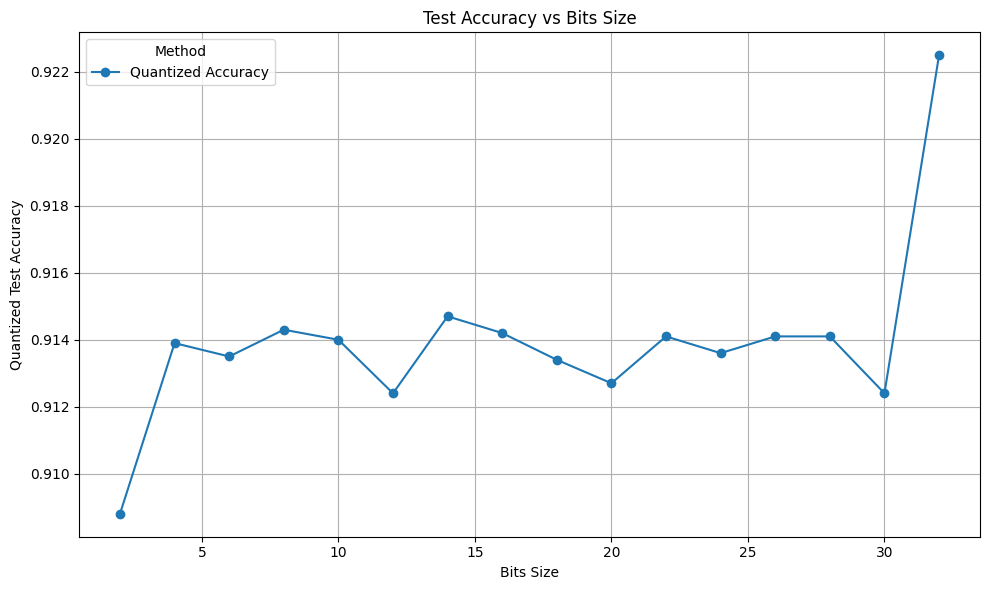

In [66]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")

# Add a row with original accuracy to both dataframes
new_row_quant = pd.DataFrame({"Bits": [32], "Quantized Test Accuracy": [0.9225]})
quant_teacher = pd.concat([quant_teacher, new_row_quant], ignore_index=True)

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Quantized Test Accuracy"], marker='o', label="Quantized Accuracy")

# Add labels and title
plt.title("Test Accuracy vs Bits Size")
plt.xlabel("Bits Size")
plt.ylabel("Quantized Test Accuracy")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig('images/teacher_quant_acc.png')

# Show the plot
plt.show()

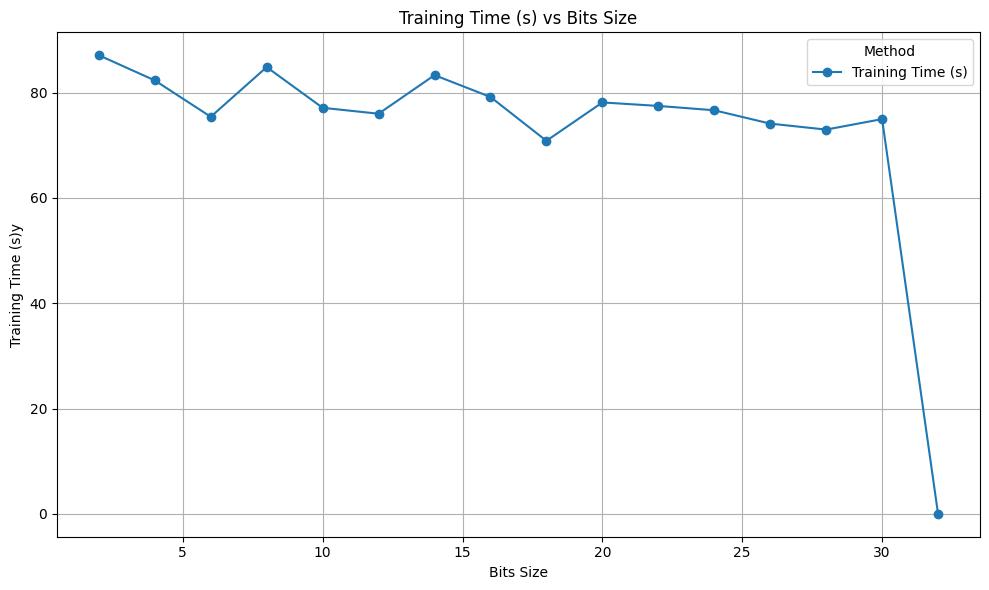

In [67]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")

# Add a row with original accuracy to both dataframes
new_row_quant = pd.DataFrame({"Bits": [32], "Training Time (s)": [0]})
quant_teacher = pd.concat([quant_teacher, new_row_quant], ignore_index=True)

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Training Time (s)"], marker='o', label="Training Time (s)")

# Add labels and title
plt.title("Training Time (s) vs Bits Size")
plt.xlabel("Bits Size")
plt.ylabel("Training Time (s)y")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig('images/teacher_quant_time.png')

# Show the plot
plt.show()

## Student Network

#### Without KD 

In [73]:
num_epochs = 20
print_every = 100
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [0.0] # only use label for training
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill_nokd = {}
pruning_factor = 0

# CSV file setup
csv_file = checkpoints_path_student_nokd + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
    student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(student_net)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill_nokd[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(
            teacher_net, student_net, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=False,
            checkpoint_save_path = checkpoints_path_student_nokd
        )

    training_time = time.time() - start_time

    # Final model save
    final_save_path = checkpoints_path_student_nokd + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill_nokd[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsT=4, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0
0 11173962 23520842
epoch: 0 validation accuracy: 0.110
[1,   100/  372] train loss: 1.450 train accuracy: 0.453
[1,   200/  372] train loss: 0.954 train accuracy: 0.703
[1,   300/  372] train loss: 0.751 train accuracy: 0.758
epoch: 1 validation accuracy: 0.742
[2,   100/  372] train loss: 0.602 train accuracy: 0.773
[2,   200/  372] train loss: 0.441 train accuracy: 0.852
[2,   300/  372] train loss: 0.438 train accuracy: 0.852
epoch: 2 validation accuracy: 0.826
[3,   100/  372] train loss: 0.491 train accuracy: 0.828
[3,   200/  372] train loss: 0.349 train accuracy: 0.883
[3,   300/  372] train loss: 0.368 train accuracy: 0.875
epoch: 3 validation accuracy: 0.862
[4,   100/  372] train loss: 0.361 train accuracy: 0.898
[4,   200/  372] train loss: 0.385 train accuracy: 0.867
[4,   300/  372] train loss: 0.267 train accuracy: 0.891

In [75]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_nokd/results_student_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [76]:
bits_list = range(2, 31, 2)  # 2, 4, ..., 30

def calculate_bit_size(model):
    """
    Calculate the effective bit size of a quantized model.
    
    Parameters:
        model: nn.Module
            The quantized neural network model.
    
    Returns:
        float: The average bit size across all layers.
    """
    total_bits = 0
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Calculate unique values and their count
            unique_values = torch.unique(param.data).cpu().numpy()
            num_unique_values = len(unique_values)
            
            # Calculate bit size for this layer
            layer_bits = np.ceil(np.log2(num_unique_values)) if num_unique_values > 1 else 1
            total_bits += layer_bits * param.numel()
            total_params += param.numel()
    
    # Return average bit size across all parameters
    return total_bits / total_params if total_params > 0 else 0

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=1.16,
        cnn_alphabet_scalar=1.16,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.8891, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 207.69it/s]

The quantization error of layer 0 is 46.06303405761719.


The relative quantization error of layer 0 is 0.13444562256336212.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 751.96it/s]


The quantization error of layer 1 is 70.73119354248047.
The relative quantization error of layer 1 is 0.13634201884269714.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2181.83it/s]


The quantization error of layer 2 is 63.91177749633789.
The relative quantization error of layer 2 is 0.27810558676719666.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1959.17it/s]


The quantization error of layer 3 is 130.11041259765625.
The relative quantization error of layer 3 is 0.2529365122318268.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1714.28it/s]


The quantization error of layer 4 is 68.27381134033203.
The relative quantization error of layer 4 is 0.3909069299697876.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1182.75it/s]


The quantization error of layer 5 is 262.6944580078125.
The relative quantization error of layer 5 is 0.3929980397224426.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2493.51it/s]


The quantization error of layer 6 is 53.73585510253906.
The relative quantization error of layer 6 is 0.34700435400009155.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 258.05it/s]


The quantization error of layer 7 is 350.3122253417969.
The relative quantization error of layer 7 is 0.45527133345603943.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2488.12it/s]


The quantization error of layer 8 is 90.69682312011719.
The relative quantization error of layer 8 is 0.38430410623550415.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2461.53it/s]


The quantization error of layer 9 is 42.40264892578125.
The relative quantization error of layer 9 is 0.470932275056839.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1955.86it/s]


The quantization error of layer 10 is 141.40061950683594.
The relative quantization error of layer 10 is 0.39148521423339844.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2789.34it/s]


The quantization error of layer 11 is 31.18891143798828.
The relative quantization error of layer 11 is 0.26742658019065857.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 615.38it/s]


The quantization error of layer 12 is 136.4730987548828.
The relative quantization error of layer 12 is 0.6073117852210999.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2636.15it/s]


The quantization error of layer 13 is 36.753883361816406.
The relative quantization error of layer 13 is 0.19757497310638428.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2853.71it/s]


The quantization error of layer 14 is 14.36873722076416.
The relative quantization error of layer 14 is 0.24802115559577942.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2643.53it/s]


The quantization error of layer 15 is 52.117347717285156.
The relative quantization error of layer 15 is 0.2108452320098877.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2844.44it/s]


The quantization error of layer 16 is 8.529401779174805.
The relative quantization error of layer 16 is 0.1359567791223526.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.70it/s]


The quantization error of layer 17 is 116.2540054321289.
The relative quantization error of layer 17 is 0.6928878426551819.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2585.80it/s]


The quantization error of layer 18 is 16.423301696777344.
The relative quantization error of layer 18 is 0.09377649426460266.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2385.06it/s]


The quantization error of layer 19 is 7.337141036987305.
The relative quantization error of layer 19 is 0.2477860301733017.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2876.41it/s]

The quantization error of layer 20 is 129.11752319335938.


The relative quantization error of layer 20 is 0.7728695869445801.

Bits 2, Effective Quantized Bit Size: 3.0045257000158045
Bits 2, Quantized Test Accuracy: 0.2641
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 278.35it/s]

The quantization error of layer 0 is 10.907515525817871.
The relative quantization error of layer 0 is 0.032099418342113495.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 815.87it/s]


The quantization error of layer 1 is 20.867666244506836.
The relative quantization error of layer 1 is 0.04030719771981239.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2079.40it/s]


The quantization error of layer 2 is 19.107864379882812.
The relative quantization error of layer 2 is 0.08286567032337189.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1870.13it/s]


The quantization error of layer 3 is 42.81741714477539.
The relative quantization error of layer 3 is 0.08383191376924515.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1882.36it/s]


The quantization error of layer 4 is 24.088756561279297.
The relative quantization error of layer 4 is 0.137722909450531.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1569.48it/s]


The quantization error of layer 5 is 83.82260131835938.
The relative quantization error of layer 5 is 0.12627534568309784.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2198.47it/s]


The quantization error of layer 6 is 17.125152587890625.
The relative quantization error of layer 6 is 0.10940610617399216.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 244.27it/s]


The quantization error of layer 7 is 143.886962890625.
The relative quantization error of layer 7 is 0.18770121037960052.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2685.50it/s]


The quantization error of layer 8 is 31.016698837280273.
The relative quantization error of layer 8 is 0.13268712162971497.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2308.81it/s]


The quantization error of layer 9 is 15.550689697265625.
The relative quantization error of layer 9 is 0.17380493879318237.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1969.23it/s]


The quantization error of layer 10 is 53.449974060058594.
The relative quantization error of layer 10 is 0.14766256511211395.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2698.06it/s]


The quantization error of layer 11 is 11.435561180114746.
The relative quantization error of layer 11 is 0.09757309406995773.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 554.11it/s]


The quantization error of layer 12 is 54.45892333984375.
The relative quantization error of layer 12 is 0.24352864921092987.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2858.56it/s]


The quantization error of layer 13 is 14.547122955322266.
The relative quantization error of layer 13 is 0.07996991276741028.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2765.90it/s]


The quantization error of layer 14 is 6.613264083862305.
The relative quantization error of layer 14 is 0.11355321109294891.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2651.32it/s]


The quantization error of layer 15 is 25.845062255859375.
The relative quantization error of layer 15 is 0.1061660572886467.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2776.75it/s]


The quantization error of layer 16 is 3.74824857711792.
The relative quantization error of layer 16 is 0.06166486442089081.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1242.73it/s]


The quantization error of layer 17 is 55.680667877197266.
The relative quantization error of layer 17 is 0.33338651061058044.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2982.50it/s]


The quantization error of layer 18 is 10.57098388671875.
The relative quantization error of layer 18 is 0.059766363352537155.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2491.94it/s]


The quantization error of layer 19 is 5.741366386413574.
The relative quantization error of layer 19 is 0.20296555757522583.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2723.42it/s]


The quantization error of layer 20 is 81.53309631347656.
The relative quantization error of layer 20 is 0.4892757534980774.

Bits 4, Effective Quantized Bit Size: 5.002805629730976
Bits 4, Quantized Test Accuracy: 0.7248
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 241.07it/s]

The quantization error of layer 0 is 2.9264535903930664.
The relative quantization error of layer 0 is 0.008324528113007545.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1017.67it/s]


The quantization error of layer 1 is 8.835186958312988.
The relative quantization error of layer 1 is 0.017066774889826775.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1972.64it/s]


The quantization error of layer 2 is 7.309185028076172.
The relative quantization error of layer 2 is 0.03187653049826622.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2086.92it/s]


The quantization error of layer 3 is 24.359424591064453.
The relative quantization error of layer 3 is 0.04728538542985916.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1900.99it/s]


The quantization error of layer 4 is 14.64567756652832.
The relative quantization error of layer 4 is 0.08299051225185394.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1220.34it/s]


The quantization error of layer 5 is 40.512603759765625.
The relative quantization error of layer 5 is 0.06137887388467789.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2630.08it/s]


The quantization error of layer 6 is 7.485381603240967.
The relative quantization error of layer 6 is 0.04790734127163887.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 247.11it/s]


The quantization error of layer 7 is 109.72518157958984.
The relative quantization error of layer 7 is 0.14261062443256378.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2317.92it/s]


The quantization error of layer 8 is 17.351282119750977.
The relative quantization error of layer 8 is 0.07315518707036972.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2228.24it/s]


The quantization error of layer 9 is 9.022244453430176.
The relative quantization error of layer 9 is 0.10049954056739807.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1894.74it/s]


The quantization error of layer 10 is 32.39591598510742.
The relative quantization error of layer 10 is 0.09059646725654602.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2830.47it/s]


The quantization error of layer 11 is 6.860140323638916.
The relative quantization error of layer 11 is 0.05881142243742943.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 600.93it/s]


The quantization error of layer 12 is 34.200592041015625.
The relative quantization error of layer 12 is 0.15274490416049957.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2654.39it/s]


The quantization error of layer 13 is 8.252365112304688.
The relative quantization error of layer 13 is 0.045179326087236404.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2493.52it/s]


The quantization error of layer 14 is 4.299185276031494.
The relative quantization error of layer 14 is 0.07303006947040558.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2782.61it/s]


The quantization error of layer 15 is 16.519628524780273.
The relative quantization error of layer 15 is 0.06721989810466766.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2628.11it/s]


The quantization error of layer 16 is 2.4573869705200195.
The relative quantization error of layer 16 is 0.03857508674263954.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1236.71it/s]


The quantization error of layer 17 is 36.41985321044922.
The relative quantization error of layer 17 is 0.21784788370132446.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2961.35it/s]


The quantization error of layer 18 is 8.186391830444336.
The relative quantization error of layer 18 is 0.04702043533325195.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2446.45it/s]


The quantization error of layer 19 is 5.027994155883789.
The relative quantization error of layer 19 is 0.17175798118114471.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2572.87it/s]


The quantization error of layer 20 is 62.08434295654297.
The relative quantization error of layer 20 is 0.363545298576355.

Bits 6, Effective Quantized Bit Size: 6.994332717437199
Bits 6, Quantized Test Accuracy: 0.8156
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 267.32it/s]

The quantization error of layer 0 is 0.7251628637313843.
The relative quantization error of layer 0 is 0.0020957766100764275.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2285.68it/s]


The quantization error of layer 1 is 7.720099925994873.
The relative quantization error of layer 1 is 0.014888903126120567.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2276.68it/s]


The quantization error of layer 2 is 5.857051372528076.
The relative quantization error of layer 2 is 0.02552594244480133.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1714.32it/s]


The quantization error of layer 3 is 24.120756149291992.
The relative quantization error of layer 3 is 0.04678751900792122.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1609.06it/s]


The quantization error of layer 4 is 14.356759071350098.
The relative quantization error of layer 4 is 0.08191906660795212.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1122.81it/s]


The quantization error of layer 5 is 35.18549728393555.
The relative quantization error of layer 5 is 0.052897438406944275.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2461.53it/s]


The quantization error of layer 6 is 6.442615032196045.
The relative quantization error of layer 6 is 0.0410853736102581.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 266.67it/s]


The quantization error of layer 7 is 107.23285675048828.
The relative quantization error of layer 7 is 0.13914407789707184.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2367.53it/s]


The quantization error of layer 8 is 15.772095680236816.
The relative quantization error of layer 8 is 0.06655303388834.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2194.28it/s]


The quantization error of layer 9 is 9.404073715209961.
The relative quantization error of layer 9 is 0.10658195614814758.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1691.59it/s]


The quantization error of layer 10 is 35.09798812866211.
The relative quantization error of layer 10 is 0.0973074734210968.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2591.31it/s]


The quantization error of layer 11 is 7.457761764526367.
The relative quantization error of layer 11 is 0.0634961724281311.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 496.14it/s]


The quantization error of layer 12 is 36.466495513916016.
The relative quantization error of layer 12 is 0.16254976391792297.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2498.88it/s]


The quantization error of layer 13 is 9.206914901733398.
The relative quantization error of layer 13 is 0.04914138838648796.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2739.57it/s]


The quantization error of layer 14 is 4.043501853942871.
The relative quantization error of layer 14 is 0.07015509903430939.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2450.82it/s]


The quantization error of layer 15 is 16.79196548461914.
The relative quantization error of layer 15 is 0.06853615492582321.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2423.99it/s]


The quantization error of layer 16 is 2.4264566898345947.
The relative quantization error of layer 16 is 0.038000110536813736.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1398.91it/s]


The quantization error of layer 17 is 36.21830749511719.
The relative quantization error of layer 17 is 0.2147519439458847.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2723.97it/s]


The quantization error of layer 18 is 8.02423095703125.
The relative quantization error of layer 18 is 0.04567204788327217.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2500.27it/s]


The quantization error of layer 19 is 5.313257694244385.
The relative quantization error of layer 19 is 0.17611922323703766.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2585.88it/s]


The quantization error of layer 20 is 60.4703483581543.
The relative quantization error of layer 20 is 0.34778615832328796.

Bits 8, Effective Quantized Bit Size: 8.845252919242073
Bits 8, Quantized Test Accuracy: 0.8236
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 284.21it/s]

The quantization error of layer 0 is 0.16613030433654785.
The relative quantization error of layer 0 is 0.0004879382613580674.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1852.07it/s]


The quantization error of layer 1 is 7.225368976593018.
The relative quantization error of layer 1 is 0.013956745155155659.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2117.65it/s]


The quantization error of layer 2 is 5.8083014488220215.
The relative quantization error of layer 2 is 0.025370080024003983.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1993.08it/s]


The quantization error of layer 3 is 22.97593116760254.
The relative quantization error of layer 3 is 0.04465687274932861.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1714.29it/s]


The quantization error of layer 4 is 14.257433891296387.
The relative quantization error of layer 4 is 0.08031469583511353.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1285.80it/s]


The quantization error of layer 5 is 34.517173767089844.
The relative quantization error of layer 5 is 0.051912762224674225.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2276.68it/s]


The quantization error of layer 6 is 6.355752468109131.
The relative quantization error of layer 6 is 0.04096218943595886.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 261.18it/s]


The quantization error of layer 7 is 107.43145751953125.
The relative quantization error of layer 7 is 0.13918694853782654.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2477.42it/s]


The quantization error of layer 8 is 16.064302444458008.
The relative quantization error of layer 8 is 0.06770884245634079.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2219.65it/s]


The quantization error of layer 9 is 7.716989040374756.
The relative quantization error of layer 9 is 0.08588173985481262.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.46it/s]


The quantization error of layer 10 is 29.60831069946289.
The relative quantization error of layer 10 is 0.08222421258687973.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2571.43it/s]


The quantization error of layer 11 is 6.1221923828125.
The relative quantization error of layer 11 is 0.051974955946207047.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 684.49it/s]


The quantization error of layer 12 is 30.48602867126465.
The relative quantization error of layer 12 is 0.1355680376291275.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2880.13it/s]


The quantization error of layer 13 is 7.548954963684082.
The relative quantization error of layer 13 is 0.04075966030359268.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2779.14it/s]


The quantization error of layer 14 is 3.4822921752929688.
The relative quantization error of layer 14 is 0.06024067848920822.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2194.28it/s]


The quantization error of layer 15 is 14.868790626525879.
The relative quantization error of layer 15 is 0.060209184885025024.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2390.04it/s]


The quantization error of layer 16 is 2.1739468574523926.
The relative quantization error of layer 16 is 0.03530916944146156.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1179.71it/s]


The quantization error of layer 17 is 32.494422912597656.
The relative quantization error of layer 17 is 0.20146024227142334.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2833.82it/s]


The quantization error of layer 18 is 7.253141403198242.
The relative quantization error of layer 18 is 0.04098116606473923.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2701.05it/s]


The quantization error of layer 19 is 5.139949321746826.
The relative quantization error of layer 19 is 0.17623458802700043.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1954.19it/s]


The quantization error of layer 20 is 56.21334457397461.
The relative quantization error of layer 20 is 0.3282751441001892.

Bits 10, Effective Quantized Bit Size: 10.63193234414078
Bits 10, Quantized Test Accuracy: 0.8306
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 281.25it/s]

The quantization error of layer 0 is 0.04827012121677399.
The relative quantization error of layer 0 is 0.0001318274880759418.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 789.01it/s]


The quantization error of layer 1 is 7.501816272735596.
The relative quantization error of layer 1 is 0.014454827643930912.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1959.18it/s]


The quantization error of layer 2 is 5.910979270935059.
The relative quantization error of layer 2 is 0.02574019879102707.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1613.44it/s]


The quantization error of layer 3 is 23.0949649810791.
The relative quantization error of layer 3 is 0.04492722451686859.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1429.38it/s]


The quantization error of layer 4 is 13.896195411682129.
The relative quantization error of layer 4 is 0.0789334699511528.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1285.70it/s]


The quantization error of layer 5 is 35.1518440246582.
The relative quantization error of layer 5 is 0.05258820950984955.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2294.82it/s]


The quantization error of layer 6 is 6.708526611328125.
The relative quantization error of layer 6 is 0.043287377804517746.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 254.98it/s]


The quantization error of layer 7 is 107.48839569091797.
The relative quantization error of layer 7 is 0.13955704867839813.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2691.67it/s]


The quantization error of layer 8 is 15.63642406463623.
The relative quantization error of layer 8 is 0.0668933093547821.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2241.07it/s]


The quantization error of layer 9 is 7.099923610687256.
The relative quantization error of layer 9 is 0.08053142577409744.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1979.38it/s]


The quantization error of layer 10 is 30.51600456237793.
The relative quantization error of layer 10 is 0.08440626412630081.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2612.24it/s]


The quantization error of layer 11 is 6.2261061668396.
The relative quantization error of layer 11 is 0.053032804280519485.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 653.05it/s]


The quantization error of layer 12 is 32.58631134033203.
The relative quantization error of layer 12 is 0.14528806507587433.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2733.09it/s]


The quantization error of layer 13 is 7.688253879547119.
The relative quantization error of layer 13 is 0.04172414541244507.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2550.04it/s]


The quantization error of layer 14 is 3.4503021240234375.
The relative quantization error of layer 14 is 0.059932123869657516.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2702.61it/s]


The quantization error of layer 15 is 15.229037284851074.
The relative quantization error of layer 15 is 0.0624409094452858.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2548.67it/s]


The quantization error of layer 16 is 2.3556363582611084.
The relative quantization error of layer 16 is 0.03701634705066681.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1391.30it/s]


The quantization error of layer 17 is 34.62229919433594.
The relative quantization error of layer 17 is 0.21030059456825256.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2489.46it/s]


The quantization error of layer 18 is 7.651524066925049.
The relative quantization error of layer 18 is 0.04294152185320854.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2754.38it/s]


The quantization error of layer 19 is 4.816863059997559.
The relative quantization error of layer 19 is 0.1688414216041565.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2039.84it/s]


The quantization error of layer 20 is 57.38375473022461.
The relative quantization error of layer 20 is 0.34517499804496765.

Bits 12, Effective Quantized Bit Size: 12.626025397258376
Bits 12, Quantized Test Accuracy: 0.8204
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 290.33it/s]

The quantization error of layer 0 is 0.011804155074059963.
The relative quantization error of layer 0 is 3.228008790756576e-05.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2232.56it/s]


The quantization error of layer 1 is 7.391330718994141.
The relative quantization error of layer 1 is 0.014232710935175419.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2223.95it/s]


The quantization error of layer 2 is 5.782114028930664.
The relative quantization error of layer 2 is 0.02535523660480976.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1387.95it/s]


The quantization error of layer 3 is 23.15887451171875.
The relative quantization error of layer 3 is 0.04509754851460457.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1858.06it/s]


The quantization error of layer 4 is 14.654540061950684.
The relative quantization error of layer 4 is 0.08316217362880707.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1230.77it/s]


The quantization error of layer 5 is 35.62026596069336.
The relative quantization error of layer 5 is 0.05341584235429764.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1916.80it/s]


The quantization error of layer 6 is 6.607958793640137.
The relative quantization error of layer 6 is 0.042287953197956085.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 265.56it/s]


The quantization error of layer 7 is 107.34608459472656.
The relative quantization error of layer 7 is 0.13993500173091888.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2435.68it/s]


The quantization error of layer 8 is 15.963472366333008.
The relative quantization error of layer 8 is 0.06802570074796677.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2267.72it/s]


The quantization error of layer 9 is 7.238883018493652.
The relative quantization error of layer 9 is 0.08143467456102371.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1769.27it/s]


The quantization error of layer 10 is 29.59270477294922.
The relative quantization error of layer 10 is 0.08221542835235596.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2301.45it/s]


The quantization error of layer 11 is 6.080173969268799.
The relative quantization error of layer 11 is 0.051771048456430435.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 498.05it/s]


The quantization error of layer 12 is 30.282411575317383.
The relative quantization error of layer 12 is 0.13509047031402588.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2574.30it/s]


The quantization error of layer 13 is 7.393630504608154.
The relative quantization error of layer 13 is 0.04031803086400032.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2526.32it/s]


The quantization error of layer 14 is 3.4819142818450928.
The relative quantization error of layer 14 is 0.06021025404334068.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2701.05it/s]


The quantization error of layer 15 is 14.80072021484375.
The relative quantization error of layer 15 is 0.06058865040540695.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2530.47it/s]


The quantization error of layer 16 is 2.1979098320007324.
The relative quantization error of layer 16 is 0.03475302830338478.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1219.05it/s]


The quantization error of layer 17 is 32.54218673706055.
The relative quantization error of layer 17 is 0.1967732310295105.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2885.11it/s]


The quantization error of layer 18 is 7.123910427093506.
The relative quantization error of layer 18 is 0.04112643003463745.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2588.53it/s]


The quantization error of layer 19 is 5.145427227020264.
The relative quantization error of layer 19 is 0.1751132756471634.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2169.50it/s]


The quantization error of layer 20 is 56.674644470214844.
The relative quantization error of layer 20 is 0.3323054313659668.

Bits 14, Effective Quantized Bit Size: 14.181367003037955
Bits 14, Quantized Test Accuracy: 0.8267
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 300.00it/s]

The quantization error of layer 0 is 0.002848756965249777.
The relative quantization error of layer 0 is 8.275263098767027e-06.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 909.95it/s] 


The quantization error of layer 1 is 7.474122524261475.
The relative quantization error of layer 1 is 0.014416230842471123.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1846.15it/s]


The quantization error of layer 2 is 5.884037971496582.
The relative quantization error of layer 2 is 0.025601085275411606.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1636.37it/s]


The quantization error of layer 3 is 23.00116539001465.
The relative quantization error of layer 3 is 0.04497021436691284.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2232.56it/s]


The quantization error of layer 4 is 14.125391960144043.
The relative quantization error of layer 4 is 0.08106588572263718.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1864.07it/s]


The quantization error of layer 5 is 34.67897415161133.
The relative quantization error of layer 5 is 0.05213937908411026.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2624.15it/s]


The quantization error of layer 6 is 6.424779891967773.
The relative quantization error of layer 6 is 0.04154525697231293.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.38it/s]


The quantization error of layer 7 is 106.71249389648438.
The relative quantization error of layer 7 is 0.13820858299732208.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2577.11it/s]


The quantization error of layer 8 is 15.850330352783203.
The relative quantization error of layer 8 is 0.06771346926689148.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1802.82it/s]


The quantization error of layer 9 is 7.404690265655518.
The relative quantization error of layer 9 is 0.08339850604534149.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1849.12it/s]


The quantization error of layer 10 is 28.8309383392334.
The relative quantization error of layer 10 is 0.08030914515256882.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2713.78it/s]


The quantization error of layer 11 is 5.694540023803711.
The relative quantization error of layer 11 is 0.04832078143954277.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 566.36it/s]


The quantization error of layer 12 is 29.981294631958008.
The relative quantization error of layer 12 is 0.13335327804088593.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2490.81it/s]


The quantization error of layer 13 is 7.180540084838867.
The relative quantization error of layer 13 is 0.03864266350865364.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2299.40it/s]


The quantization error of layer 14 is 3.4453725814819336.
The relative quantization error of layer 14 is 0.05866321921348572.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2723.01it/s]


The quantization error of layer 15 is 14.598088264465332.
The relative quantization error of layer 15 is 0.05945385619997978.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2571.19it/s]


The quantization error of layer 16 is 2.1087350845336914.
The relative quantization error of layer 16 is 0.033992279320955276.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1015.75it/s]


The quantization error of layer 17 is 31.704282760620117.
The relative quantization error of layer 17 is 0.19033192098140717.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2598.93it/s]


The quantization error of layer 18 is 7.101626873016357.
The relative quantization error of layer 18 is 0.04075288027524948.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2525.64it/s]


The quantization error of layer 19 is 4.905699253082275.
The relative quantization error of layer 19 is 0.16956643760204315.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2560.01it/s]


The quantization error of layer 20 is 58.42378616333008.
The relative quantization error of layer 20 is 0.34449368715286255.

Bits 16, Effective Quantized Bit Size: 15.825875906862759
Bits 16, Quantized Test Accuracy: 0.825
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 262.13it/s]

The quantization error of layer 0 is 0.0006881784065626562.
The relative quantization error of layer 0 is 2.076524651783984e-06.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2149.54it/s]


The quantization error of layer 1 is 7.2052812576293945.
The relative quantization error of layer 1 is 0.013886708766222.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2223.94it/s]


The quantization error of layer 2 is 5.770081996917725.
The relative quantization error of layer 2 is 0.02532724104821682.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1613.60it/s]


The quantization error of layer 3 is 23.479307174682617.
The relative quantization error of layer 3 is 0.04571361467242241.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1309.08it/s]


The quantization error of layer 4 is 14.280120849609375.
The relative quantization error of layer 4 is 0.08113584667444229.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1387.83it/s]


The quantization error of layer 5 is 34.83104705810547.
The relative quantization error of layer 5 is 0.052669707685709.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2445.85it/s]


The quantization error of layer 6 is 6.335319519042969.
The relative quantization error of layer 6 is 0.04014777019619942.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 259.11it/s]


The quantization error of layer 7 is 107.9742202758789.
The relative quantization error of layer 7 is 0.13968022167682648.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2660.50it/s]


The quantization error of layer 8 is 15.796844482421875.
The relative quantization error of layer 8 is 0.06787808984518051.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2254.22it/s]


The quantization error of layer 9 is 7.71078634262085.
The relative quantization error of layer 9 is 0.08574232459068298.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1935.63it/s]


The quantization error of layer 10 is 29.538923263549805.
The relative quantization error of layer 10 is 0.0813651978969574.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2688.39it/s]


The quantization error of layer 11 is 6.130458831787109.
The relative quantization error of layer 11 is 0.051438815891742706.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 640.00it/s]


The quantization error of layer 12 is 31.275672912597656.
The relative quantization error of layer 12 is 0.13963767886161804.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2410.04it/s]


The quantization error of layer 13 is 7.50826358795166.
The relative quantization error of layer 13 is 0.0400107316672802.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2880.00it/s]


The quantization error of layer 14 is 3.6619412899017334.
The relative quantization error of layer 14 is 0.06168162077665329.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2230.40it/s]


The quantization error of layer 15 is 15.14067554473877.
The relative quantization error of layer 15 is 0.061706770211458206.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2728.24it/s]


The quantization error of layer 16 is 2.2732632160186768.
The relative quantization error of layer 16 is 0.03524351119995117.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1236.77it/s]


The quantization error of layer 17 is 33.46623229980469.
The relative quantization error of layer 17 is 0.1991564929485321.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2675.88it/s]


The quantization error of layer 18 is 7.20965051651001.
The relative quantization error of layer 18 is 0.04129885137081146.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2981.08it/s]


The quantization error of layer 19 is 5.000382423400879.
The relative quantization error of layer 19 is 0.1741633415222168.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2497.58it/s]


The quantization error of layer 20 is 56.408958435058594.
The relative quantization error of layer 20 is 0.3358711004257202.

Bits 18, Effective Quantized Bit Size: 17.554970027641048
Bits 18, Quantized Test Accuracy: 0.8189
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 275.51it/s]

The quantization error of layer 0 is 0.00018191125127486885.
The relative quantization error of layer 0 is 5.372333475861524e-07.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1719.40it/s]


The quantization error of layer 1 is 7.372864723205566.
The relative quantization error of layer 1 is 0.014238744042813778.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2350.72it/s]


The quantization error of layer 2 is 5.991860866546631.
The relative quantization error of layer 2 is 0.02608454041182995.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1613.45it/s]


The quantization error of layer 3 is 22.769784927368164.
The relative quantization error of layer 3 is 0.04442078247666359.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1465.65it/s]


The quantization error of layer 4 is 14.786624908447266.
The relative quantization error of layer 4 is 0.08393969386816025.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1358.49it/s]


The quantization error of layer 5 is 36.11402130126953.
The relative quantization error of layer 5 is 0.05387785658240318.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2336.71it/s]


The quantization error of layer 6 is 6.508045673370361.
The relative quantization error of layer 6 is 0.04198634997010231.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 267.78it/s]


The quantization error of layer 7 is 108.83590698242188.
The relative quantization error of layer 7 is 0.14101910591125488.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2565.58it/s]


The quantization error of layer 8 is 15.773421287536621.
The relative quantization error of layer 8 is 0.06681505590677261.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2360.65it/s]


The quantization error of layer 9 is 7.597981929779053.
The relative quantization error of layer 9 is 0.08435646444559097.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.05it/s]


The quantization error of layer 10 is 29.64502716064453.
The relative quantization error of layer 10 is 0.08297660946846008.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2053.48it/s]


The quantization error of layer 11 is 6.2555155754089355.
The relative quantization error of layer 11 is 0.05348405987024307.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 895.09it/s]

The quantization error of layer 12 is 30.848222732543945.
The relative quantization error of layer 12 is 0.1371377408504486.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2927.56it/s]


The quantization error of layer 13 is 7.6359734535217285.
The relative quantization error of layer 13 is 0.04109959304332733.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2380.17it/s]


The quantization error of layer 14 is 3.273134708404541.
The relative quantization error of layer 14 is 0.0565190315246582.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2355.83it/s]


The quantization error of layer 15 is 15.204527854919434.
The relative quantization error of layer 15 is 0.062158435583114624.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1900.50it/s]


The quantization error of layer 16 is 2.3634583950042725.
The relative quantization error of layer 16 is 0.03653642162680626.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1534.26it/s]


The quantization error of layer 17 is 33.284175872802734.
The relative quantization error of layer 17 is 0.19948814809322357.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3148.98it/s]


The quantization error of layer 18 is 7.832222938537598.
The relative quantization error of layer 18 is 0.04477502033114433.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2731.08it/s]


The quantization error of layer 19 is 5.191840171813965.
The relative quantization error of layer 19 is 0.17548947036266327.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3148.25it/s]

The quantization error of layer 20 is 54.35201644897461.
The relative quantization error of layer 20 is 0.3228743076324463.



Bits 20, Effective Quantized Bit Size: 19.095648973927062
Bits 20, Quantized Test Accuracy: 0.8221
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 382.36it/s]

The quantization error of layer 0 is 5.0069877033820376e-05.
The relative quantization error of layer 0 is 1.4889306498844235e-07.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1135.09it/s]


The quantization error of layer 1 is 7.237751007080078.
The relative quantization error of layer 1 is 0.01396206859499216.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2306.30it/s]


The quantization error of layer 2 is 5.865598201751709.
The relative quantization error of layer 2 is 0.025472497567534447.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2391.99it/s]


The quantization error of layer 3 is 23.443090438842773.
The relative quantization error of layer 3 is 0.04556000605225563.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2366.54it/s]


The quantization error of layer 4 is 14.789254188537598.
The relative quantization error of layer 4 is 0.0852188840508461.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1576.48it/s]


The quantization error of layer 5 is 33.768409729003906.
The relative quantization error of layer 5 is 0.05052933096885681.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2812.36it/s]


The quantization error of layer 6 is 6.287575721740723.
The relative quantization error of layer 6 is 0.04062667116522789.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 297.41it/s]


The quantization error of layer 7 is 106.92469787597656.
The relative quantization error of layer 7 is 0.13835327327251434.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3141.58it/s]


The quantization error of layer 8 is 15.586827278137207.
The relative quantization error of layer 8 is 0.0660892203450203.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2879.80it/s]


The quantization error of layer 9 is 9.061131477355957.
The relative quantization error of layer 9 is 0.10091344267129898.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2056.50it/s]


The quantization error of layer 10 is 33.28255081176758.
The relative quantization error of layer 10 is 0.09327811747789383.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3075.26it/s]


The quantization error of layer 11 is 7.091591835021973.
The relative quantization error of layer 11 is 0.05985671281814575.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 711.10it/s]


The quantization error of layer 12 is 33.960540771484375.
The relative quantization error of layer 12 is 0.15205109119415283.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3301.86it/s]


The quantization error of layer 13 is 8.307516098022461.
The relative quantization error of layer 13 is 0.046042606234550476.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3009.54it/s]


The quantization error of layer 14 is 3.850506067276001.
The relative quantization error of layer 14 is 0.06559599936008453.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2880.70it/s]


The quantization error of layer 15 is 15.882102012634277.
The relative quantization error of layer 15 is 0.06461026519536972.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2777.26it/s]


The quantization error of layer 16 is 2.2075297832489014.
The relative quantization error of layer 16 is 0.03518372029066086.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1445.02it/s]


The quantization error of layer 17 is 34.78226852416992.
The relative quantization error of layer 17 is 0.20919343829154968.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3471.31it/s]


The quantization error of layer 18 is 8.071683883666992.
The relative quantization error of layer 18 is 0.045501384884119034.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3183.68it/s]


The quantization error of layer 19 is 5.218087673187256.
The relative quantization error of layer 19 is 0.17627286911010742.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3079.64it/s]

The quantization error of layer 20 is 58.19667434692383.
The relative quantization error of layer 20 is 0.3446282148361206.



Bits 22, Effective Quantized Bit Size: 20.197547834868242
Bits 22, Quantized Test Accuracy: 0.8201
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 335.09it/s]

The quantization error of layer 0 is 2.414725167909637e-05.
The relative quantization error of layer 0 is 7.15744761237147e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1348.65it/s]


The quantization error of layer 1 is 7.3805365562438965.
The relative quantization error of layer 1 is 0.014249470084905624.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2534.43it/s]


The quantization error of layer 2 is 5.669137477874756.
The relative quantization error of layer 2 is 0.02474210411310196.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2201.08it/s]


The quantization error of layer 3 is 23.718162536621094.
The relative quantization error of layer 3 is 0.04603893309831619.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2281.38it/s]


The quantization error of layer 4 is 14.559904098510742.
The relative quantization error of layer 4 is 0.08290564268827438.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.06it/s]


The quantization error of layer 5 is 35.08572769165039.
The relative quantization error of layer 5 is 0.05248181149363518.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2720.32it/s]


The quantization error of layer 6 is 6.662108421325684.
The relative quantization error of layer 6 is 0.04281596094369888.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 295.46it/s]


The quantization error of layer 7 is 107.99903869628906.
The relative quantization error of layer 7 is 0.13994641602039337.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2891.64it/s]


The quantization error of layer 8 is 15.828848838806152.
The relative quantization error of layer 8 is 0.06725092232227325.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2800.48it/s]


The quantization error of layer 9 is 7.541008472442627.
The relative quantization error of layer 9 is 0.08395966142416.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.20it/s]


The quantization error of layer 10 is 29.364673614501953.
The relative quantization error of layer 10 is 0.08112309128046036.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3094.22it/s]


The quantization error of layer 11 is 6.238152980804443.
The relative quantization error of layer 11 is 0.05249612405896187.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 725.83it/s]


The quantization error of layer 12 is 30.630725860595703.
The relative quantization error of layer 12 is 0.13686059415340424.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3161.43it/s]


The quantization error of layer 13 is 7.623269081115723.
The relative quantization error of layer 13 is 0.04118015617132187.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3059.64it/s]


The quantization error of layer 14 is 3.5460317134857178.
The relative quantization error of layer 14 is 0.06030753627419472.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2959.46it/s]


The quantization error of layer 15 is 14.605561256408691.
The relative quantization error of layer 15 is 0.059876449406147.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2829.06it/s]


The quantization error of layer 16 is 2.1458652019500732.
The relative quantization error of layer 16 is 0.03401356562972069.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1232.73it/s]


The quantization error of layer 17 is 32.59581756591797.
The relative quantization error of layer 17 is 0.1956717073917389.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3071.80it/s]


The quantization error of layer 18 is 7.088708877563477.
The relative quantization error of layer 18 is 0.04023861140012741.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2665.03it/s]


The quantization error of layer 19 is 4.850642204284668.
The relative quantization error of layer 19 is 0.1654990315437317.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3097.60it/s]

The quantization error of layer 20 is 51.645362854003906.
The relative quantization error of layer 20 is 0.3018400967121124.



Bits 24, Effective Quantized Bit Size: 20.38229734448712
Bits 24, Quantized Test Accuracy: 0.8388
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 303.38it/s]

The quantization error of layer 0 is 2.2668578822049312e-05.
The relative quantization error of layer 0 is 6.638577332296336e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2679.27it/s]


The quantization error of layer 1 is 7.30624532699585.
The relative quantization error of layer 1 is 0.01411267090588808.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2548.47it/s]


The quantization error of layer 2 is 5.800195217132568.
The relative quantization error of layer 2 is 0.025347474962472916.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2241.02it/s]


The quantization error of layer 3 is 23.145294189453125.
The relative quantization error of layer 3 is 0.04526440054178238.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2354.60it/s]


The quantization error of layer 4 is 14.274190902709961.
The relative quantization error of layer 4 is 0.08104582130908966.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1803.35it/s]


The quantization error of layer 5 is 35.54157257080078.
The relative quantization error of layer 5 is 0.053670063614845276.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2966.14it/s]


The quantization error of layer 6 is 6.456416130065918.
The relative quantization error of layer 6 is 0.041886087507009506.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 297.68it/s]


The quantization error of layer 7 is 107.19373321533203.
The relative quantization error of layer 7 is 0.13872838020324707.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2963.55it/s]


The quantization error of layer 8 is 15.528190612792969.
The relative quantization error of layer 8 is 0.06546734273433685.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2664.13it/s]


The quantization error of layer 9 is 8.265650749206543.
The relative quantization error of layer 9 is 0.09313070774078369.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2127.18it/s]


The quantization error of layer 10 is 31.26369285583496.
The relative quantization error of layer 10 is 0.08658749610185623.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2962.01it/s]


The quantization error of layer 11 is 6.518939018249512.
The relative quantization error of layer 11 is 0.05461070314049721.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 738.74it/s]


The quantization error of layer 12 is 32.22367858886719.
The relative quantization error of layer 12 is 0.14333784580230713.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3025.75it/s]


The quantization error of layer 13 is 7.904006004333496.
The relative quantization error of layer 13 is 0.04326840117573738.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2835.08it/s]


The quantization error of layer 14 is 3.9707698822021484.
The relative quantization error of layer 14 is 0.06766404211521149.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2689.70it/s]


The quantization error of layer 15 is 16.220645904541016.
The relative quantization error of layer 15 is 0.0667913556098938.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3101.25it/s]


The quantization error of layer 16 is 2.497133493423462.
The relative quantization error of layer 16 is 0.039072565734386444.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1745.12it/s]

The quantization error of layer 17 is 35.078819274902344.
The relative quantization error of layer 17 is 0.21180355548858643.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3345.67it/s]


The quantization error of layer 18 is 7.684393882751465.
The relative quantization error of layer 18 is 0.04446300491690636.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3100.65it/s]


The quantization error of layer 19 is 5.242825508117676.
The relative quantization error of layer 19 is 0.18037284910678864.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3160.71it/s]

The quantization error of layer 20 is 59.303829193115234.
The relative quantization error of layer 20 is 0.36064717173576355.



Bits 26, Effective Quantized Bit Size: 21.121295382962643
Bits 26, Quantized Test Accuracy: 0.808
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 305.66it/s]

The quantization error of layer 0 is 2.1047490008641034e-05.
The relative quantization error of layer 0 is 6.124947304897432e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1170.29it/s]


The quantization error of layer 1 is 7.329297065734863.
The relative quantization error of layer 1 is 0.014170510694384575.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2508.74it/s]


The quantization error of layer 2 is 5.874244213104248.
The relative quantization error of layer 2 is 0.025635432451963425.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2248.26it/s]


The quantization error of layer 3 is 23.284137725830078.
The relative quantization error of layer 3 is 0.04538194090127945.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2304.58it/s]


The quantization error of layer 4 is 13.807764053344727.
The relative quantization error of layer 4 is 0.0787927433848381.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1804.80it/s]


The quantization error of layer 5 is 35.973594665527344.
The relative quantization error of layer 5 is 0.05395066365599632.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2901.41it/s]


The quantization error of layer 6 is 6.643779754638672.
The relative quantization error of layer 6 is 0.04236162081360817.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 321.41it/s]


The quantization error of layer 7 is 107.35588073730469.
The relative quantization error of layer 7 is 0.1391434669494629.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3104.81it/s]


The quantization error of layer 8 is 16.115556716918945.
The relative quantization error of layer 8 is 0.06882262974977493.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3014.01it/s]


The quantization error of layer 9 is 7.432402610778809.
The relative quantization error of layer 9 is 0.08309219777584076.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2256.48it/s]


The quantization error of layer 10 is 30.860265731811523.
The relative quantization error of layer 10 is 0.08562099188566208.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3079.80it/s]


The quantization error of layer 11 is 6.2398600578308105.
The relative quantization error of layer 11 is 0.05364402011036873.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 769.35it/s]

The quantization error of layer 12 is 31.481996536254883.


The relative quantization error of layer 12 is 0.14041957259178162.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2969.18it/s]


The quantization error of layer 13 is 7.693965911865234.
The relative quantization error of layer 13 is 0.041853610426187515.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2859.99it/s]


The quantization error of layer 14 is 3.5698530673980713.
The relative quantization error of layer 14 is 0.061238013207912445.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2936.70it/s]


The quantization error of layer 15 is 14.535195350646973.
The relative quantization error of layer 15 is 0.05916533246636391.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3020.15it/s]


The quantization error of layer 16 is 2.263378143310547.
The relative quantization error of layer 16 is 0.03507198765873909.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1427.49it/s]


The quantization error of layer 17 is 31.843700408935547.
The relative quantization error of layer 17 is 0.1938186138868332.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3184.31it/s]


The quantization error of layer 18 is 6.926069259643555.
The relative quantization error of layer 18 is 0.03945549950003624.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2802.12it/s]


The quantization error of layer 19 is 4.857135772705078.
The relative quantization error of layer 19 is 0.16540534794330597.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3072.15it/s]

The quantization error of layer 20 is 53.96320724487305.
The relative quantization error of layer 20 is 0.317848265171051.



Bits 28, Effective Quantized Bit Size: 21.121295382962643
Bits 28, Quantized Test Accuracy: 0.8392
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.09it/s]

The quantization error of layer 0 is 1.9829620214295574e-05.
The relative quantization error of layer 0 is 5.603591546332609e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2614.57it/s]


The quantization error of layer 1 is 7.230504512786865.
The relative quantization error of layer 1 is 0.013987780548632145.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2695.96it/s]


The quantization error of layer 2 is 5.988799571990967.
The relative quantization error of layer 2 is 0.026150142773985863.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2303.43it/s]


The quantization error of layer 3 is 23.369970321655273.
The relative quantization error of layer 3 is 0.045439597219228745.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2174.05it/s]


The quantization error of layer 4 is 13.848917961120605.
The relative quantization error of layer 4 is 0.07852470129728317.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1665.17it/s]


The quantization error of layer 5 is 35.04779815673828.
The relative quantization error of layer 5 is 0.052133843302726746.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3074.74it/s]


The quantization error of layer 6 is 6.62437105178833.
The relative quantization error of layer 6 is 0.042861390858888626.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 355.75it/s]


The quantization error of layer 7 is 107.94094848632812.
The relative quantization error of layer 7 is 0.13981831073760986.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2946.74it/s]


The quantization error of layer 8 is 15.869132041931152.
The relative quantization error of layer 8 is 0.06762892007827759.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2883.46it/s]


The quantization error of layer 9 is 8.744839668273926.
The relative quantization error of layer 9 is 0.09785690903663635.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2337.13it/s]


The quantization error of layer 10 is 31.926164627075195.
The relative quantization error of layer 10 is 0.08922664821147919.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3034.40it/s]


The quantization error of layer 11 is 6.518498420715332.
The relative quantization error of layer 11 is 0.0555972158908844.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 769.00it/s]

The quantization error of layer 12 is 33.2050666809082.
The relative quantization error of layer 12 is 0.14839383959770203.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3164.78it/s]


The quantization error of layer 13 is 8.102639198303223.
The relative quantization error of layer 13 is 0.04465937986969948.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2963.57it/s]


The quantization error of layer 14 is 3.767024040222168.
The relative quantization error of layer 14 is 0.06416555494070053.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2676.51it/s]


The quantization error of layer 15 is 15.442811012268066.
The relative quantization error of layer 15 is 0.061894193291664124.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2806.57it/s]


The quantization error of layer 16 is 2.1606228351593018.
The relative quantization error of layer 16 is 0.033889323472976685.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1418.09it/s]


The quantization error of layer 17 is 32.813167572021484.
The relative quantization error of layer 17 is 0.19930244982242584.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3253.07it/s]


The quantization error of layer 18 is 7.584970951080322.
The relative quantization error of layer 18 is 0.04402536153793335.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3019.02it/s]


The quantization error of layer 19 is 5.145308971405029.
The relative quantization error of layer 19 is 0.17303791642189026.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3358.32it/s]

The quantization error of layer 20 is 53.70393371582031.
The relative quantization error of layer 20 is 0.3206023871898651.



Bits 30, Effective Quantized Bit Size: 21.121295382962643
Bits 30, Quantized Test Accuracy: 0.8249
Results saved to checkpoints_student/checkpoints_student_nokd/results_student_quantization.csv


### Vanilla

In [77]:
num_epochs = 20
print_every = 100

# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill_van = {}
pruning_factor = 0

# CSV file setup
csv_file = checkpoints_path_student_van + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
    student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(student_net)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))

    results_distill_van[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(
            teacher_net, student_net, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=False,
            checkpoint_save_path = checkpoints_path_student_van
        )

    training_time = time.time() - start_time

    # Final model save
    final_save_path = checkpoints_path_student_van + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill_van[(hparam_tuple, pruning_factor)],
        'model_state_dict': student_net.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsT=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 11173962 23520842
epoch: 0 validation accuracy: 0.110
[1,   100/  372] train loss: 5.777 train accuracy: 0.680
[1,   200/  372] train loss: 3.589 train accuracy: 0.797
[1,   300/  372] train loss: 2.916 train accuracy: 0.836
epoch: 1 validation accuracy: 0.858
[2,   100/  372] train loss: 1.893 train accuracy: 0.906
[2,   200/  372] train loss: 1.805 train accuracy: 0.953
[2,   300/  372] train loss: 1.338 train accuracy: 0.930
epoch: 2 validation accuracy: 0.888
[3,   100/  372] train loss: 1.538 train accuracy: 0.922
[3,   200/  372] train loss: 1.118 train accuracy: 0.930
[3,   300/  372] train loss: 1.191 train accuracy: 0.953
epoch: 3 validation accuracy: 0.901
[4,   100/  372] train loss: 1.134 train accuracy: 0.938
[4,   200/  372] train loss: 1.383 train accuracy: 0.938
[4,   300/  372] train loss: 0.837 train accuracy: 0.953
epoch: 4 validation accuracy: 0.907
[5,   100/  372] train loss: 0.899 train accuracy: 0.953
[5,   200/  372] train loss: 0.848 train accuracy: 0.977
[5

In [78]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [79]:
bits_list = range(2, 31, 2)  # 2, 4, ..., 30

def calculate_bit_size(model):
    """
    Calculate the effective bit size of a quantized model.
    
    Parameters:
        model: nn.Module
            The quantized neural network model.
    
    Returns:
        float: The average bit size across all layers.
    """
    total_bits = 0
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Calculate unique values and their count
            unique_values = torch.unique(param.data).cpu().numpy()
            num_unique_values = len(unique_values)
            
            # Calculate bit size for this layer
            layer_bits = np.ceil(np.log2(num_unique_values)) if num_unique_values > 1 else 1
            total_bits += layer_bits * param.numel()
            total_params += param.numel()
    
    # Return average bit size across all parameters
    return total_bits / total_params if total_params > 0 else 0

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=1.16,
        cnn_alphabet_scalar=1.16,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.9152, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 246.76it/s]

The quantization error of layer 0 is 51.50834655761719.
The relative quantization error of layer 0 is 0.14557930827140808.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1932.49it/s]


The quantization error of layer 1 is 70.86209869384766.
The relative quantization error of layer 1 is 0.1388840675354004.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2191.10it/s]


The quantization error of layer 2 is 62.65403366088867.
The relative quantization error of layer 2 is 0.24729953706264496.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1929.03it/s]


The quantization error of layer 3 is 126.94184112548828.
The relative quantization error of layer 3 is 0.23974211513996124.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2071.24it/s]


The quantization error of layer 4 is 63.66826629638672.
The relative quantization error of layer 4 is 0.3499382436275482.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1535.14it/s]


The quantization error of layer 5 is 246.72926330566406.
The relative quantization error of layer 5 is 0.3565079867839813.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2678.94it/s]


The quantization error of layer 6 is 52.12347412109375.
The relative quantization error of layer 6 is 0.33030954003334045.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 262.06it/s]


The quantization error of layer 7 is 337.6912536621094.
The relative quantization error of layer 7 is 0.4331929087638855.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2719.69it/s]


The quantization error of layer 8 is 87.82482147216797.
The relative quantization error of layer 8 is 0.3708684742450714.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2340.15it/s]


The quantization error of layer 9 is 41.983829498291016.
The relative quantization error of layer 9 is 0.4417859613895416.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1295.94it/s]


The quantization error of layer 10 is 136.49388122558594.
The relative quantization error of layer 10 is 0.3607312738895416.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2699.27it/s]


The quantization error of layer 11 is 30.521957397460938.
The relative quantization error of layer 11 is 0.25258761644363403.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 623.98it/s]


The quantization error of layer 12 is 133.0901641845703.
The relative quantization error of layer 12 is 0.5706446170806885.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2387.93it/s]


The quantization error of layer 13 is 34.14548110961914.
The relative quantization error of layer 13 is 0.19253374636173248.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2801.89it/s]


The quantization error of layer 14 is 14.429980278015137.
The relative quantization error of layer 14 is 0.24442359805107117.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2736.90it/s]


The quantization error of layer 15 is 50.64638137817383.
The relative quantization error of layer 15 is 0.20519700646400452.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2811.68it/s]


The quantization error of layer 16 is 8.570271492004395.
The relative quantization error of layer 16 is 0.13611146807670593.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 929.42it/s]


The quantization error of layer 17 is 112.3578872680664.
The relative quantization error of layer 17 is 0.676101803779602.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2764.37it/s]


The quantization error of layer 18 is 16.261615753173828.
The relative quantization error of layer 18 is 0.09000939130783081.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2885.07it/s]


The quantization error of layer 19 is 6.583651065826416.
The relative quantization error of layer 19 is 0.18714921176433563.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2745.86it/s]


The quantization error of layer 20 is 100.76458740234375.
The relative quantization error of layer 20 is 0.7347511053085327.

Bits 2, Effective Quantized Bit Size: 3.0045257000158045
Bits 2, Quantized Test Accuracy: 0.3802
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 296.04it/s]

The quantization error of layer 0 is 12.171177864074707.
The relative quantization error of layer 0 is 0.03470459207892418.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1030.05it/s]


The quantization error of layer 1 is 21.751140594482422.
The relative quantization error of layer 1 is 0.04265321418642998.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1919.23it/s]


The quantization error of layer 2 is 19.08643913269043.
The relative quantization error of layer 2 is 0.07479719072580338.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1432.95it/s]


The quantization error of layer 3 is 41.95392608642578.
The relative quantization error of layer 3 is 0.07986230403184891.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1139.22it/s]


The quantization error of layer 4 is 21.001644134521484.
The relative quantization error of layer 4 is 0.11497432738542557.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1738.09it/s]


The quantization error of layer 5 is 76.71067810058594.
The relative quantization error of layer 5 is 0.11158798635005951.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2841.08it/s]


The quantization error of layer 6 is 15.942973136901855.
The relative quantization error of layer 6 is 0.09962442517280579.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 278.11it/s]


The quantization error of layer 7 is 138.2447967529297.
The relative quantization error of layer 7 is 0.17795470356941223.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2556.79it/s]


The quantization error of layer 8 is 29.157495498657227.
The relative quantization error of layer 8 is 0.12378151714801788.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2169.50it/s]


The quantization error of layer 9 is 14.844072341918945.
The relative quantization error of layer 9 is 0.1568700075149536.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1925.22it/s]


The quantization error of layer 10 is 49.60158920288086.
The relative quantization error of layer 10 is 0.13050805032253265.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2733.70it/s]


The quantization error of layer 11 is 10.881108283996582.
The relative quantization error of layer 11 is 0.08924686163663864.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 598.97it/s]


The quantization error of layer 12 is 51.80830001831055.
The relative quantization error of layer 12 is 0.22326253354549408.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2594.74it/s]


The quantization error of layer 13 is 12.900338172912598.
The relative quantization error of layer 13 is 0.07457821816205978.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2698.58it/s]


The quantization error of layer 14 is 6.091648101806641.
The relative quantization error of layer 14 is 0.10252244770526886.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2626.38it/s]


The quantization error of layer 15 is 23.006059646606445.
The relative quantization error of layer 15 is 0.09487605094909668.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2648.84it/s]


The quantization error of layer 16 is 3.421687602996826.
The relative quantization error of layer 16 is 0.056326065212488174.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1632.10it/s]

The quantization error of layer 17 is 50.138153076171875.
The relative quantization error of layer 17 is 0.2992452383041382.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2962.73it/s]


The quantization error of layer 18 is 10.02501392364502.
The relative quantization error of layer 18 is 0.055252041667699814.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3008.83it/s]


The quantization error of layer 19 is 4.876715660095215.
The relative quantization error of layer 19 is 0.1395609974861145.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2104.18it/s]


The quantization error of layer 20 is 46.384212493896484.
The relative quantization error of layer 20 is 0.3413636088371277.

Bits 4, Effective Quantized Bit Size: 5.002805629730976
Bits 4, Quantized Test Accuracy: 0.8546
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 277.46it/s]

The quantization error of layer 0 is 4.426090240478516.
The relative quantization error of layer 0 is 0.012208864092826843.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2224.46it/s]


The quantization error of layer 1 is 11.870403289794922.
The relative quantization error of layer 1 is 0.0232979878783226.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2243.18it/s]


The quantization error of layer 2 is 8.577534675598145.
The relative quantization error of layer 2 is 0.033892251551151276.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1586.63it/s]


The quantization error of layer 3 is 25.77039337158203.
The relative quantization error of layer 3 is 0.04860929772257805.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1913.96it/s]


The quantization error of layer 4 is 12.346526145935059.
The relative quantization error of layer 4 is 0.06735939532518387.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.06it/s]


The quantization error of layer 5 is 36.73167037963867.
The relative quantization error of layer 5 is 0.05386516451835632.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2500.58it/s]


The quantization error of layer 6 is 6.710758209228516.
The relative quantization error of layer 6 is 0.041831329464912415.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.01it/s]


The quantization error of layer 7 is 105.74032592773438.
The relative quantization error of layer 7 is 0.13593803346157074.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2384.16it/s]


The quantization error of layer 8 is 16.730361938476562.
The relative quantization error of layer 8 is 0.07031562179327011.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1785.96it/s]


The quantization error of layer 9 is 8.218256950378418.
The relative quantization error of layer 9 is 0.0856827050447464.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1963.67it/s]


The quantization error of layer 10 is 30.721586227416992.
The relative quantization error of layer 10 is 0.08246509730815887.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2837.88it/s]


The quantization error of layer 11 is 6.147480487823486.
The relative quantization error of layer 11 is 0.05077754706144333.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 878.79it/s]

The quantization error of layer 12 is 33.16331481933594.
The relative quantization error of layer 12 is 0.1426815241575241.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2947.56it/s]


The quantization error of layer 13 is 7.106513023376465.
The relative quantization error of layer 13 is 0.04073328524827957.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2771.95it/s]


The quantization error of layer 14 is 3.618587017059326.
The relative quantization error of layer 14 is 0.06056699529290199.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2714.78it/s]


The quantization error of layer 15 is 14.295516014099121.
The relative quantization error of layer 15 is 0.05794680491089821.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2860.06it/s]


The quantization error of layer 16 is 2.1240477561950684.
The relative quantization error of layer 16 is 0.0336301326751709.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1047.72it/s]


The quantization error of layer 17 is 31.4227237701416.
The relative quantization error of layer 17 is 0.1872747242450714.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2720.00it/s]


The quantization error of layer 18 is 7.144030570983887.
The relative quantization error of layer 18 is 0.03894123435020447.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2718.85it/s]


The quantization error of layer 19 is 3.874680280685425.
The relative quantization error of layer 19 is 0.10897190868854523.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2799.65it/s]


The quantization error of layer 20 is 32.15949249267578.
The relative quantization error of layer 20 is 0.23239614069461823.

Bits 6, Effective Quantized Bit Size: 6.996898682848572
Bits 6, Quantized Test Accuracy: 0.8883
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.73it/s]

The quantization error of layer 0 is 3.1270437240600586.
The relative quantization error of layer 0 is 0.008752516470849514.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1029.31it/s]


The quantization error of layer 1 is 11.424178123474121.
The relative quantization error of layer 1 is 0.022379735484719276.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2422.22it/s]


The quantization error of layer 2 is 7.586287021636963.
The relative quantization error of layer 2 is 0.030008116737008095.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2292.50it/s]


The quantization error of layer 3 is 25.144298553466797.
The relative quantization error of layer 3 is 0.04726080596446991.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2021.34it/s]


The quantization error of layer 4 is 11.420692443847656.
The relative quantization error of layer 4 is 0.06251583248376846.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1638.31it/s]


The quantization error of layer 5 is 31.023792266845703.
The relative quantization error of layer 5 is 0.044985122978687286.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2860.84it/s]


The quantization error of layer 6 is 5.281225681304932.
The relative quantization error of layer 6 is 0.03279077634215355.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 281.79it/s]


The quantization error of layer 7 is 103.39610290527344.
The relative quantization error of layer 7 is 0.13258278369903564.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2853.56it/s]


The quantization error of layer 8 is 14.843278884887695.
The relative quantization error of layer 8 is 0.06230568885803223.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2684.41it/s]


The quantization error of layer 9 is 7.112173557281494.
The relative quantization error of layer 9 is 0.07517120987176895.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2121.01it/s]


The quantization error of layer 10 is 28.83920669555664.
The relative quantization error of layer 10 is 0.07639967650175095.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2947.06it/s]


The quantization error of layer 11 is 5.63809061050415.
The relative quantization error of layer 11 is 0.046301860362291336.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 770.88it/s]

The quantization error of layer 12 is 30.34449577331543.
The relative quantization error of layer 12 is 0.1306685209274292.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2861.39it/s]


The quantization error of layer 13 is 6.516124248504639.
The relative quantization error of layer 13 is 0.03614548593759537.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2962.22it/s]


The quantization error of layer 14 is 3.1535801887512207.
The relative quantization error of layer 14 is 0.054457202553749084.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2837.32it/s]


The quantization error of layer 15 is 14.028456687927246.
The relative quantization error of layer 15 is 0.05716859549283981.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2814.91it/s]


The quantization error of layer 16 is 2.050478935241699.
The relative quantization error of layer 16 is 0.03290138766169548.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1320.36it/s]


The quantization error of layer 17 is 30.54088020324707.
The relative quantization error of layer 17 is 0.17954301834106445.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2717.73it/s]


The quantization error of layer 18 is 6.936770915985107.
The relative quantization error of layer 18 is 0.03856032341718674.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3273.22it/s]


The quantization error of layer 19 is 3.9066712856292725.
The relative quantization error of layer 19 is 0.111038938164711.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2959.45it/s]


The quantization error of layer 20 is 33.45311737060547.
The relative quantization error of layer 20 is 0.24155716598033905.

Bits 8, Effective Quantized Bit Size: 8.94889959353719
Bits 8, Quantized Test Accuracy: 0.891
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 280.12it/s]

The quantization error of layer 0 is 2.9038989543914795.
The relative quantization error of layer 0 is 0.008268644101917744.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2506.66it/s]


The quantization error of layer 1 is 11.138666152954102.
The relative quantization error of layer 1 is 0.021880408748984337.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2511.16it/s]


The quantization error of layer 2 is 7.664865016937256.
The relative quantization error of layer 2 is 0.030232707038521767.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2254.19it/s]


The quantization error of layer 3 is 23.7823543548584.
The relative quantization error of layer 3 is 0.044879619032144547.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1959.38it/s]


The quantization error of layer 4 is 11.388952255249023.
The relative quantization error of layer 4 is 0.06153858080506325.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.66it/s]


The quantization error of layer 5 is 31.104398727416992.
The relative quantization error of layer 5 is 0.0451284758746624.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2619.86it/s]


The quantization error of layer 6 is 5.325951099395752.
The relative quantization error of layer 6 is 0.03359365090727806.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 274.36it/s]


The quantization error of layer 7 is 103.07483673095703.
The relative quantization error of layer 7 is 0.13221415877342224.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2681.07it/s]


The quantization error of layer 8 is 15.26479721069336.
The relative quantization error of layer 8 is 0.06380880624055862.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2439.33it/s]


The quantization error of layer 9 is 6.943042278289795.
The relative quantization error of layer 9 is 0.07242691516876221.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1622.77it/s]


The quantization error of layer 10 is 27.981931686401367.
The relative quantization error of layer 10 is 0.07422546297311783.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2888.21it/s]


The quantization error of layer 11 is 5.5348615646362305.
The relative quantization error of layer 11 is 0.045094236731529236.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 588.03it/s]


The quantization error of layer 12 is 29.525463104248047.
The relative quantization error of layer 12 is 0.126621276140213.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2470.93it/s]


The quantization error of layer 13 is 6.319664478302002.
The relative quantization error of layer 13 is 0.03607557341456413.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2821.20it/s]


The quantization error of layer 14 is 2.959059953689575.
The relative quantization error of layer 14 is 0.05071870982646942.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2818.03it/s]


The quantization error of layer 15 is 13.805383682250977.
The relative quantization error of layer 15 is 0.056099750101566315.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2859.52it/s]


The quantization error of layer 16 is 2.0078272819519043.
The relative quantization error of layer 16 is 0.03271927312016487.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1362.47it/s]


The quantization error of layer 17 is 29.82168197631836.
The relative quantization error of layer 17 is 0.18406742811203003.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2765.80it/s]


The quantization error of layer 18 is 6.825990676879883.
The relative quantization error of layer 18 is 0.03675837814807892.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2765.05it/s]


The quantization error of layer 19 is 3.710608720779419.
The relative quantization error of layer 19 is 0.1051974967122078.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3086.21it/s]

The quantization error of layer 20 is 31.20798683166504.
The relative quantization error of layer 20 is 0.22817574441432953.



Bits 10, Effective Quantized Bit Size: 10.63193234414078
Bits 10, Quantized Test Accuracy: 0.8904
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 301.13it/s]

The quantization error of layer 0 is 3.004448890686035.
The relative quantization error of layer 0 is 0.007955143228173256.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1345.55it/s]


The quantization error of layer 1 is 11.025102615356445.
The relative quantization error of layer 1 is 0.021586664021015167.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2477.21it/s]


The quantization error of layer 2 is 7.759510040283203.
The relative quantization error of layer 2 is 0.030453231185674667.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2185.81it/s]


The quantization error of layer 3 is 23.34676170349121.
The relative quantization error of layer 3 is 0.0441974401473999.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2211.37it/s]


The quantization error of layer 4 is 11.731690406799316.
The relative quantization error of layer 4 is 0.06392941623926163.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1597.91it/s]


The quantization error of layer 5 is 32.488224029541016.
The relative quantization error of layer 5 is 0.04702455550432205.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2719.97it/s]


The quantization error of layer 6 is 5.384589195251465.
The relative quantization error of layer 6 is 0.034017376601696014.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 297.46it/s]


The quantization error of layer 7 is 103.16610717773438.
The relative quantization error of layer 7 is 0.1321602314710617.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2704.27it/s]


The quantization error of layer 8 is 15.031761169433594.
The relative quantization error of layer 8 is 0.06411162763834.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2505.26it/s]


The quantization error of layer 9 is 6.799180030822754.
The relative quantization error of layer 9 is 0.07270363718271255.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2086.55it/s]


The quantization error of layer 10 is 29.389568328857422.
The relative quantization error of layer 10 is 0.07761792838573456.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3003.10it/s]


The quantization error of layer 11 is 5.719224452972412.
The relative quantization error of layer 11 is 0.04663502052426338.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 737.72it/s]


The quantization error of layer 12 is 31.269081115722656.
The relative quantization error of layer 12 is 0.13427020609378815.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3206.87it/s]


The quantization error of layer 13 is 6.573251247406006.
The relative quantization error of layer 13 is 0.037266455590724945.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2788.49it/s]


The quantization error of layer 14 is 3.0925543308258057.
The relative quantization error of layer 14 is 0.052743036299943924.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2655.77it/s]


The quantization error of layer 15 is 13.026747703552246.
The relative quantization error of layer 15 is 0.05347880348563194.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2890.23it/s]


The quantization error of layer 16 is 1.936079740524292.
The relative quantization error of layer 16 is 0.03093876875936985.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1535.84it/s]

The quantization error of layer 17 is 28.248558044433594.
The relative quantization error of layer 17 is 0.1709136962890625.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3166.96it/s]


The quantization error of layer 18 is 6.925055980682373.
The relative quantization error of layer 18 is 0.03804551064968109.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2834.87it/s]


The quantization error of layer 19 is 3.7436747550964355.
The relative quantization error of layer 19 is 0.10742528736591339.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3139.88it/s]

The quantization error of layer 20 is 29.858299255371094.
The relative quantization error of layer 20 is 0.21640583872795105.



Bits 12, Effective Quantized Bit Size: 12.626025397258376
Bits 12, Quantized Test Accuracy: 0.8934
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 409.59it/s]

The quantization error of layer 0 is 3.0158746242523193.
The relative quantization error of layer 0 is 0.007999425753951073.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2488.84it/s]


The quantization error of layer 1 is 11.593881607055664.
The relative quantization error of layer 1 is 0.022691521793603897.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2557.82it/s]


The quantization error of layer 2 is 7.489469528198242.
The relative quantization error of layer 2 is 0.02970964089035988.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2177.67it/s]


The quantization error of layer 3 is 23.556652069091797.
The relative quantization error of layer 3 is 0.0446312315762043.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1960.99it/s]


The quantization error of layer 4 is 12.097318649291992.
The relative quantization error of layer 4 is 0.06616998463869095.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1497.16it/s]


The quantization error of layer 5 is 31.40948486328125.
The relative quantization error of layer 5 is 0.04543672874569893.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2678.40it/s]


The quantization error of layer 6 is 5.319197654724121.
The relative quantization error of layer 6 is 0.03336102142930031.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 270.91it/s]


The quantization error of layer 7 is 103.00697326660156.
The relative quantization error of layer 7 is 0.1325114369392395.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3084.89it/s]


The quantization error of layer 8 is 15.146476745605469.
The relative quantization error of layer 8 is 0.06405386328697205.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2661.63it/s]


The quantization error of layer 9 is 6.940392017364502.
The relative quantization error of layer 9 is 0.07333392649888992.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2114.84it/s]


The quantization error of layer 10 is 27.568445205688477.
The relative quantization error of layer 10 is 0.07288812845945358.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2988.86it/s]


The quantization error of layer 11 is 5.390329360961914.
The relative quantization error of layer 11 is 0.044403985142707825.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 734.67it/s]


The quantization error of layer 12 is 28.95638656616211.
The relative quantization error of layer 12 is 0.12479700148105621.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3386.76it/s]


The quantization error of layer 13 is 6.160343647003174.
The relative quantization error of layer 13 is 0.035101260989904404.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3033.05it/s]


The quantization error of layer 14 is 2.979743003845215.
The relative quantization error of layer 14 is 0.050664834678173065.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2663.03it/s]


The quantization error of layer 15 is 12.614057540893555.
The relative quantization error of layer 15 is 0.05184045433998108.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2684.91it/s]


The quantization error of layer 16 is 1.7904961109161377.
The relative quantization error of layer 16 is 0.029096301645040512.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1550.19it/s]

The quantization error of layer 17 is 26.844961166381836.
The relative quantization error of layer 17 is 0.16090084612369537.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3071.96it/s]


The quantization error of layer 18 is 6.228673934936523.
The relative quantization error of layer 18 is 0.03525905683636665.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2662.35it/s]


The quantization error of layer 19 is 3.722792387008667.
The relative quantization error of layer 19 is 0.10633251070976257.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3268.79it/s]

The quantization error of layer 20 is 30.616661071777344.
The relative quantization error of layer 20 is 0.22117754817008972.



Bits 14, Effective Quantized Bit Size: 14.187965199810058
Bits 14, Quantized Test Accuracy: 0.894
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 326.26it/s]

The quantization error of layer 0 is 2.977328300476074.
The relative quantization error of layer 0 is 0.008377866819500923.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1321.21it/s]


The quantization error of layer 1 is 11.120885848999023.
The relative quantization error of layer 1 is 0.02177751250565052.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2460.48it/s]


The quantization error of layer 2 is 7.797516822814941.
The relative quantization error of layer 2 is 0.0307499747723341.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1974.29it/s]


The quantization error of layer 3 is 23.986574172973633.
The relative quantization error of layer 3 is 0.04549620300531387.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2125.99it/s]


The quantization error of layer 4 is 11.34270191192627.
The relative quantization error of layer 4 is 0.06268367171287537.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1638.76it/s]


The quantization error of layer 5 is 31.045490264892578.
The relative quantization error of layer 5 is 0.04500668868422508.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2672.27it/s]


The quantization error of layer 6 is 5.32633638381958.
The relative quantization error of layer 6 is 0.03364028036594391.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 282.94it/s]


The quantization error of layer 7 is 102.5428237915039.
The relative quantization error of layer 7 is 0.1313268095254898.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2981.59it/s]


The quantization error of layer 8 is 15.265867233276367.
The relative quantization error of layer 8 is 0.0644722655415535.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2513.60it/s]


The quantization error of layer 9 is 7.202618598937988.
The relative quantization error of layer 9 is 0.07621500641107559.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2004.52it/s]


The quantization error of layer 10 is 29.99654197692871.
The relative quantization error of layer 10 is 0.07983101159334183.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3033.65it/s]


The quantization error of layer 11 is 5.865023136138916.
The relative quantization error of layer 11 is 0.048288073390722275.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 742.17it/s]

The quantization error of layer 12 is 33.47256851196289.
The relative quantization error of layer 12 is 0.14388470351696014.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2765.16it/s]


The quantization error of layer 13 is 7.082459926605225.
The relative quantization error of layer 13 is 0.03988366946578026.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2703.98it/s]


The quantization error of layer 14 is 3.2827420234680176.
The relative quantization error of layer 14 is 0.05530096963047981.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2986.63it/s]


The quantization error of layer 15 is 13.668827056884766.
The relative quantization error of layer 15 is 0.055344898253679276.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2933.51it/s]


The quantization error of layer 16 is 2.044740915298462.
The relative quantization error of layer 16 is 0.03347668796777725.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1417.99it/s]


The quantization error of layer 17 is 30.5371036529541.
The relative quantization error of layer 17 is 0.18349669873714447.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2787.08it/s]


The quantization error of layer 18 is 6.743584156036377.
The relative quantization error of layer 18 is 0.037175197154283524.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2730.51it/s]


The quantization error of layer 19 is 3.8515052795410156.
The relative quantization error of layer 19 is 0.11211901903152466.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3092.81it/s]

The quantization error of layer 20 is 32.679664611816406.
The relative quantization error of layer 20 is 0.23794104158878326.



Bits 16, Effective Quantized Bit Size: 15.825875906862759
Bits 16, Quantized Test Accuracy: 0.8888
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 326.73it/s]

The quantization error of layer 0 is 2.8929848670959473.
The relative quantization error of layer 0 is 0.008462498895823956.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2519.96it/s]


The quantization error of layer 1 is 11.336386680603027.
The relative quantization error of layer 1 is 0.022182749584317207.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2442.88it/s]


The quantization error of layer 2 is 7.9270148277282715.
The relative quantization error of layer 2 is 0.03126020357012749.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1405.62it/s]


The quantization error of layer 3 is 24.27971839904785.
The relative quantization error of layer 3 is 0.04589423909783363.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2320.04it/s]


The quantization error of layer 4 is 11.813497543334961.
The relative quantization error of layer 4 is 0.06469012796878815.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1531.98it/s]


The quantization error of layer 5 is 31.159324645996094.
The relative quantization error of layer 5 is 0.045485448092222214.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2720.32it/s]


The quantization error of layer 6 is 5.204638481140137.
The relative quantization error of layer 6 is 0.03224052116274834.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 290.30it/s]


The quantization error of layer 7 is 103.20207977294922.
The relative quantization error of layer 7 is 0.13224758207798004.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2832.63it/s]


The quantization error of layer 8 is 14.894118309020996.
The relative quantization error of layer 8 is 0.06349236518144608.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2610.02it/s]


The quantization error of layer 9 is 6.636012077331543.
The relative quantization error of layer 9 is 0.06922196596860886.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1976.46it/s]


The quantization error of layer 10 is 27.589914321899414.
The relative quantization error of layer 10 is 0.07267402857542038.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2811.74it/s]


The quantization error of layer 11 is 5.264476776123047.
The relative quantization error of layer 11 is 0.04264147952198982.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 609.06it/s]


The quantization error of layer 12 is 29.91469383239746.
The relative quantization error of layer 12 is 0.12840884923934937.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2438.72it/s]


The quantization error of layer 13 is 6.3439154624938965.
The relative quantization error of layer 13 is 0.03555487096309662.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2818.67it/s]


The quantization error of layer 14 is 2.9796814918518066.
The relative quantization error of layer 14 is 0.049652598798274994.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2685.20it/s]


The quantization error of layer 15 is 12.070813179016113.
The relative quantization error of layer 15 is 0.04914645478129387.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2999.40it/s]


The quantization error of layer 16 is 1.856755018234253.
The relative quantization error of layer 16 is 0.02901458367705345.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1745.62it/s]

The quantization error of layer 17 is 26.97138023376465.
The relative quantization error of layer 17 is 0.159828782081604.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3045.04it/s]


The quantization error of layer 18 is 6.293733596801758.
The relative quantization error of layer 18 is 0.034540168941020966.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2610.24it/s]


The quantization error of layer 19 is 3.765138864517212.
The relative quantization error of layer 19 is 0.10855582356452942.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3204.28it/s]

The quantization error of layer 20 is 30.69622039794922.
The relative quantization error of layer 20 is 0.22829285264015198.



Bits 18, Effective Quantized Bit Size: 17.554970027641048
Bits 18, Quantized Test Accuracy: 0.8936
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 284.99it/s]

The quantization error of layer 0 is 2.923593044281006.
The relative quantization error of layer 0 is 0.008365603163838387.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2183.78it/s]


The quantization error of layer 1 is 10.994545936584473.
The relative quantization error of layer 1 is 0.021570321172475815.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1427.63it/s]


The quantization error of layer 2 is 7.568013668060303.
The relative quantization error of layer 2 is 0.02977660298347473.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1231.24it/s]


The quantization error of layer 3 is 24.603139877319336.
The relative quantization error of layer 3 is 0.046624138951301575.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1165.95it/s]


The quantization error of layer 4 is 12.220954895019531.
The relative quantization error of layer 4 is 0.06679761409759521.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1570.59it/s]


The quantization error of layer 5 is 33.12971115112305.
The relative quantization error of layer 5 is 0.04763594642281532.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2460.46it/s]


The quantization error of layer 6 is 5.408443927764893.
The relative quantization error of layer 6 is 0.03410894051194191.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 266.94it/s]


The quantization error of layer 7 is 104.29991912841797.
The relative quantization error of layer 7 is 0.13327421247959137.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1591.77it/s]


The quantization error of layer 8 is 15.210519790649414.
The relative quantization error of layer 8 is 0.06410625576972961.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1983.12it/s]


The quantization error of layer 9 is 6.718453884124756.
The relative quantization error of layer 9 is 0.07021208107471466.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1709.08it/s]


The quantization error of layer 10 is 27.34658432006836.
The relative quantization error of layer 10 is 0.07271353155374527.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2137.30it/s]


The quantization error of layer 11 is 5.3029303550720215.
The relative quantization error of layer 11 is 0.043878715485334396.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 695.51it/s]


The quantization error of layer 12 is 29.768329620361328.
The relative quantization error of layer 12 is 0.12747244536876678.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2733.93it/s]


The quantization error of layer 13 is 6.390563011169434.
The relative quantization error of layer 13 is 0.03615433722734451.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2676.51it/s]


The quantization error of layer 14 is 2.937863826751709.
The relative quantization error of layer 14 is 0.05004693940281868.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2240.44it/s]


The quantization error of layer 15 is 12.76074504852295.
The relative quantization error of layer 15 is 0.05163083225488663.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2952.85it/s]


The quantization error of layer 16 is 1.9018235206604004.
The relative quantization error of layer 16 is 0.03016887791454792.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1579.77it/s]

The quantization error of layer 17 is 27.579458236694336.
The relative quantization error of layer 17 is 0.16389566659927368.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3003.80it/s]


The quantization error of layer 18 is 6.806891918182373.
The relative quantization error of layer 18 is 0.03775416687130928.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2702.86it/s]


The quantization error of layer 19 is 3.8279521465301514.
The relative quantization error of layer 19 is 0.1084461659193039.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2882.55it/s]

The quantization error of layer 20 is 28.949981689453125.
The relative quantization error of layer 20 is 0.21031160652637482.



Bits 20, Effective Quantized Bit Size: 19.095648973927062
Bits 20, Quantized Test Accuracy: 0.8928
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 340.11it/s]

The quantization error of layer 0 is 2.9270544052124023.
The relative quantization error of layer 0 is 0.008432799018919468.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.79it/s]


The quantization error of layer 1 is 10.690994262695312.
The relative quantization error of layer 1 is 0.02096106857061386.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2761.88it/s]


The quantization error of layer 2 is 7.661298751831055.
The relative quantization error of layer 2 is 0.030216949060559273.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2509.49it/s]


The quantization error of layer 3 is 24.293075561523438.
The relative quantization error of layer 3 is 0.0459832102060318.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1983.64it/s]


The quantization error of layer 4 is 12.19894790649414.
The relative quantization error of layer 4 is 0.06766020506620407.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1659.26it/s]


The quantization error of layer 5 is 31.971397399902344.
The relative quantization error of layer 5 is 0.04622884839773178.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2858.62it/s]


The quantization error of layer 6 is 5.435564041137695.
The relative quantization error of layer 6 is 0.034284431487321854.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 288.78it/s]


The quantization error of layer 7 is 102.92401885986328.
The relative quantization error of layer 7 is 0.13152949512004852.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3097.46it/s]


The quantization error of layer 8 is 15.138986587524414.
The relative quantization error of layer 8 is 0.06377335637807846.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2753.58it/s]


The quantization error of layer 9 is 6.720657825469971.
The relative quantization error of layer 9 is 0.07030565291643143.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2339.61it/s]


The quantization error of layer 10 is 30.16020393371582.
The relative quantization error of layer 10 is 0.08082035183906555.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3201.38it/s]


The quantization error of layer 11 is 6.001717567443848.
The relative quantization error of layer 11 is 0.04901724308729172.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 707.28it/s]


The quantization error of layer 12 is 32.63803482055664.
The relative quantization error of layer 12 is 0.14077208936214447.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2894.33it/s]


The quantization error of layer 13 is 6.746683597564697.
The relative quantization error of layer 13 is 0.03907138481736183.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3130.11it/s]


The quantization error of layer 14 is 3.268627882003784.
The relative quantization error of layer 14 is 0.05549425259232521.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2819.82it/s]


The quantization error of layer 15 is 13.9525785446167.
The relative quantization error of layer 15 is 0.056781720370054245.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2354.25it/s]


The quantization error of layer 16 is 1.953220009803772.
The relative quantization error of layer 16 is 0.031110135838389397.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 836.17it/s]


The quantization error of layer 17 is 30.43597984313965.
The relative quantization error of layer 17 is 0.18284308910369873.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2783.07it/s]


The quantization error of layer 18 is 7.1354827880859375.
The relative quantization error of layer 18 is 0.038622718304395676.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1733.51it/s]


The quantization error of layer 19 is 3.817784547805786.
The relative quantization error of layer 19 is 0.10781476646661758.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3236.14it/s]

The quantization error of layer 20 is 32.785587310791016.
The relative quantization error of layer 20 is 0.24269528687000275.



Bits 22, Effective Quantized Bit Size: 20.197547834868242
Bits 22, Quantized Test Accuracy: 0.8888
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 468.43it/s]

The quantization error of layer 0 is 2.925710916519165.
The relative quantization error of layer 0 is 0.008400969207286835.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1322.56it/s]


The quantization error of layer 1 is 11.051159858703613.
The relative quantization error of layer 1 is 0.021678758785128593.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2496.37it/s]


The quantization error of layer 2 is 7.29067325592041.
The relative quantization error of layer 2 is 0.02874155342578888.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2124.08it/s]


The quantization error of layer 3 is 24.783954620361328.
The relative quantization error of layer 3 is 0.046713922172784805.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2219.82it/s]


The quantization error of layer 4 is 11.750299453735352.
The relative quantization error of layer 4 is 0.06396962702274323.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1758.70it/s]


The quantization error of layer 5 is 31.47983169555664.
The relative quantization error of layer 5 is 0.045454856008291245.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2794.96it/s]


The quantization error of layer 6 is 5.555065155029297.
The relative quantization error of layer 6 is 0.03480706363916397.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 277.67it/s]


The quantization error of layer 7 is 103.9100112915039.
The relative quantization error of layer 7 is 0.1327093541622162.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2874.13it/s]


The quantization error of layer 8 is 15.115729331970215.
The relative quantization error of layer 8 is 0.06380219012498856.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2601.68it/s]


The quantization error of layer 9 is 7.1810526847839355.
The relative quantization error of layer 9 is 0.07518628984689713.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2166.79it/s]


The quantization error of layer 10 is 28.194311141967773.
The relative quantization error of layer 10 is 0.07457426190376282.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2844.74it/s]


The quantization error of layer 11 is 5.542384147644043.
The relative quantization error of layer 11 is 0.04533064365386963.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 733.12it/s]

The quantization error of layer 12 is 29.96132469177246.
The relative quantization error of layer 12 is 0.128690704703331.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3200.12it/s]


The quantization error of layer 13 is 6.697242736816406.
The relative quantization error of layer 13 is 0.03811665624380112.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2936.11it/s]


The quantization error of layer 14 is 3.0041630268096924.
The relative quantization error of layer 14 is 0.05023416876792908.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2603.37it/s]


The quantization error of layer 15 is 12.859991073608398.
The relative quantization error of layer 15 is 0.05278884246945381.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2835.91it/s]


The quantization error of layer 16 is 1.8454484939575195.
The relative quantization error of layer 16 is 0.029618514701724052.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1610.65it/s]

The quantization error of layer 17 is 27.702945709228516.
The relative quantization error of layer 17 is 0.1656949371099472.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3086.52it/s]


The quantization error of layer 18 is 6.483841896057129.
The relative quantization error of layer 18 is 0.034809552133083344.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3042.80it/s]


The quantization error of layer 19 is 3.722804069519043.
The relative quantization error of layer 19 is 0.10541888326406479.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3267.84it/s]

The quantization error of layer 20 is 27.742822647094727.
The relative quantization error of layer 20 is 0.2013823539018631.



Bits 24, Effective Quantized Bit Size: 20.38229734448712
Bits 24, Quantized Test Accuracy: 0.8924
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 240.01it/s]


The quantization error of layer 0 is 2.9711952209472656.
The relative quantization error of layer 0 is 0.008435201831161976.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2507.32it/s]


The quantization error of layer 1 is 11.315180778503418.
The relative quantization error of layer 1 is 0.022251557558774948.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2191.88it/s]


The quantization error of layer 2 is 7.532960891723633.
The relative quantization error of layer 2 is 0.029751896858215332.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1728.37it/s]


The quantization error of layer 3 is 24.186925888061523.
The relative quantization error of layer 3 is 0.04593554511666298.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2443.63it/s]


The quantization error of layer 4 is 11.541033744812012.
The relative quantization error of layer 4 is 0.06286589801311493.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1564.84it/s]


The quantization error of layer 5 is 31.60711669921875.
The relative quantization error of layer 5 is 0.04610319435596466.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2864.02it/s]


The quantization error of layer 6 is 5.143178939819336.
The relative quantization error of layer 6 is 0.03257245942950249.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 288.35it/s]


The quantization error of layer 7 is 102.95454406738281.
The relative quantization error of layer 7 is 0.1315261274576187.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3268.86it/s]


The quantization error of layer 8 is 14.837437629699707.
The relative quantization error of layer 8 is 0.06218838319182396.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2963.47it/s]


The quantization error of layer 9 is 7.389004707336426.
The relative quantization error of layer 9 is 0.07824244350194931.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2295.93it/s]


The quantization error of layer 10 is 30.879037857055664.
The relative quantization error of layer 10 is 0.08207827061414719.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3211.07it/s]


The quantization error of layer 11 is 6.09996223449707.
The relative quantization error of layer 11 is 0.0492936410009861.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 788.32it/s]

The quantization error of layer 12 is 32.62150955200195.
The relative quantization error of layer 12 is 0.14018508791923523.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3455.03it/s]


The quantization error of layer 13 is 6.986245632171631.
The relative quantization error of layer 13 is 0.04001816362142563.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2877.11it/s]


The quantization error of layer 14 is 3.505516767501831.
The relative quantization error of layer 14 is 0.05851956084370613.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2574.69it/s]


The quantization error of layer 15 is 13.869468688964844.
The relative quantization error of layer 15 is 0.05724375694990158.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2712.49it/s]


The quantization error of layer 16 is 2.1538004875183105.
The relative quantization error of layer 16 is 0.03475484997034073.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1654.92it/s]

The quantization error of layer 17 is 30.122821807861328.
The relative quantization error of layer 17 is 0.18139107525348663.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3081.89it/s]


The quantization error of layer 18 is 6.959440231323242.
The relative quantization error of layer 18 is 0.039072342216968536.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3016.71it/s]


The quantization error of layer 19 is 3.87445330619812.
The relative quantization error of layer 19 is 0.11099207401275635.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3088.19it/s]

The quantization error of layer 20 is 32.32337188720703.
The relative quantization error of layer 20 is 0.23785273730754852.



Bits 26, Effective Quantized Bit Size: 21.121295382962643
Bits 26, Quantized Test Accuracy: 0.8922
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 241.73it/s]

The quantization error of layer 0 is 2.9228079319000244.
The relative quantization error of layer 0 is 0.008241481147706509.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1365.36it/s]


The quantization error of layer 1 is 10.930720329284668.
The relative quantization error of layer 1 is 0.02147139422595501.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2477.93it/s]


The quantization error of layer 2 is 7.525959014892578.
The relative quantization error of layer 2 is 0.029574288055300713.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2389.10it/s]


The quantization error of layer 3 is 24.082849502563477.
The relative quantization error of layer 3 is 0.04553159698843956.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2127.24it/s]


The quantization error of layer 4 is 11.237444877624512.
The relative quantization error of layer 4 is 0.0618126206099987.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1593.94it/s]


The quantization error of layer 5 is 32.23233413696289.
The relative quantization error of layer 5 is 0.04681339114904404.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2805.73it/s]


The quantization error of layer 6 is 5.524768829345703.
The relative quantization error of layer 6 is 0.03438116982579231.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.33it/s]


The quantization error of layer 7 is 103.0668716430664.
The relative quantization error of layer 7 is 0.13178619742393494.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3005.07it/s]


The quantization error of layer 8 is 15.099709510803223.
The relative quantization error of layer 8 is 0.06402865797281265.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2874.67it/s]


The quantization error of layer 9 is 6.954866886138916.
The relative quantization error of layer 9 is 0.07339903712272644.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2242.24it/s]


The quantization error of layer 10 is 28.724483489990234.
The relative quantization error of layer 10 is 0.07642723619937897.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3087.91it/s]


The quantization error of layer 11 is 5.451231956481934.
The relative quantization error of layer 11 is 0.0455324612557888.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 755.94it/s]

The quantization error of layer 12 is 29.742040634155273.


The relative quantization error of layer 12 is 0.12752112746238708.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3129.73it/s]


The quantization error of layer 13 is 6.329458236694336.
The relative quantization error of layer 13 is 0.03608038276433945.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2884.98it/s]


The quantization error of layer 14 is 2.989546775817871.
The relative quantization error of layer 14 is 0.050358716398477554.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3131.16it/s]


The quantization error of layer 15 is 12.477206230163574.
The relative quantization error of layer 15 is 0.050974976271390915.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2860.68it/s]


The quantization error of layer 16 is 1.819632649421692.
The relative quantization error of layer 16 is 0.028899919241666794.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1318.84it/s]


The quantization error of layer 17 is 26.31940269470215.
The relative quantization error of layer 17 is 0.16001370549201965.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3221.63it/s]


The quantization error of layer 18 is 6.119537830352783.
The relative quantization error of layer 18 is 0.033381443470716476.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3159.54it/s]


The quantization error of layer 19 is 3.7959189414978027.
The relative quantization error of layer 19 is 0.10784116387367249.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3148.95it/s]

The quantization error of layer 20 is 28.334257125854492.
The relative quantization error of layer 20 is 0.20575809478759766.



Bits 28, Effective Quantized Bit Size: 21.121295382962643
Bits 28, Quantized Test Accuracy: 0.8917
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 305.47it/s]

The quantization error of layer 0 is 2.9909298419952393.
The relative quantization error of layer 0 is 0.008199208416044712.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1186.01it/s]


The quantization error of layer 1 is 10.864128112792969.
The relative quantization error of layer 1 is 0.021341731771826744.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2593.56it/s]


The quantization error of layer 2 is 7.819016456604004.
The relative quantization error of layer 2 is 0.030839771032333374.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2176.60it/s]


The quantization error of layer 3 is 24.126468658447266.
The relative quantization error of layer 3 is 0.04561483487486839.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2242.26it/s]


The quantization error of layer 4 is 11.311098098754883.
The relative quantization error of layer 4 is 0.06184756010770798.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1673.73it/s]


The quantization error of layer 5 is 31.839677810668945.
The relative quantization error of layer 5 is 0.04572629928588867.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3016.54it/s]


The quantization error of layer 6 is 5.412407398223877.
The relative quantization error of layer 6 is 0.03421517089009285.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 349.81it/s]


The quantization error of layer 7 is 103.46207427978516.
The relative quantization error of layer 7 is 0.13266800343990326.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3130.98it/s]


The quantization error of layer 8 is 14.912757873535156.
The relative quantization error of layer 8 is 0.06317584961652756.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3127.40it/s]


The quantization error of layer 9 is 6.496058464050293.
The relative quantization error of layer 9 is 0.06808827817440033.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2312.78it/s]


The quantization error of layer 10 is 26.918176651000977.
The relative quantization error of layer 10 is 0.07181569933891296.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3318.23it/s]


The quantization error of layer 11 is 5.149537563323975.
The relative quantization error of layer 11 is 0.04244539514183998.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 735.47it/s]


The quantization error of layer 12 is 29.28129768371582.
The relative quantization error of layer 12 is 0.12627676129341125.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3041.65it/s]


The quantization error of layer 13 is 6.02067756652832.
The relative quantization error of layer 13 is 0.03448651731014252.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2957.30it/s]


The quantization error of layer 14 is 3.030878782272339.
The relative quantization error of layer 14 is 0.050979554653167725.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3200.96it/s]


The quantization error of layer 15 is 12.653983116149902.
The relative quantization error of layer 15 is 0.050503235310316086.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3029.94it/s]


The quantization error of layer 16 is 1.8131616115570068.
The relative quantization error of layer 16 is 0.02925306186079979.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1267.51it/s]


The quantization error of layer 17 is 26.840904235839844.
The relative quantization error of layer 17 is 0.1628260761499405.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2085.59it/s]


The quantization error of layer 18 is 6.220644474029541.
The relative quantization error of layer 18 is 0.03500693663954735.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3056.36it/s]


The quantization error of layer 19 is 3.59016489982605.
The relative quantization error of layer 19 is 0.10172855108976364.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1913.33it/s]


The quantization error of layer 20 is 29.119821548461914.
The relative quantization error of layer 20 is 0.21167895197868347.

Bits 30, Effective Quantized Bit Size: 21.121295382962643
Bits 30, Quantized Test Accuracy: 0.8963
Results saved to checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv


### Mix

In [43]:
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


checkpoints_path_student = 'checkpoints_student_QAT/'

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [0]

# CSV file setup
csv_file = checkpoints_path_student + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    prepared_student = torch.quantization.prepare_qat(student_net)
    prepared_student.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(prepared_student)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparamMixup(
            teacher_net, prepared_student, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=True, checkpoint_save_path= checkpoints_path_student, resume_checkpoint=False,
            optimizer_choice='sgd'
        )

    training_time = time.time() - start_time
    prepared_student.eval()
    
    quantized_model = torch.quantization.convert(prepared_student)

    # Final model save
    final_save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device) # 'cpu'
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")


Training with hparamsT=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0.0
0.0 11173962 23520842
[Epoch 1, Batch 100/372] Train Loss: 12.237, Train Accuracy: 0.086
[Epoch 1, Batch 200/372] Train Loss: 4.760, Train Accuracy: 0.234
[Epoch 1, Batch 300/372] Train Loss: 7.098, Train Accuracy: 0.602
Epoch 1 Validation Accuracy: 0.640
[Epoch 2, Batch 100/372] Train Loss: 5.812, Train Accuracy: 0.727
[Epoch 2, Batch 200/372] Train Loss: 4.924, Train Accuracy: 0.086
[Epoch 2, Batch 300/372] Train Loss: 3.587, Train Accuracy: 0.328
Epoch 2 Validation Accuracy: 0.739
[Epoch 3, Batch 100/372] Train Loss: 2.799, Train Accuracy: 0.844
[Epoch 3, Batch 200/372] Train Loss: 2.914, Train Accuracy: 0.664
[Epoch 3, Batch 300/372] Train Loss: 2.755, Train Accuracy: 0.797
Epoch 3 Validation Accuracy: 0.800
[Epoch 4, Batch 100/372] Train Loss: 3.705, Train Accuracy: 0.336
[Epoch 4, Batch 200/372] Train Loss: 2.659, Train Accurac

RuntimeError: Unsupported qscheme: per_channel_affine

In [ ]:
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import fuse_modules

checkpoints = [x for x in range(25, 201, 25)]
test_accs = []

for cp in checkpoints:
    student_net = networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    checkpoint = torch.load(f'checkpoints_student_Van/T=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0_checkpoint_epoch_{cp}.tar')
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    student_net = torch.quantization.prepare_qat(student_net)
    
    student_net.load_state_dict(checkpoint['model_state_dict'])
    student_net.to(fast_device)
    student_net.eval()

    student_net.qconfig = torch.ao.quantization.get_default_qconfig('x86')

    student_net_prepared = torch.ao.quantization.prepare(student_net)

    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(fast_device)
            student_net_prepared(inputs)  # Run a forward pass to collect activation statistics
    student_net_prepared.to('cpu')

    student_net_int8 = torch.ao.quantization.convert(student_net_prepared)
    reproducibilitySeed()
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_int8, test_loader, 'cpu')
    print('test accuracy: ', test_accuracy)
    test_accs.append(test_accuracy)

C:\Users\17598\AppData\Local\Temp\ipykernel_21196\1265263037.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'checkpoints_student_QAT/T=4, alpha

test accuracy:  0.896
test accuracy:  0.9161
test accuracy:  0.9178
test accuracy:  0.9196
test accuracy:  0.9227
test accuracy:  0.9195
test accuracy:  0.9226
test accuracy:  0.921


### Attention

In [10]:
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
pruning_factor = 0


checkpoints_path_student = 'checkpoints_student/'

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparam['dist_ratio'] = 0.5,
    hparam['angle_ratio'] = 0.5
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [0]

# CSV file setup
csv_file = checkpoints_path_student + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    prepared_student = torch.quantization.prepare_qat(student_net)
    prepared_student.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(prepared_student)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparamAT(
            teacher_net, prepared_student, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=True, checkpoint_save_path= checkpoints_path_student, resume_checkpoint=False,
            optimizer_choice='sgd'
        )

    training_time = time.time() - start_time
    prepared_student.eval()
    
    quantized_model = torch.quantization.convert(prepared_student)

    # Final model save
    final_save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device) # 'cpu'
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")


Training with hparamsT=4, alpha=1.0, angle_ratio=0.5, dist_ratio=(0.5,), dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


0 11173962 23520842
Epoch 1, Batch 100: Loss = 10.8462
Epoch 1, Batch 200: Loss = 7.9141
Epoch 1, Batch 300: Loss = 6.9008
Epoch 1: Validation Loss = 1.0877, Validation Accuracy = 0.63%
Epoch 2, Batch 100: Loss = 5.4554
Epoch 2, Batch 200: Loss = 4.1714
Epoch 2, Batch 300: Loss = 4.5779
Epoch 2: Validation Loss = 0.7812, Validation Accuracy = 0.72%
Epoch 3, Batch 100: Loss = 4.5319
Epoch 3, Batch 200: Loss = 3.5200
Epoch 3, Batch 300: Loss = 3.8894
Epoch 3: Validation Loss = 0.6203, Validation Accuracy = 0.79%
Epoch 4, Batch 100: Loss = 3.0337
Epoch 4, Batch 200: Loss = 3.8023
Epoch 4, Batch 300: Loss = 3.1403
Epoch 4: Validation Loss = 0.5890, Validation Accuracy = 0.80%
Epoch 5, Batch 100: Loss = 3.4799
Epoch 5, Batch 200: Loss = 3.7533
Epoch 5, Batch 300: Loss = 3.2624
Epoch 5: Validation Loss = 0.5326, Validation Accuracy = 0.82%
Epoch 6, Batch 100: Loss = 4.0533
Epoch 6, Batch 200: Loss = 3.9168
Epoch 6, Batch 300: Loss = 4.1164
Epoch 6: Validation Loss = 0.4839, Validation Accura

KeyboardInterrupt: 

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_10944\538120021.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli

test accuracy:  0.8745
test accuracy:  0.8901
test accuracy:  0.8906
test accuracy:  0.89


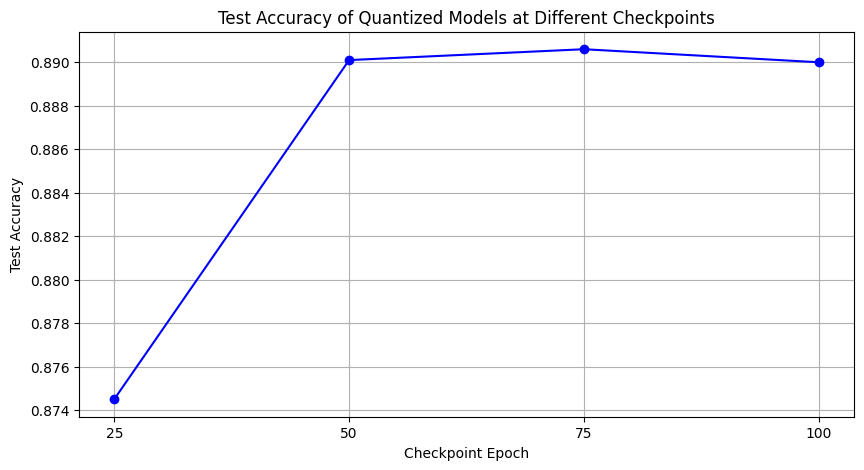

In [ ]:
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import fuse_modules

checkpoints = [x for x in range(25, 101, 25)]
test_accs = []

for cp in checkpoints:
    student_net = networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    checkpoint = torch.load(f'checkpoints_student/checkpoint_epoch_{cp}.pth')
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    student_net = torch.quantization.prepare_qat(student_net)
    
    student_net.load_state_dict(checkpoint['model_state_dict'])
    student_net.to(fast_device)
    student_net.eval()

    student_net.qconfig = torch.ao.quantization.get_default_qconfig('x86')

    student_net_prepared = torch.ao.quantization.prepare(student_net)

    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(fast_device)
            student_net_prepared(inputs)  # Run a forward pass to collect activation statistics
    student_net_prepared.to(fast_device)

    #student_net_int8 = torch.ao.quantization.convert(student_net_prepared)
    reproducibilitySeed()
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_prepared, test_loader, fast_device)
    print('test accuracy: ', test_accuracy)
    test_accs.append(test_accuracy)

# Plotting the test accuracies
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, test_accs, marker='o', linestyle='-', color='b')
plt.title('Test Accuracy of Quantized Models at Different Checkpoints')
plt.xlabel('Checkpoint Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.xticks(checkpoints)
plt.show()


### DML

In [ ]:
num_epochs = 200
print_every = 100

# Setup for the hyperparameters and training configurations
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
pruning_factor = 0

# Generate all combinations of hyperparameters
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'alpha': hparam_tuple[0],
        'T': hparam_tuple[1],
        'dropout_input': hparam_tuple[2][0],
        'dropout_hidden': hparam_tuple[2][1],
        'weight_decay': hparam_tuple[3],
        'lr_decay': hparam_tuple[4],
        'momentum': hparam_tuple[5],
        'lr': hparam_tuple[6]
    }
    hparams_list.append(hparam)

# Training and logging setup
csv_file = os.path.join(checkpoints_path_student_dml, "results_student.csv")
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Create multiple student models and their optimizers
student_models = [networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=False, fuse=False, qat=False, dif_arch=False),  networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=False, fuse=False, qat=False, dif_arch=True)]  # Create multiple instances for DML
optimizers = [optim.SGD(student.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0) for student in student_models]

def trainDML(student_models, hparam, num_epochs, train_loader, val_loader, optimizers, fast_device=torch.device('cuda:0')):
    for student in student_models:
        student.to(fast_device).train()

    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for data, labels in train_loader:
            data, labels = data.to(fast_device), labels.to(fast_device)

            # Zero the parameter gradients for all optimizers at the start of the batch processing
            for optimizer in optimizers:
                optimizer.zero_grad()

            outputs = [student(data) for student in student_models]
            losses = []

            # Calculate losses for all students but do not yet backpropagate
            for i, student_output in enumerate(outputs):
                loss = criterion(student_output, labels)  # Standard classification loss
                dml_loss = sum(F.mse_loss(F.softmax(student_output, dim=1), F.softmax(other_output, dim=1))
                               for j, other_output in enumerate(outputs) if i != j)
                total_loss = loss + dml_loss / (len(student_models) - 1)  # Normalize DML loss
                losses.append(total_loss)

            # Now backpropagate for all students
            for i, loss in enumerate(losses):
                loss.backward(retain_graph=True if i < len(student_models) - 1 else False)  # Retain graph for all but last loss

            # Step the optimizers after all gradients are calculated
            for optimizer in optimizers:
                optimizer.step()

        reproducibilitySeed()
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_models[0], test_loader, fast_device)
        print(f'Student {0} test accuracy at epoch {epoch}: {test_accuracy}')
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_models[1], test_loader, fast_device)
        print(f'Student {1} test accuracy at epoch {epoch}: {test_accuracy}')

        if (epoch + 1) % 25 == 0:
            for idx, student in enumerate(student_models):
                torch.save(student.state_dict(), f"{checkpoints_path_student_dml}student_{idx}_epoch_{epoch}.pth")
                print(f"Checkpoint saved for Student {idx} at Epoch {epoch + 1}: {checkpoints_path_student_dml}student_{idx}_epoch_{epoch}.pth")

        # Add validation and additional logging as necessary

    print("Training completed.")

# Make sure to call this function with the correct parameters and dataloaders
trainDML(student_models, hparam, 200, train_loader, val_loader, optimizers)
# Further steps such as evaluation and logging results to CSV as shown above

Student 0 test accuracy at epoch 0: 0.4302
Student 1 test accuracy at epoch 0: 0.7696
Student 0 test accuracy at epoch 1: 0.5102
Student 1 test accuracy at epoch 1: 0.8331
Student 0 test accuracy at epoch 2: 0.5591
Student 1 test accuracy at epoch 2: 0.8506
Student 0 test accuracy at epoch 3: 0.5937
Student 1 test accuracy at epoch 3: 0.8554


### Result

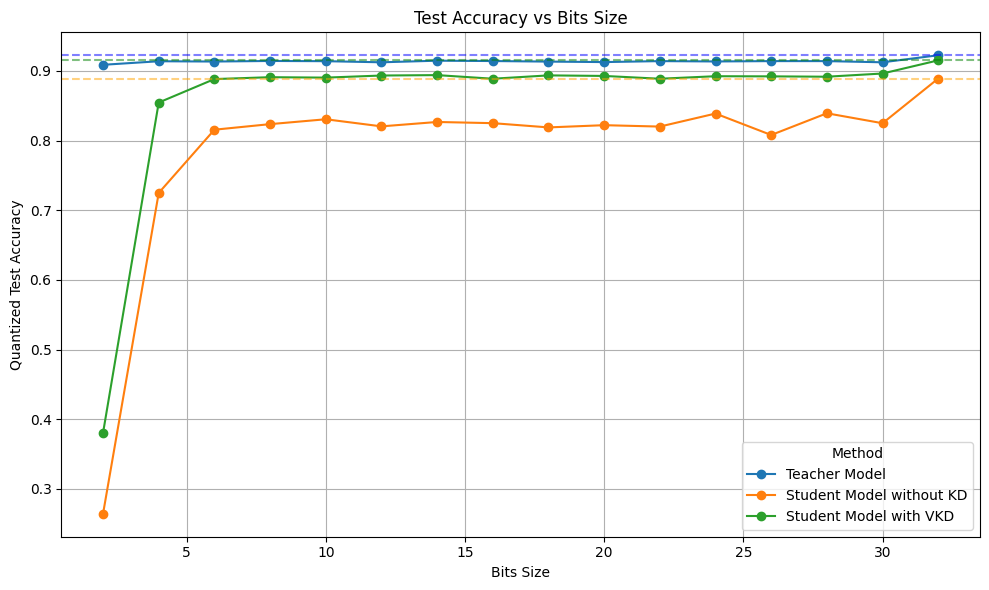

In [ ]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")
quant_student_nokd = pd.read_csv("checkpoints_student/checkpoints_student_NoKD/results_student_quantization.csv")
quant_student_van = pd.read_csv("checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv")

# Add a row with original accuracy to both dataframes
new_quant_teacher = pd.DataFrame({"Bits": [32], "Quantized Test Accuracy": [0.9225]})
quant_teacher = pd.concat([quant_teacher, new_quant_teacher], ignore_index=True)

new_quant_student_nokd = pd.DataFrame({"Bits": [32], "Quantized Test Accuracy": [0.8891]})
quant_student_nokd = pd.concat([quant_student_nokd, new_quant_student_nokd], ignore_index=True)

new_quant_student_van = pd.DataFrame({"Bits": [32], "Quantized Test Accuracy": [0.9152]})
quant_student_van = pd.concat([quant_student_van, new_quant_student_van], ignore_index=True)

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Quantized Test Accuracy"], marker='o', label="Teacher Model")
plt.plot(quant_student_nokd["Bits"], quant_student_nokd["Quantized Test Accuracy"], marker='o', label="Student Model without KD")
plt.plot(quant_student_van["Bits"], quant_student_van["Quantized Test Accuracy"], marker='o', label="Student Model with VKD")

# Add horizontal lines for original accuracy
plt.axhline(y=new_quant_teacher["Quantized Test Accuracy"].values[0], color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=new_quant_student_nokd["Quantized Test Accuracy"].values[0], color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=new_quant_student_van["Quantized Test Accuracy"].values[0], color='green', linestyle='--', alpha=0.5)

# Add labels and title
plt.title("Test Accuracy vs Bits Size")
plt.xlabel("Bits Size")
plt.ylabel("Quantized Test Accuracy")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Save the plot as PNG
plt.tight_layout()
plt.savefig('images/teacher_student_quant_acc_comparison.png')

# Show the plot
plt.show()


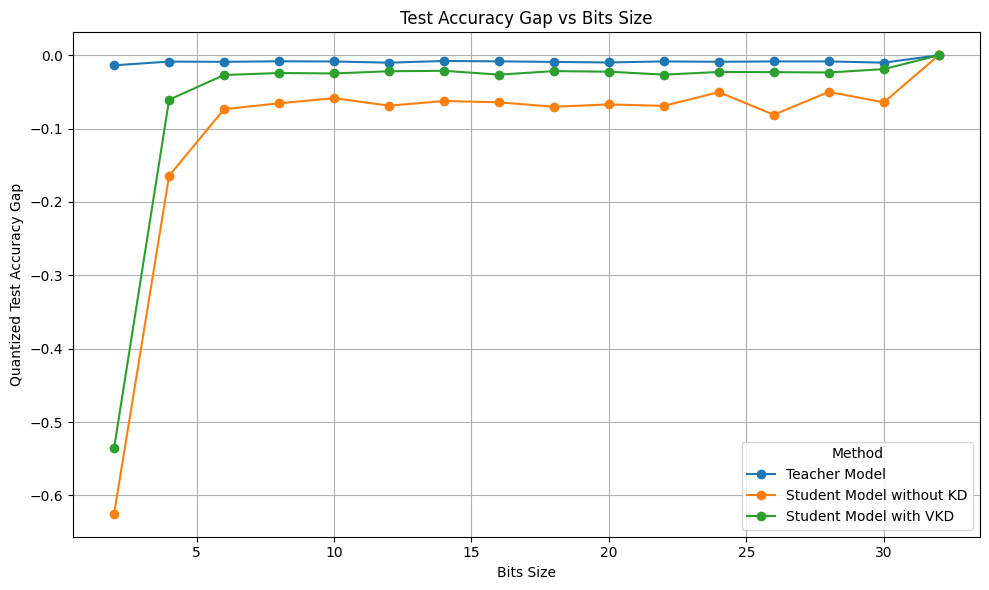

In [86]:
# Original accuracies
original_acc_teacher = 0.9225
original_acc_student_nokd = 0.8891
original_acc_student_van = 0.9152

# Adjusting quantized test accuracy by subtracting the original accuracy
quant_teacher['Quantized Test Accuracy Gap'] = quant_teacher['Quantized Test Accuracy'] - original_acc_teacher
quant_student_nokd['Quantized Test Accuracy Gap'] = quant_student_nokd['Quantized Test Accuracy'] - original_acc_student_nokd
quant_student_van['Quantized Test Accuracy Gap'] = quant_student_van['Quantized Test Accuracy'] - original_acc_student_van

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Quantized Test Accuracy Gap"], marker='o', label="Teacher Model")
plt.plot(quant_student_nokd["Bits"], quant_student_nokd["Quantized Test Accuracy Gap"], marker='o', label="Student Model without KD")
plt.plot(quant_student_van["Bits"], quant_student_van["Quantized Test Accuracy Gap"], marker='o', label="Student Model with VKD")

# Add labels and title
plt.title("Test Accuracy Gap vs Bits Size")
plt.xlabel("Bits Size")
plt.ylabel("Quantized Test Accuracy Gap")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Save the plot as PNG
plt.tight_layout()
plt.savefig('images/gap_teacher_student_quant_acc_comparison.png')

# Show the plot
plt.show()